# Experimentación - AGCRN

https://arxiv.org/abs/2007.02842


## 1. Obtención de datos



In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")

import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"
name_model = "AGCRN"
results_save_path = "./results"


In [3]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [6]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from sklearn.metrics import r2_score

from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.utils_graph import format_plot

from utils.utils_graph import reconstruir_predictions, plot_training_and_eval_losses, plot_predictions

from utils.trainer import TrainerModel, TrainerAGCRN
from utils.models import AGCRNModel
dtype = torch.float
device = torch.device("mps")

In [7]:
import itertools


def entrenar_y_evaluar_modelos(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem=""):
    """
    Entrena y evalúa modelos con diferentes combinaciones de hiperparámetros, y devuelve el mejor modelo,
    los mejores parámetros y un DataFrame con los resultados.

    Args:
        param_grid (dict): Diccionario con listas de valores de los hiperparámetros a probar.
        n_features (int): Número de características del nodo.
        n_nodes (int): Número de nodos.
        n_target (int): Número de objetivos.
        dataloader (object): Objeto que proporciona los datos para entrenamiento y evaluación.
        num_early_stop (int): Número de épocas para detenerse tempranamente si no hay mejora.
        num_epochs (int): Número de épocas para entrenar.
        lr (float): Tasa de aprendizaje.

    Returns:
        mejor_modelo (object): El mejor modelo entrenado.
        mejores_parametros (tuple): Los mejores parámetros (aggr, conv, lstm).
        resultados_gt (pd.DataFrame): DataFrame con los resultados de todas las combinaciones de hiperparámetros.
    """
    resultados_list = []

    #Vamos a guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None

    n_nodes =dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[1]
    n_features = dataset[0].x.shape[1]


    device =torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    for hidden, k, embedding in tqdm(list(itertools.product(param_grid["embedding"], param_grid["hidden_size"], param_grid["k"]))):
        

        model = AGCRNModel(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding, hidden_size=hidden,k=k, n_target=n_target, name="AGCRN")

        model.to(device)
        trainer = TrainerAGCRN(model, dataset,device, f"./results/{problem}", dataloader_params)


        losses,eval_losses, r2scores  = trainer.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
        r2score_tst,losses_tst, loss_nodes, _, _ = trainer.test()

        results_intermedio = {
            "Embedding": embedding,
            "k": k,
            "Hidden": hidden,
            "Loss_final": losses[-1],
            "R2_eval": np.mean(r2scores[-1]),
            "Loss_eval": np.mean(eval_losses[-1]),
            "R2_tst": np.mean(r2score_tst),
            "Loss_tst": np.mean(losses_tst),
            "Loss_nodes": np.mean(loss_nodes, axis=0).tolist()
        }
        # Añade los resultados a la lista
        resultados_list.append(results_intermedio)

        if np.mean(losses_tst) < mejor_loss_test:
            mejor_loss_test = np.mean(losses_tst)
            mejor_trainer = trainer
            mejores_parametros = {'hidden': hidden, 'K': k, 'embedding': embedding}
            mejores_resultados = results_intermedio

        print("Parámetros: ", hidden, k, embedding)
        print("Resultados: ", resultados_list[-1])

    resultados = pd.DataFrame(resultados_list)

    return mejor_trainer, mejores_parametros, mejores_resultados, resultados


## Prueba - predicción por tipos

In [8]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":True
}

param_grid = {
    "hidden_size": [10,20,50],
    "embedding": [3,5, 10, 15], 
    "k": [2, 3, 4]
}
num_early_stop = 0
num_epochs = 30
lr = 0.01

### Gen trip

In [9]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [10]:

n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
embedding_dim =5

#### Sencilla 

In [26]:
model_gt = AGCRNModel(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="RecurrentGCNInicial")
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model_gt.to(device)
trainer_gt = TrainerAGCRN(model_gt, dataset_gt,device, f"./results/{problem_gt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_gt.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 870
DataLoader for val set:
Number of batches: 186
DataLoader for test set:
Number of batches: 188

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.0860 | Eval Loss: 0.0400 | Eval R2: -5.6928 | 
Epoch 2/30 | Train Loss: 0.0189 | Eval Loss: 0.0228 | Eval R2: -2.0131 | 
Epoch 3/30 | Train Loss: 0.0152 | Eval Loss: 0.0203 | Eval R2: -1.5779 | 
Epoch 4/30 | Train Loss: 0.0138 | Eval Loss: 0.0186 | Eval R2: -1.2508 | 
Epoch 5/30 | Train Loss: 0.0130 | Eval Loss: 0.0177 | Eval R2: -1.1164 | 
Epoch 6/30 | Train Loss: 0.0124 | Eval Loss: 0.0164 | Eval R2: -0.8566 | 
Epoch 7/30 | Train Loss: 0.0121 | Eval Loss: 0.0166 | Eval R2: -0.9129 | 
Epoch 8/30 | Train Loss: 0.0119 | Eval Loss: 0.0156 | Eval R2: -0.6918 | 
Epoch 9/30 | Train Loss: 0.0116 |

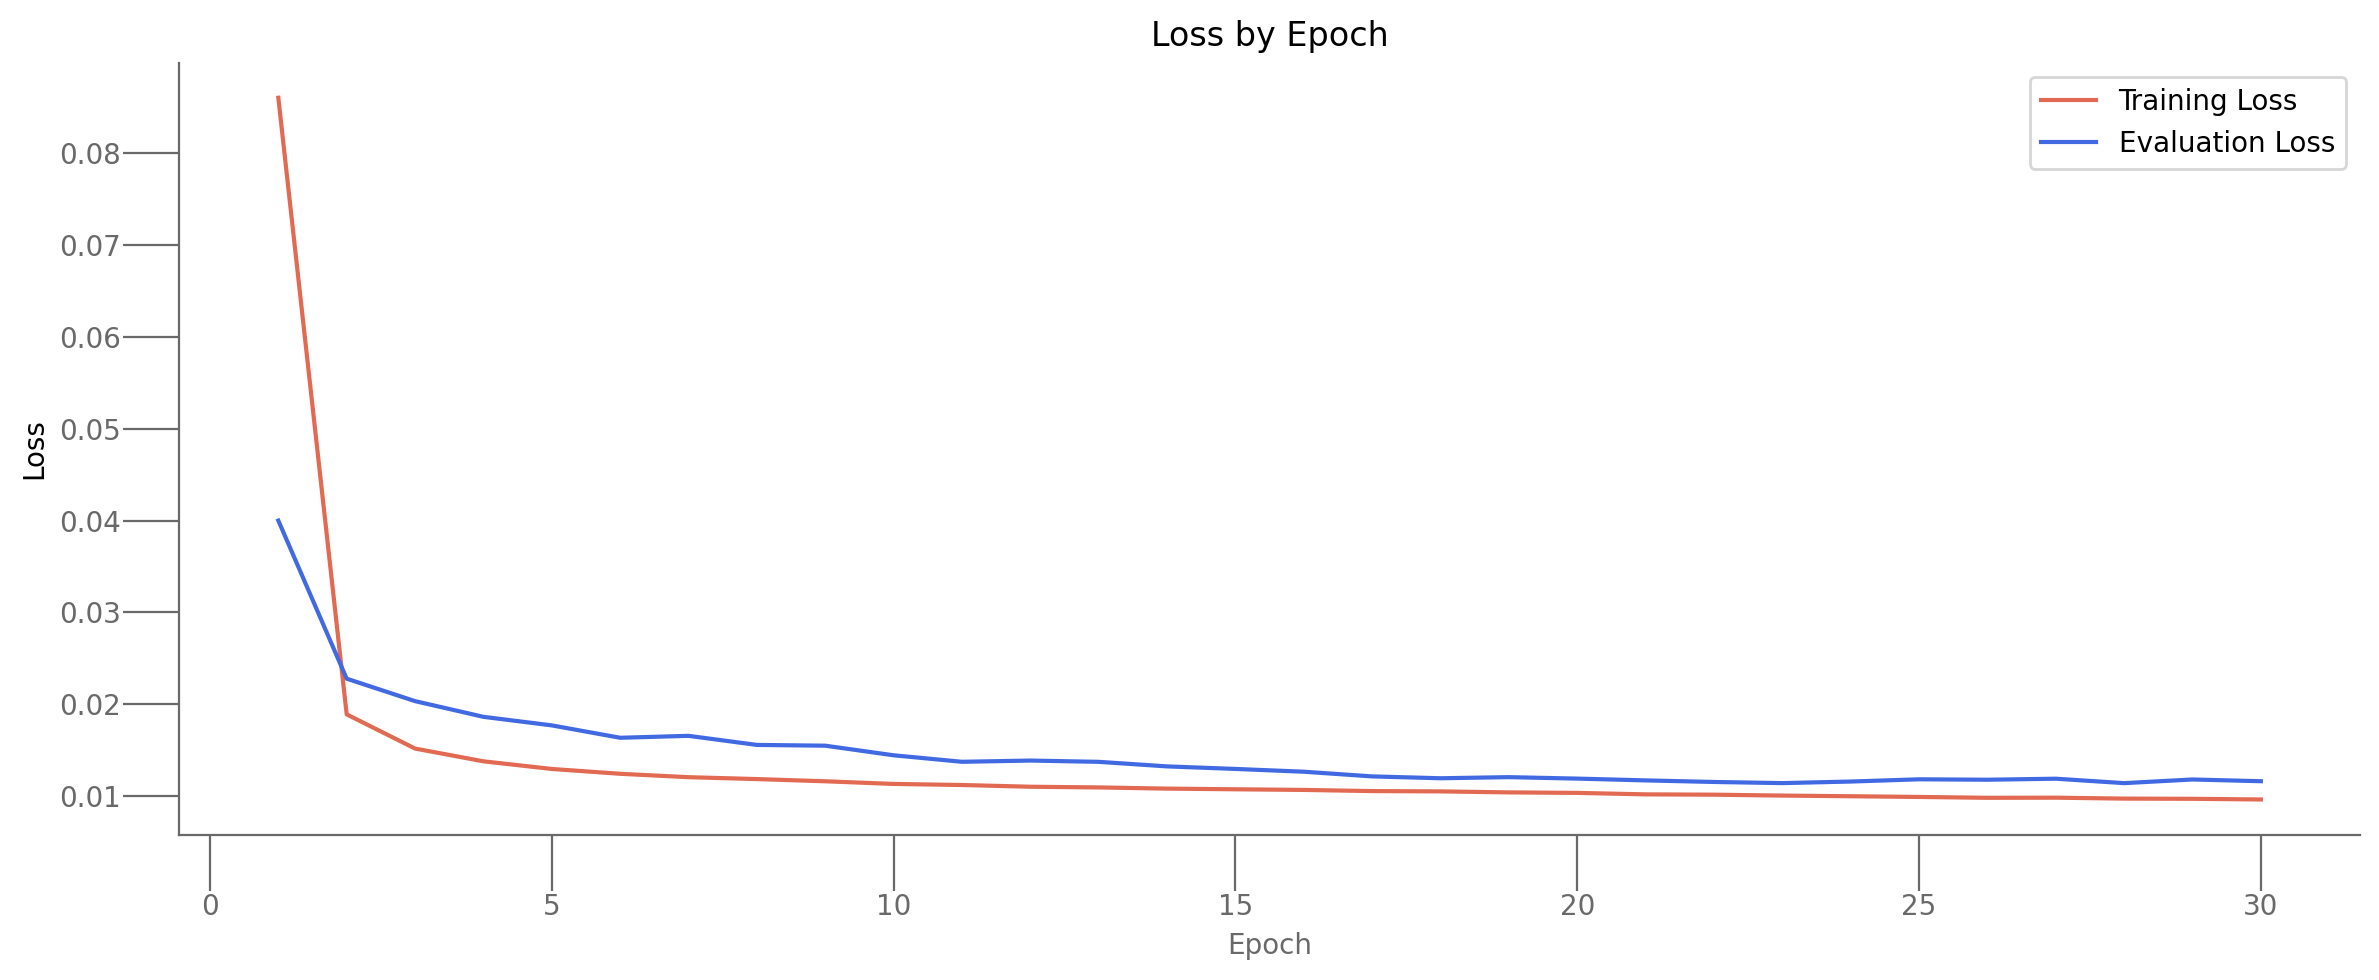


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.009161, test r2score 0.034857


In [27]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_gt, real_gt = trainer_gt.test()



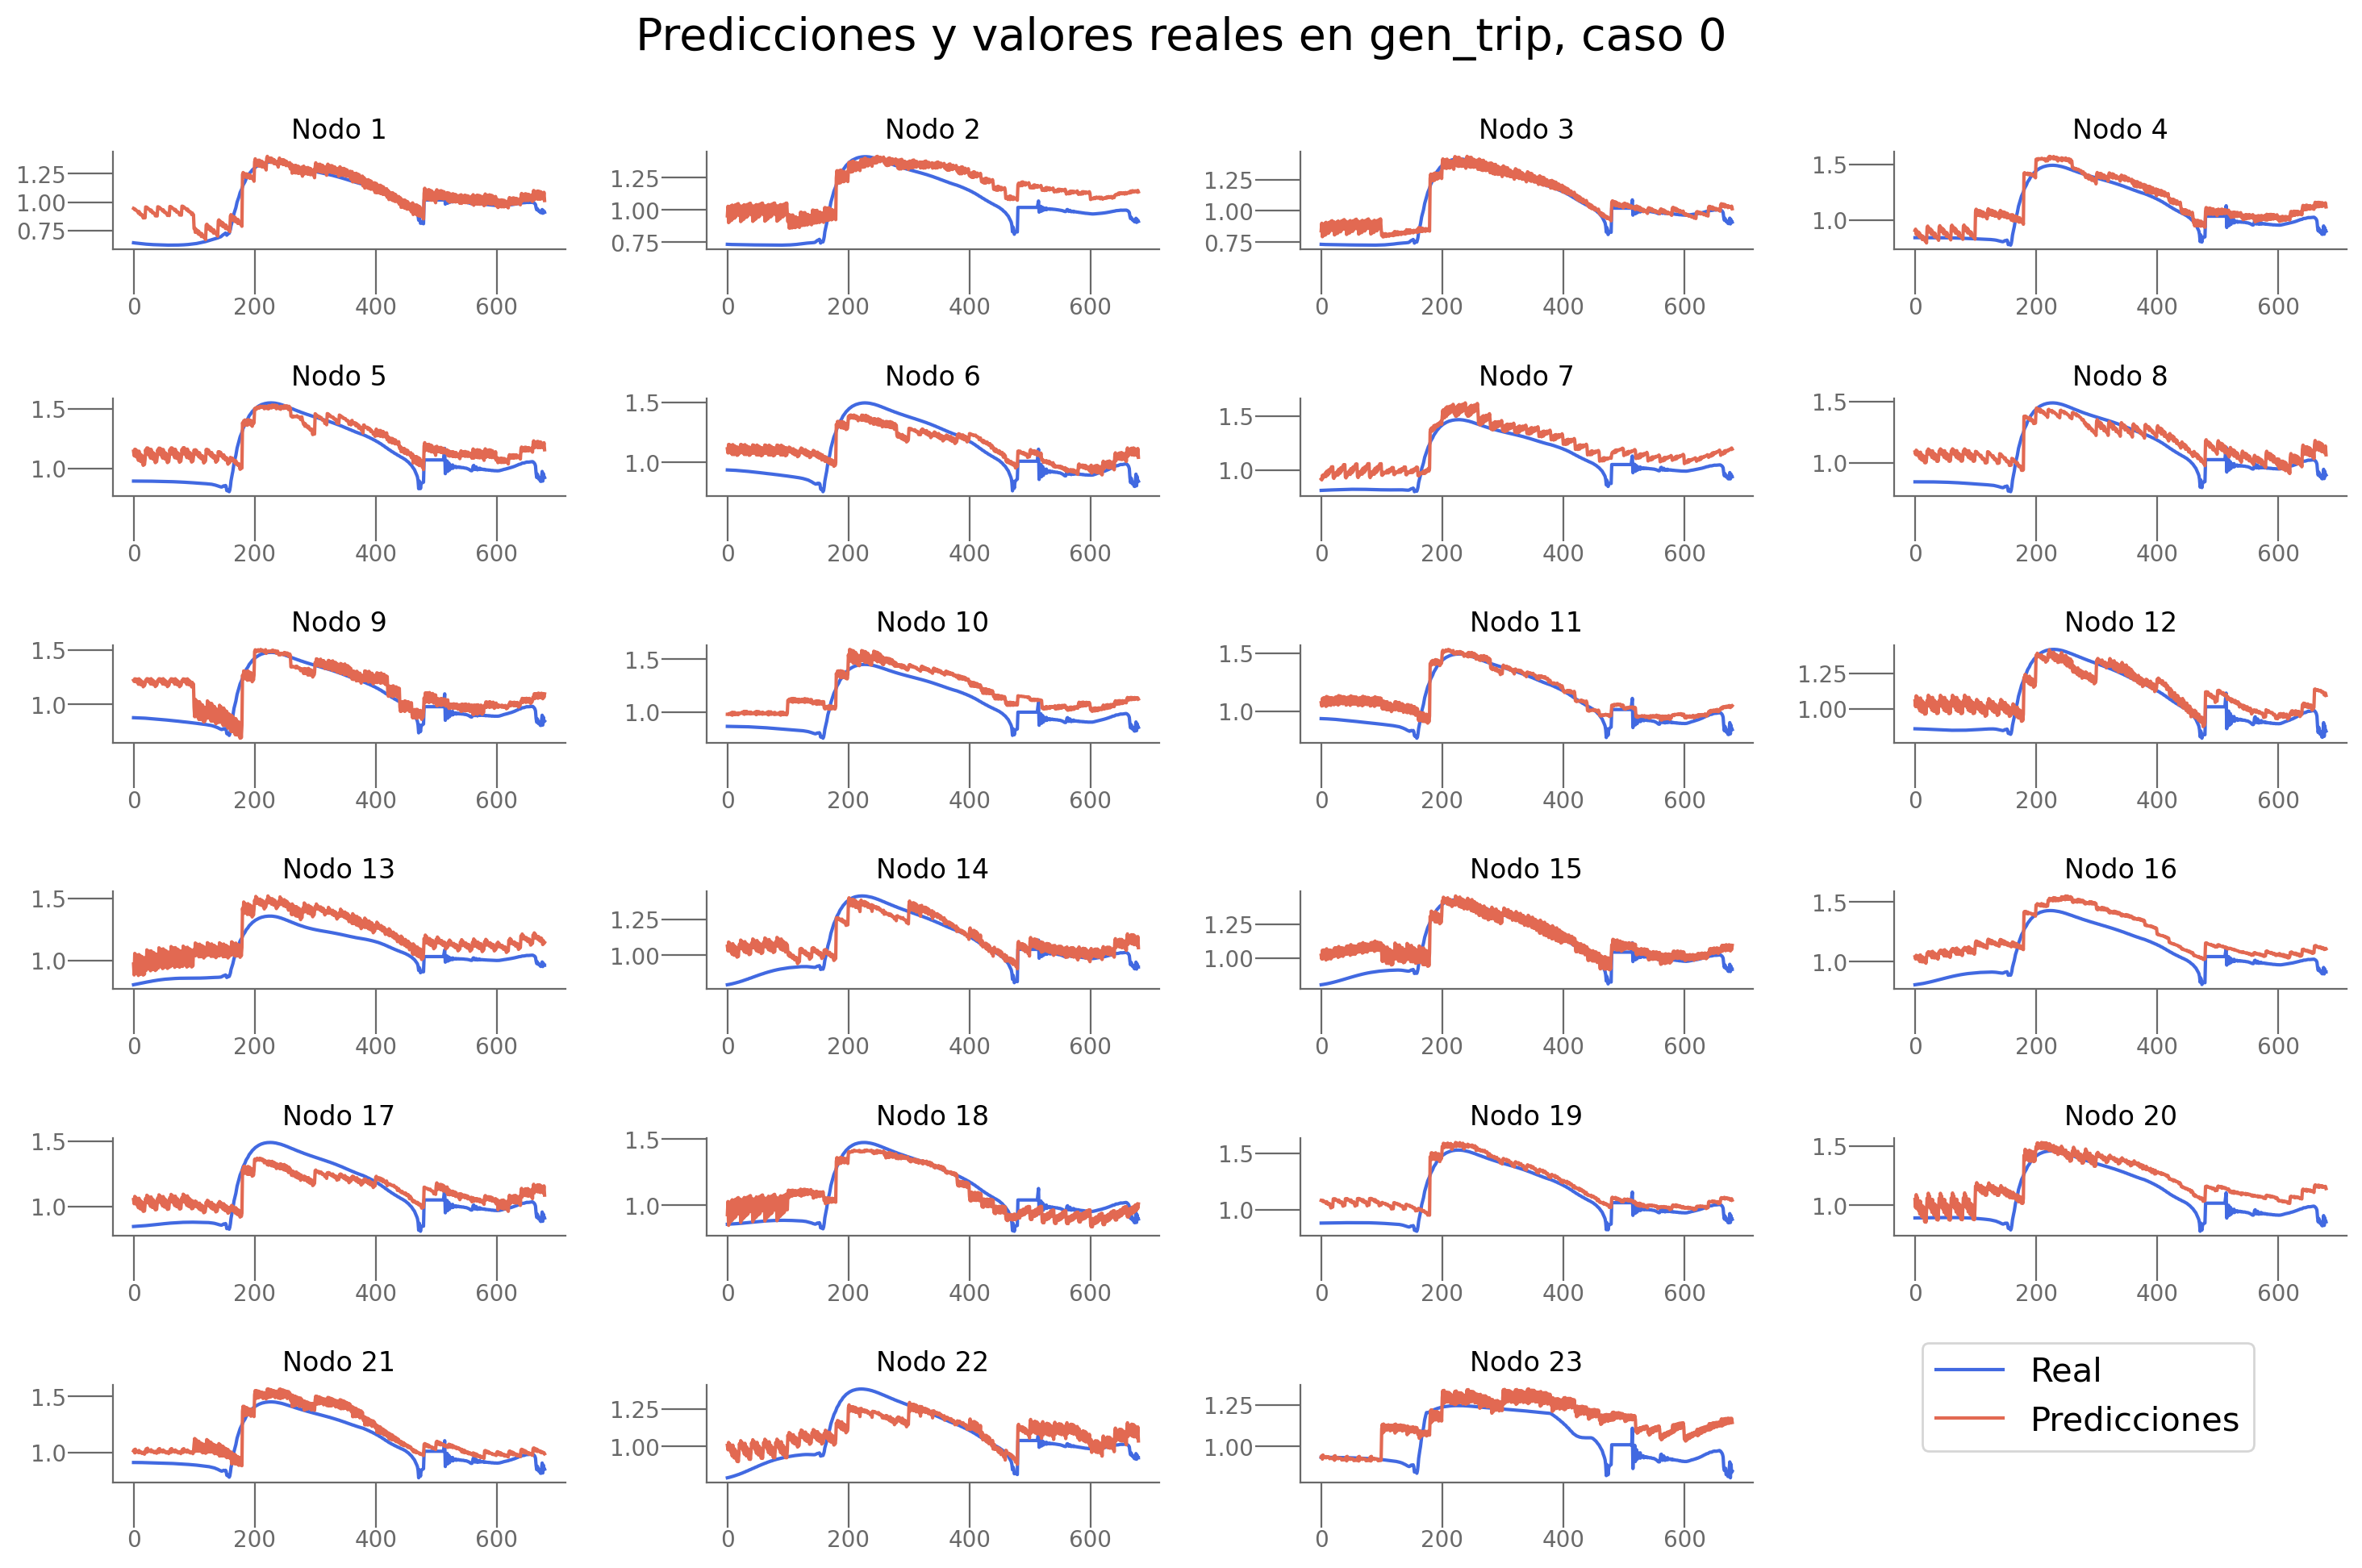

In [32]:
plot_predictions(predictions_gt, real_gt, n_target, 0, n_div_gt, problem_gt)

#### Ajuste de parámetros

In [11]:
from importlib import reload
import utils.trainer
utils.trainer = reload(utils.trainer)
from utils.trainer import TrainerAGCRN

In [12]:


trainer_gt,params_gt, resultados_final_gt, resultados_gt = entrenar_y_evaluar_modelos(param_grid, dataset_gt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_gt)

  0%|          | 0/36 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 870
DataLoader for val set:
Number of batches: 186
DataLoader for test set:
Number of batches: 188

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.4038 | Eval Loss: 0.1072 | Eval R2: -12.8013 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.0838 | Eval Loss: 0.0645 | Eval R2: -6.7724 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.0636 | Eval Loss: 0.0511 | Eval R2: -4.8084 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.0588 | Eval Loss: 0.0469 | Eval R2: -3.9240 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.0550 | Eval Loss: 0.0466 | Eval R2: -3.7520 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.0540 | Eval Loss: 0.0461 | Eval R2: -3.6592 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.0521 | Eval Loss: 0.0520 | Eval R2: -7.0102 | LR: 0.0010 | 
Epoch 8/30 | Tr

  3%|▎         | 1/36 [07:23<4:18:42, 443.49s/it]

preds:  (5, 23, 20)
test loss: 0.027963, test R2 score: -3.507755
Parámetros:  3 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 3, 'Loss_final': 0.040045127272605896, 'R2_eval': -2.9476821422576904, 'Loss_eval': 0.034638259559869766, 'R2_tst': -3.507754669939365, 'Loss_tst': 0.02796316333115101, 'Loss_nodes': [0.023800402879714966, 0.019426532089710236, 0.015509819611907005, 0.023853477090597153, 0.02944488637149334, 0.03238256648182869, 0.018646037206053734, 0.018591927364468575, 0.054135046899318695, 0.03052517957985401, 0.03451056778430939, 0.02742653526365757, 0.014616727828979492, 0.028941623866558075, 0.027523236349225044, 0.04843256250023842, 0.023274706676602364, 0.017096830531954765, 0.03333313390612602, 0.02965090051293373, 0.02288052625954151, 0.027474865317344666, 0.04167464002966881]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoa

  6%|▌         | 2/36 [15:02<4:16:21, 452.40s/it]

preds:  (5, 23, 20)
test loss: 0.022280, test R2 score: -2.894526
Parámetros:  3 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 3, 'Loss_final': 0.03559526801109314, 'R2_eval': -2.0214972496032715, 'Loss_eval': 0.029792021960020065, 'R2_tst': -2.8945261783956684, 'Loss_tst': 0.022280018776655197, 'Loss_nodes': [0.01706189662218094, 0.014242923818528652, 0.020667789503932, 0.02522026188671589, 0.023106684908270836, 0.028667472302913666, 0.015001581981778145, 0.018730496987700462, 0.029186159372329712, 0.021002862602472305, 0.022948550060391426, 0.01939447596669197, 0.012421349063515663, 0.02432902529835701, 0.027959810569882393, 0.02732304111123085, 0.01794787123799324, 0.019707823172211647, 0.02229439653456211, 0.028934724628925323, 0.031225090846419334, 0.023862820118665695, 0.021203363314270973]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLo

  8%|▊         | 3/36 [22:18<4:04:53, 445.26s/it]

preds:  (5, 23, 20)
test loss: 0.032038, test R2 score: -4.308566
Parámetros:  3 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 3, 'Loss_final': 0.03928644210100174, 'R2_eval': -3.5690619945526123, 'Loss_eval': 0.040551912039518356, 'R2_tst': -4.308566244026141, 'Loss_tst': 0.0320381335914135, 'Loss_nodes': [0.01633872464299202, 0.04063573107123375, 0.0351489819586277, 0.02817552164196968, 0.027846068143844604, 0.02371891960501671, 0.06813192367553711, 0.02013077586889267, 0.10806092619895935, 0.02663351036608219, 0.0593046210706234, 0.02381722442805767, 0.010901868343353271, 0.012000019662082195, 0.023349616676568985, 0.015863094478845596, 0.07279396057128906, 0.016525866463780403, 0.02401922270655632, 0.01933668926358223, 0.017688388004899025, 0.024681923910975456, 0.021773476153612137]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for 

 11%|█         | 4/36 [31:46<4:23:07, 493.37s/it]

preds:  (5, 23, 20)
test loss: 0.047616, test R2 score: -5.800384
Parámetros:  3 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 3, 'Loss_final': 0.060251716524362564, 'R2_eval': -5.222177982330322, 'Loss_eval': 0.056905049830675125, 'R2_tst': -5.8003835167251445, 'Loss_tst': 0.04761621356010437, 'Loss_nodes': [0.0709405168890953, 0.06959689408540726, 0.01315982174128294, 0.030714835971593857, 0.02589690499007702, 0.07617807388305664, 0.02452169917523861, 0.0727972760796547, 0.056639473885297775, 0.039584625512361526, 0.07564280182123184, 0.0661880299448967, 0.024690235033631325, 0.05550769716501236, 0.05861472710967064, 0.0349741093814373, 0.014563687145709991, 0.02952895499765873, 0.07713485509157181, 0.06752197444438934, 0.02845548279583454, 0.04947832226753235, 0.032841939479112625]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for tra

 14%|█▍        | 5/36 [41:36<4:33:05, 528.57s/it]

preds:  (5, 23, 20)
test loss: 0.029916, test R2 score: -3.898037
Parámetros:  3 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 3, 'Loss_final': 0.04183296114206314, 'R2_eval': -3.4109044075012207, 'Loss_eval': 0.03919018432497978, 'R2_tst': -3.8980369811508404, 'Loss_tst': 0.02991635724902153, 'Loss_nodes': [0.028211098164319992, 0.029126785695552826, 0.027384668588638306, 0.029099585488438606, 0.03442540392279625, 0.03537730127573013, 0.025585735216736794, 0.033661846071481705, 0.03422081843018532, 0.02896851673722267, 0.028084002435207367, 0.027299482375383377, 0.03598742187023163, 0.026124125346541405, 0.025645548477768898, 0.024419933557510376, 0.036902863532304764, 0.035124100744724274, 0.031288031488657, 0.03238026797771454, 0.028554614633321762, 0.023649845272302628, 0.026554247364401817]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoa

 17%|█▋        | 6/36 [51:43<4:37:31, 555.06s/it]

preds:  (5, 23, 20)
test loss: 0.051033, test R2 score: -5.997189
Parámetros:  3 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 3, 'Loss_final': 0.0709308385848999, 'R2_eval': -5.570168972015381, 'Loss_eval': 0.0636303722858429, 'R2_tst': -5.997188840940146, 'Loss_tst': 0.05103323981165886, 'Loss_nodes': [0.06626574695110321, 0.03973299637436867, 0.06805487722158432, 0.0722554549574852, 0.03753293305635452, 0.04731374606490135, 0.07290495187044144, 0.04318683221936226, 0.07471202313899994, 0.04609682038426399, 0.07569941878318787, 0.06703978031873703, 0.023058421909809113, 0.0304501261562109, 0.0331948958337307, 0.031291622668504715, 0.07854988425970078, 0.030396126210689545, 0.03825061768293381, 0.06733789294958115, 0.07430148869752884, 0.027562357485294342, 0.02857537753880024]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train set

 19%|█▉        | 7/36 [1:10:31<5:58:51, 742.45s/it]

preds:  (5, 23, 20)
test loss: 0.048073, test R2 score: -6.907921
Parámetros:  3 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 3, 'Loss_final': 0.057968683540821075, 'R2_eval': -6.085472106933594, 'Loss_eval': 0.05909699946641922, 'R2_tst': -6.907920760915237, 'Loss_tst': 0.04807252064347267, 'Loss_nodes': [0.049108151346445084, 0.06612735241651535, 0.06876972317695618, 0.03240647539496422, 0.03774275258183479, 0.09270600229501724, 0.03240717574954033, 0.0739971250295639, 0.033611249178647995, 0.03508156165480614, 0.050447627902030945, 0.04023946821689606, 0.04394449666142464, 0.026913823559880257, 0.025849048048257828, 0.02582843229174614, 0.06927849352359772, 0.06982395052909851, 0.08011462539434433, 0.042240776121616364, 0.03457925468683243, 0.036040984094142914, 0.03840940073132515]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for t

 22%|██▏       | 8/36 [1:30:02<6:50:04, 878.75s/it]

preds:  (5, 23, 20)
test loss: 0.065971, test R2 score: -8.464117
Parámetros:  3 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 3, 'Loss_final': 0.08715517818927765, 'R2_eval': -7.96714973449707, 'Loss_eval': 0.08025795221328735, 'R2_tst': -8.464116783238183, 'Loss_tst': 0.0659712553024292, 'Loss_nodes': [0.07502305507659912, 0.0722464993596077, 0.06911642104387283, 0.07201577723026276, 0.08010741323232651, 0.07550780475139618, 0.065739706158638, 0.07279054820537567, 0.07533792406320572, 0.06886128336191177, 0.07489025592803955, 0.0667012631893158, 0.042908925563097, 0.055417370051145554, 0.05837475508451462, 0.058310553431510925, 0.06880298256874084, 0.0673690214753151, 0.07527118921279907, 0.06724181771278381, 0.06683871150016785, 0.04941597208380699, 0.03904948756098747]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train set:
Numb

 25%|██▌       | 9/36 [1:48:22<7:06:32, 947.88s/it]

preds:  (5, 23, 20)
test loss: 0.065778, test R2 score: -8.401027
Parámetros:  3 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 3, 'Loss_final': 0.08700420707464218, 'R2_eval': -7.920643329620361, 'Loss_eval': 0.08006975799798965, 'R2_tst': -8.401026826422994, 'Loss_tst': 0.06577791273593903, 'Loss_nodes': [0.07444964349269867, 0.0707932710647583, 0.06891530752182007, 0.07203474640846252, 0.07798982411623001, 0.07542891800403595, 0.0658288225531578, 0.07272043824195862, 0.07472096383571625, 0.06868921220302582, 0.07520819455385208, 0.06627445667982101, 0.04282775893807411, 0.055489782243967056, 0.05841575190424919, 0.05830661207437515, 0.06877308338880539, 0.06796185672283173, 0.0754292830824852, 0.06730373948812485, 0.06684289872646332, 0.04959587752819061, 0.03889166936278343]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train set:

 28%|██▊       | 10/36 [1:55:38<5:42:16, 789.86s/it]

preds:  (5, 23, 20)
test loss: 0.018523, test R2 score: -1.902158
Parámetros:  5 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 5, 'Loss_final': 0.019249621778726578, 'R2_eval': -1.2101775407791138, 'Loss_eval': 0.020896725356578827, 'R2_tst': -1.902158241864729, 'Loss_tst': 0.018522825092077255, 'Loss_nodes': [0.02061293087899685, 0.007807096932083368, 0.010931885801255703, 0.02620941586792469, 0.0190235897898674, 0.023077454417943954, 0.011432399973273277, 0.010628457181155682, 0.02437545731663704, 0.023339999839663506, 0.023168768733739853, 0.020252857357263565, 0.017296820878982544, 0.024183090776205063, 0.016603142023086548, 0.012444457039237022, 0.016815917566418648, 0.013139779679477215, 0.018314478918910027, 0.01781187579035759, 0.022846171632409096, 0.02539830468595028, 0.02031060867011547]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

Data

 31%|███       | 11/36 [2:02:33<4:41:21, 675.24s/it]

preds:  (5, 23, 20)
test loss: 0.019700, test R2 score: -2.019102
Parámetros:  5 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 5, 'Loss_final': 0.019844533875584602, 'R2_eval': -0.9082731604576111, 'Loss_eval': 0.021238135173916817, 'R2_tst': -2.019101510167235, 'Loss_tst': 0.019699841737747192, 'Loss_nodes': [0.010569645091891289, 0.0115079116076231, 0.02628452517092228, 0.017814375460147858, 0.02226792462170124, 0.01713542826473713, 0.017906196415424347, 0.018895523622632027, 0.02369498275220394, 0.020320869982242584, 0.020713884383440018, 0.01846998929977417, 0.01970941759645939, 0.017807938158512115, 0.013344693928956985, 0.015709886327385902, 0.01781965047121048, 0.016148991882801056, 0.036296918988227844, 0.020600514486432076, 0.02056114934384823, 0.023981712758541107, 0.02553427964448929]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoa

 33%|███▎      | 12/36 [2:09:19<3:57:21, 593.41s/it]

preds:  (5, 23, 20)
test loss: 0.022370, test R2 score: -2.185495
Parámetros:  5 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 5, 'Loss_final': 0.027517179027199745, 'R2_eval': -1.6443312168121338, 'Loss_eval': 0.027327170595526695, 'R2_tst': -2.185494518626569, 'Loss_tst': 0.022370386868715286, 'Loss_nodes': [0.037246666848659515, 0.01200645137578249, 0.01671520248055458, 0.02128017134964466, 0.022141246125102043, 0.024641651660203934, 0.031024238094687462, 0.01854483224451542, 0.024455569684505463, 0.020796669647097588, 0.04577535763382912, 0.028532294556498528, 0.011407970450818539, 0.01789018139243126, 0.020143479108810425, 0.014434910379350185, 0.033061683177948, 0.0223933607339859, 0.01851511374115944, 0.021935855969786644, 0.022660082206130028, 0.015505404211580753, 0.01341047789901495]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoade

 36%|███▌      | 13/36 [2:18:13<3:40:35, 575.45s/it]

preds:  (5, 23, 20)
test loss: 0.039934, test R2 score: -6.046186
Parámetros:  5 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 5, 'Loss_final': 0.045671142637729645, 'R2_eval': -4.637691497802734, 'Loss_eval': 0.047314275056123734, 'R2_tst': -6.046185981858418, 'Loss_tst': 0.039933811873197556, 'Loss_nodes': [0.04994017630815506, 0.03924081474542618, 0.06683353334665298, 0.030839266255497932, 0.03218014910817146, 0.03444574400782585, 0.02513592317700386, 0.024929318577051163, 0.03377976641058922, 0.040166597813367844, 0.04591599479317665, 0.044312167912721634, 0.04899870604276657, 0.021958034485578537, 0.01964590698480606, 0.02070055529475212, 0.07859034091234207, 0.07615870982408524, 0.025443965569138527, 0.040331389755010605, 0.03138554096221924, 0.024356327950954437, 0.06318880617618561]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader f

 39%|███▉      | 14/36 [2:28:31<3:35:42, 588.27s/it]

preds:  (5, 23, 20)
test loss: 0.023817, test R2 score: -2.762378
Parámetros:  5 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 5, 'Loss_final': 0.0338524654507637, 'R2_eval': -2.164010763168335, 'Loss_eval': 0.031731560826301575, 'R2_tst': -2.7623784256846737, 'Loss_tst': 0.023817433044314384, 'Loss_nodes': [0.024014458060264587, 0.022934725508093834, 0.02323048934340477, 0.022837119176983833, 0.02408764697611332, 0.027966991066932678, 0.02553516998887062, 0.02095910534262657, 0.02579025737941265, 0.021980658173561096, 0.021806785836815834, 0.023427998647093773, 0.018734075129032135, 0.023929603397846222, 0.02498251013457775, 0.024011539295315742, 0.021412689238786697, 0.026942811906337738, 0.02674179896712303, 0.024296989664435387, 0.027610518038272858, 0.02252599038183689, 0.022041041404008865]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLo

 42%|████▏     | 15/36 [2:38:31<3:27:06, 591.74s/it]

preds:  (5, 23, 20)
test loss: 0.032563, test R2 score: -3.832438
Parámetros:  5 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 5, 'Loss_final': 0.047528233379125595, 'R2_eval': -3.239091157913208, 'Loss_eval': 0.04186556860804558, 'R2_tst': -3.832438323875898, 'Loss_tst': 0.0325629785656929, 'Loss_nodes': [0.029712621122598648, 0.02482367306947708, 0.07348687201738358, 0.0726587250828743, 0.027193721383810043, 0.025975031778216362, 0.030415907502174377, 0.021244103088974953, 0.05103588104248047, 0.02108865976333618, 0.029343077912926674, 0.06801677495241165, 0.01578824408352375, 0.01882973499596119, 0.020832834765315056, 0.021289894357323647, 0.023545779287815094, 0.02012467011809349, 0.022156547755002975, 0.06781334429979324, 0.024333421140909195, 0.018524330109357834, 0.020714661106467247]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader 

 44%|████▍     | 16/36 [3:01:08<4:33:59, 821.98s/it]

preds:  (5, 23, 20)
test loss: 0.040800, test R2 score: -6.567418
Parámetros:  5 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 5, 'Loss_final': 0.05574458837509155, 'R2_eval': -6.143458843231201, 'Loss_eval': 0.051545433700084686, 'R2_tst': -6.567417912087123, 'Loss_tst': 0.040800467133522034, 'Loss_nodes': [0.03475275635719299, 0.11365166306495667, 0.03806015104055405, 0.04513802006840706, 0.04398385062813759, 0.07690179347991943, 0.028167182579636574, 0.029822049662470818, 0.041632793843746185, 0.03747791796922684, 0.043824296444654465, 0.03589508309960365, 0.0326051339507103, 0.02351718209683895, 0.02475523017346859, 0.029462730512022972, 0.032335881143808365, 0.04468479007482529, 0.031010376289486885, 0.037795569747686386, 0.04523737356066704, 0.021957311779260635, 0.0457417294383049]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for

 47%|████▋     | 17/36 [3:18:40<4:42:15, 891.36s/it]

preds:  (5, 23, 20)
test loss: 0.065971, test R2 score: -8.548644
Parámetros:  5 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 5, 'Loss_final': 0.08700267970561981, 'R2_eval': -8.007323265075684, 'Loss_eval': 0.08013961464166641, 'R2_tst': -8.548643909989408, 'Loss_tst': 0.06597060710191727, 'Loss_nodes': [0.07165538519620895, 0.07073285430669785, 0.06887185573577881, 0.07304812967777252, 0.07934023439884186, 0.07580289244651794, 0.06581012159585953, 0.07273510843515396, 0.07739803940057755, 0.06871841102838516, 0.07522594928741455, 0.06719858199357986, 0.04284476116299629, 0.05539185553789139, 0.05843079462647438, 0.05852185934782028, 0.06883791834115982, 0.06787177175283432, 0.07503639161586761, 0.06723816692829132, 0.0669783428311348, 0.05071119964122772, 0.03892332315444946]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train set

 50%|█████     | 18/36 [3:36:21<4:42:38, 942.13s/it]

preds:  (5, 23, 20)
test loss: 0.066047, test R2 score: -8.577227
Parámetros:  5 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 5, 'Loss_final': 0.08714562654495239, 'R2_eval': -8.035189628601074, 'Loss_eval': 0.08023757487535477, 'R2_tst': -8.577226817591121, 'Loss_tst': 0.06604686379432678, 'Loss_nodes': [0.06905089318752289, 0.06949130445718765, 0.07182341068983078, 0.07222812622785568, 0.08127793669700623, 0.07544606924057007, 0.06587596982717514, 0.07312614470720291, 0.07592185586690903, 0.0701306089758873, 0.07471943646669388, 0.0672367587685585, 0.04420117288827896, 0.05594722926616669, 0.058750297874212265, 0.058539703488349915, 0.06877384334802628, 0.06793785095214844, 0.07467435300350189, 0.06741809844970703, 0.06797736883163452, 0.05011335760354996, 0.03841628506779671]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train se

 53%|█████▎    | 19/36 [3:42:57<3:40:29, 778.22s/it]

preds:  (5, 23, 20)
test loss: 0.015784, test R2 score: -1.169959
Parámetros:  10 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 10, 'Loss_final': 0.01626008376479149, 'R2_eval': -0.6426692605018616, 'Loss_eval': 0.018689239397644997, 'R2_tst': -1.1699591721229456, 'Loss_tst': 0.01578403264284134, 'Loss_nodes': [0.016600290313363075, 0.010722395963966846, 0.009166627191007137, 0.01614035852253437, 0.016283154487609863, 0.016130950301885605, 0.010390566661953926, 0.01438780315220356, 0.018298620358109474, 0.0167777668684721, 0.02090146765112877, 0.014841199852526188, 0.012164486572146416, 0.010900234803557396, 0.011682853102684021, 0.01029216032475233, 0.010530972853302956, 0.013924608938395977, 0.0188502948731184, 0.015415919944643974, 0.014617493376135826, 0.050199076533317566, 0.013813442550599575]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

Dat

 56%|█████▌    | 20/36 [3:49:39<2:57:24, 665.28s/it]

preds:  (5, 23, 20)
test loss: 0.014128, test R2 score: -0.751687
Parámetros:  10 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 10, 'Loss_final': 0.01840282790362835, 'R2_eval': -0.34273263812065125, 'Loss_eval': 0.017218714579939842, 'R2_tst': -0.7516867505608233, 'Loss_tst': 0.014127734117209911, 'Loss_nodes': [0.014100880362093449, 0.009730998426675797, 0.014275253750383854, 0.013394505716860294, 0.013340869918465614, 0.01737232692539692, 0.009980187751352787, 0.012390300631523132, 0.027718117460608482, 0.013524087145924568, 0.016816217452287674, 0.0136744799092412, 0.008698651567101479, 0.011166897602379322, 0.011474869213998318, 0.012851731851696968, 0.012382051907479763, 0.013803551904857159, 0.019881006330251694, 0.014677428640425205, 0.017125790938735008, 0.01212299894541502, 0.014434642158448696]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ==================

 58%|█████▊    | 21/36 [3:57:01<2:29:32, 598.18s/it]

preds:  (5, 23, 20)
test loss: 0.015563, test R2 score: -1.335841
Parámetros:  10 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 10, 'Loss_final': 0.015795523300766945, 'R2_eval': -0.6389676928520203, 'Loss_eval': 0.017833592370152473, 'R2_tst': -1.3358406519583905, 'Loss_tst': 0.01556328870356083, 'Loss_nodes': [0.01021827943623066, 0.006538065616041422, 0.015793636441230774, 0.016025394201278687, 0.016657061874866486, 0.01853317953646183, 0.014805457554757595, 0.015266538597643375, 0.017297638580203056, 0.019544357433915138, 0.023101430386304855, 0.018769364804029465, 0.013180805370211601, 0.013243497349321842, 0.01480211690068245, 0.011607130989432335, 0.01827501319348812, 0.012758422642946243, 0.019719114527106285, 0.012275011278688908, 0.01725761592388153, 0.019032280892133713, 0.013254252262413502]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================


 61%|██████    | 22/36 [4:07:24<2:21:17, 605.56s/it]

preds:  (5, 23, 20)
test loss: 0.017348, test R2 score: -1.438200
Parámetros:  10 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 10, 'Loss_final': 0.02303481474518776, 'R2_eval': -0.8662395477294922, 'Loss_eval': 0.02065413072705269, 'R2_tst': -1.4382003398730445, 'Loss_tst': 0.017348024994134903, 'Loss_nodes': [0.013835250400006771, 0.013992579653859138, 0.011274507269263268, 0.023812955245375633, 0.024031927809119225, 0.02268810383975506, 0.01689024642109871, 0.016620850190520287, 0.02167225442826748, 0.01860264502465725, 0.02143999934196472, 0.018106143921613693, 0.01316739059984684, 0.014303824864327908, 0.0142859211191535, 0.011225985363125801, 0.01769036427140236, 0.015141081064939499, 0.01800074614584446, 0.01790553703904152, 0.019737163558602333, 0.013871947303414345, 0.020707156509160995]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLo

 64%|██████▍   | 23/36 [4:17:47<2:12:20, 610.83s/it]

preds:  (5, 23, 20)
test loss: 0.032002, test R2 score: -4.748466
Parámetros:  10 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 10, 'Loss_final': 0.02892620675265789, 'R2_eval': -3.7650067806243896, 'Loss_eval': 0.036325909197330475, 'R2_tst': -4.748465612836117, 'Loss_tst': 0.03200184181332588, 'Loss_nodes': [0.021174520254135132, 0.01342392060905695, 0.025496097281575203, 0.03826119378209114, 0.037229832261800766, 0.030541211366653442, 0.02770024724304676, 0.017542503774166107, 0.04304508492350578, 0.02406552992761135, 0.03122175671160221, 0.04385919123888016, 0.036922480911016464, 0.021166738122701645, 0.021342188119888306, 0.049328241497278214, 0.057616569101810455, 0.042419373989105225, 0.02743491157889366, 0.025409774854779243, 0.053346436470746994, 0.022892337292432785, 0.02460218407213688]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataL

 67%|██████▋   | 24/36 [4:27:56<2:02:04, 610.40s/it]

preds:  (5, 23, 20)
test loss: 0.023253, test R2 score: -2.672803
Parámetros:  10 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 10, 'Loss_final': 0.030940713360905647, 'R2_eval': -1.9912136793136597, 'Loss_eval': 0.029334312304854393, 'R2_tst': -2.6728026097697413, 'Loss_tst': 0.023252688348293304, 'Loss_nodes': [0.015637777745723724, 0.014819738455116749, 0.025416407734155655, 0.020632926374673843, 0.02119288593530655, 0.024548135697841644, 0.03422776609659195, 0.021618006750941277, 0.022044582292437553, 0.026141909882426262, 0.03642398864030838, 0.021200129762291908, 0.017416272312402725, 0.01575184427201748, 0.02106650359928608, 0.01856832392513752, 0.024447642266750336, 0.027011865749955177, 0.025154681876301765, 0.02708568423986435, 0.02130487933754921, 0.020498214289546013, 0.03260166198015213]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

Da

 69%|██████▉   | 25/36 [4:48:53<2:27:27, 804.28s/it]

preds:  (5, 23, 20)
test loss: 0.020943, test R2 score: -1.934524
Parámetros:  10 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 10, 'Loss_final': 0.027621209621429443, 'R2_eval': -1.3533064126968384, 'Loss_eval': 0.02613043785095215, 'R2_tst': -1.9345236705644964, 'Loss_tst': 0.02094266749918461, 'Loss_nodes': [0.023225417360663414, 0.021870361641049385, 0.022738013416528702, 0.02095944806933403, 0.0289929062128067, 0.022461246699094772, 0.02123297192156315, 0.016735807061195374, 0.021941598504781723, 0.021415619179606438, 0.02900654636323452, 0.021958526223897934, 0.015287346206605434, 0.016419019550085068, 0.016254210844635963, 0.013691960833966732, 0.01739663816988468, 0.015647342428565025, 0.01832493208348751, 0.024142181500792503, 0.021699052304029465, 0.016324561089277267, 0.033955615013837814]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

Da

 72%|███████▏  | 26/36 [7:23:11<9:16:47, 3340.79s/it]

preds:  (5, 23, 20)
test loss: 0.066314, test R2 score: -8.648184
Parámetros:  10 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 10, 'Loss_final': 0.08720921725034714, 'R2_eval': -8.075274467468262, 'Loss_eval': 0.08044006675481796, 'R2_tst': -8.648184037041755, 'Loss_tst': 0.06631427258253098, 'Loss_nodes': [0.06797076016664505, 0.07167737931013107, 0.06952133029699326, 0.07222525775432587, 0.0797501802444458, 0.07559558004140854, 0.0656769797205925, 0.07275381684303284, 0.07531564682722092, 0.06877174973487854, 0.07488052546977997, 0.06913788616657257, 0.04437662661075592, 0.05642494186758995, 0.058375414460897446, 0.06148216128349304, 0.06921698898077011, 0.06735197454690933, 0.07928065210580826, 0.06723345071077347, 0.06964712589979172, 0.04959443211555481, 0.038967277854681015]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train 

 75%|███████▌  | 27/36 [7:44:28<6:48:13, 2721.51s/it]

preds:  (5, 23, 20)
test loss: 0.066220, test R2 score: -8.740368
Parámetros:  10 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 10, 'Loss_final': 0.0869516059756279, 'R2_eval': -8.127984046936035, 'Loss_eval': 0.08031211048364639, 'R2_tst': -8.740367698144631, 'Loss_tst': 0.06621977686882019, 'Loss_nodes': [0.07230310887098312, 0.07289169728755951, 0.0715048536658287, 0.07215409725904465, 0.07835433632135391, 0.07559686154127121, 0.06567081809043884, 0.07349801808595657, 0.07510591298341751, 0.07080280035734177, 0.07472120225429535, 0.06649544090032578, 0.04304534196853638, 0.05634428933262825, 0.05908399447798729, 0.05892243608832359, 0.06898332387208939, 0.06762593239545822, 0.07507804781198502, 0.06722566485404968, 0.06691338866949081, 0.049853526055812836, 0.04087965935468674]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train s

 78%|███████▊  | 28/36 [7:52:25<4:33:04, 2048.06s/it]

preds:  (5, 23, 20)
test loss: 0.015157, test R2 score: -1.397962
Parámetros:  15 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 15, 'Loss_final': 0.014143607579171658, 'R2_eval': -0.6541333794593811, 'Loss_eval': 0.01728939451277256, 'R2_tst': -1.3979624022233657, 'Loss_tst': 0.015157360583543777, 'Loss_nodes': [0.010896063409745693, 0.008474387228488922, 0.009160525165498257, 0.017091145738959312, 0.017603790387511253, 0.01976919174194336, 0.01666194759309292, 0.012806323356926441, 0.020687198266386986, 0.021064523607492447, 0.021080411970615387, 0.014957494102418423, 0.019461678341031075, 0.010645472444593906, 0.009521354921162128, 0.012330809608101845, 0.01490646880120039, 0.016501257196068764, 0.01638740859925747, 0.014857849106192589, 0.014837279915809631, 0.013501238077878952, 0.015415482223033905]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

 81%|████████  | 29/36 [8:00:08<3:03:28, 1572.66s/it]

preds:  (5, 23, 20)
test loss: 0.026310, test R2 score: -4.750028
Parámetros:  15 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 15, 'Loss_final': 0.014159578830003738, 'R2_eval': -2.798129081726074, 'Loss_eval': 0.026693282648921013, 'R2_tst': -4.750027702172237, 'Loss_tst': 0.026310037821531296, 'Loss_nodes': [0.0150689035654068, 0.02764635719358921, 0.014614466577768326, 0.03278368338942528, 0.02085748128592968, 0.021996289491653442, 0.014204098843038082, 0.031158005818724632, 0.03033953718841076, 0.05093901604413986, 0.020981857553124428, 0.020899958908557892, 0.02337542176246643, 0.017339909449219704, 0.019917616620659828, 0.02762312814593315, 0.038001734763383865, 0.02413765899837017, 0.03606986999511719, 0.025192787870764732, 0.031201353296637535, 0.020845772698521614, 0.039935920387506485]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLo

 83%|████████▎ | 30/36 [8:07:40<2:03:37, 1236.31s/it]

preds:  (5, 23, 20)
test loss: 0.015146, test R2 score: -1.195928
Parámetros:  15 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 15, 'Loss_final': 0.015355611220002174, 'R2_eval': -0.4355117976665497, 'Loss_eval': 0.016903480514883995, 'R2_tst': -1.1959275663374938, 'Loss_tst': 0.01514566969126463, 'Loss_nodes': [0.014446713961660862, 0.010151177644729614, 0.011272596195340157, 0.014947225339710712, 0.015038812533020973, 0.01890512742102146, 0.015372928231954575, 0.014294284395873547, 0.018648644909262657, 0.026015134528279305, 0.017033671960234642, 0.01787957362830639, 0.011853141710162163, 0.013644934631884098, 0.017204100266098976, 0.015984144061803818, 0.012190056964755058, 0.012338347733020782, 0.012917638756334782, 0.011427318677306175, 0.019316187128424644, 0.013587089255452156, 0.013881543651223183]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO =================

 86%|████████▌ | 31/36 [8:19:17<1:29:33, 1074.65s/it]

preds:  (5, 23, 20)
test loss: 0.015097, test R2 score: -0.983709
Parámetros:  15 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 15, 'Loss_final': 0.018522175028920174, 'R2_eval': -0.5163057446479797, 'Loss_eval': 0.018142815679311752, 'R2_tst': -0.9837086669215008, 'Loss_tst': 0.015096677467226982, 'Loss_nodes': [0.011004791595041752, 0.013819582760334015, 0.014956148341298103, 0.012358646839857101, 0.018664920702576637, 0.01785728521645069, 0.011355375871062279, 0.014089647680521011, 0.017356708645820618, 0.01869414933025837, 0.016726594418287277, 0.0138860447332263, 0.02144579403102398, 0.011634466238319874, 0.012272248975932598, 0.012065484188497066, 0.015982728451490402, 0.018897388130426407, 0.017264921218156815, 0.013772129081189632, 0.014631116762757301, 0.010881658643484116, 0.017605707049369812]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

 89%|████████▉ | 32/36 [8:30:54<1:04:05, 961.29s/it] 

preds:  (5, 23, 20)
test loss: 0.018647, test R2 score: -1.984247
Parámetros:  15 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 15, 'Loss_final': 0.019718507304787636, 'R2_eval': -1.1831127405166626, 'Loss_eval': 0.021053697913885117, 'R2_tst': -1.9842470201363291, 'Loss_tst': 0.018646826967597008, 'Loss_nodes': [0.012654903344810009, 0.014777140691876411, 0.013014641590416431, 0.02412520907819271, 0.018609728664159775, 0.020700551569461823, 0.013668371364474297, 0.021847620606422424, 0.028036411851644516, 0.017498577013611794, 0.025308215990662575, 0.02847890369594097, 0.010825521312654018, 0.023836927488446236, 0.013992801308631897, 0.019455725327134132, 0.019562242552638054, 0.01734461449086666, 0.01756654866039753, 0.014246294274926186, 0.0230303592979908, 0.012693366967141628, 0.017602279782295227]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================


 92%|█████████▏| 33/36 [8:42:41<44:14, 884.90s/it]  

preds:  (5, 23, 20)
test loss: 0.017188, test R2 score: -1.452751
Parámetros:  15 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 15, 'Loss_final': 0.020712293684482574, 'R2_eval': -0.7891808152198792, 'Loss_eval': 0.020013995468616486, 'R2_tst': -1.452751293976767, 'Loss_tst': 0.01718793995678425, 'Loss_nodes': [0.014165694825351238, 0.013954544439911842, 0.016006391495466232, 0.01626136153936386, 0.020818442106246948, 0.02465108595788479, 0.01932513155043125, 0.019039278849959373, 0.020674947649240494, 0.015098920091986656, 0.02124076522886753, 0.019422803074121475, 0.012427456676959991, 0.015848835930228233, 0.015883663669228554, 0.015046344138681889, 0.0166156068444252, 0.016561830416321754, 0.015482339076697826, 0.018743528053164482, 0.01801964081823826, 0.01420422550290823, 0.015829741954803467]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

Dat

 94%|█████████▍| 34/36 [9:07:08<35:19, 1059.54s/it]

Parámetros:  15 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 15, 'Loss_final': 0.02689545787870884, 'R2_eval': -1.6350712776184082, 'Loss_eval': 0.027694178745150566, 'R2_tst': -2.4848060829346625, 'Loss_tst': 0.022610168904066086, 'Loss_nodes': [0.027097223326563835, 0.02751815877854824, 0.012629613280296326, 0.020892731845378876, 0.019491294398903847, 0.026556717231869698, 0.018040958791971207, 0.022812511771917343, 0.022353213280439377, 0.0233976561576128, 0.02648116648197174, 0.020761681720614433, 0.014779666438698769, 0.021104175597429276, 0.019055655226111412, 0.016583090648055077, 0.018183087930083275, 0.01621013879776001, 0.025223582983016968, 0.022342544049024582, 0.022569937631487846, 0.021023351699113846, 0.054925765842199326]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 870
DataLoader for v

 97%|█████████▋| 35/36 [9:32:53<20:05, 1205.40s/it]

preds:  (5, 23, 20)
test loss: 0.024192, test R2 score: -2.838132
Parámetros:  15 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 15, 'Loss_final': 0.028323421254754066, 'R2_eval': -1.8652361631393433, 'Loss_eval': 0.028389822691679, 'R2_tst': -2.838132156686928, 'Loss_tst': 0.024192143231630325, 'Loss_nodes': [0.01820717379450798, 0.023077452555298805, 0.05581394210457802, 0.0261817816644907, 0.024309733882546425, 0.02729792334139347, 0.02158915065228939, 0.02567688189446926, 0.026148051023483276, 0.021067751571536064, 0.03259645774960518, 0.01878739334642887, 0.014760532416403294, 0.018985029309988022, 0.019158679991960526, 0.019266029819846153, 0.020363599061965942, 0.023517677560448647, 0.021690338850021362, 0.025387553498148918, 0.020404161885380745, 0.03314772620797157, 0.018984295427799225]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoa

100%|██████████| 36/36 [9:56:59<00:00, 994.98s/it] 

Parámetros:  15 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 15, 'Loss_final': 0.0671660304069519, 'R2_eval': -6.983582019805908, 'Loss_eval': 0.06683006882667542, 'R2_tst': -7.979207534595245, 'Loss_tst': 0.05534538999199867, 'Loss_nodes': [0.07901028543710709, 0.06526906788349152, 0.03043122962117195, 0.032785024493932724, 0.07805185765028, 0.08299990743398666, 0.02136659063398838, 0.07308189570903778, 0.03295629844069481, 0.05481209233403206, 0.07694129645824432, 0.026269644498825073, 0.0434563122689724, 0.05612584948539734, 0.05872073397040367, 0.06000608950853348, 0.02127149887382984, 0.0706147775053978, 0.07624740153551102, 0.08253726363182068, 0.06751428544521332, 0.05031175911426544, 0.03216293826699257]}


In [13]:
path_save_experiment_gt = results_save_path+f"/{problem_gt}"+ f"/ajustes/{name_model}_results.csv"
resultados_gt.to_csv(path_save_experiment_gt, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.014128, test R2 score: -0.751687


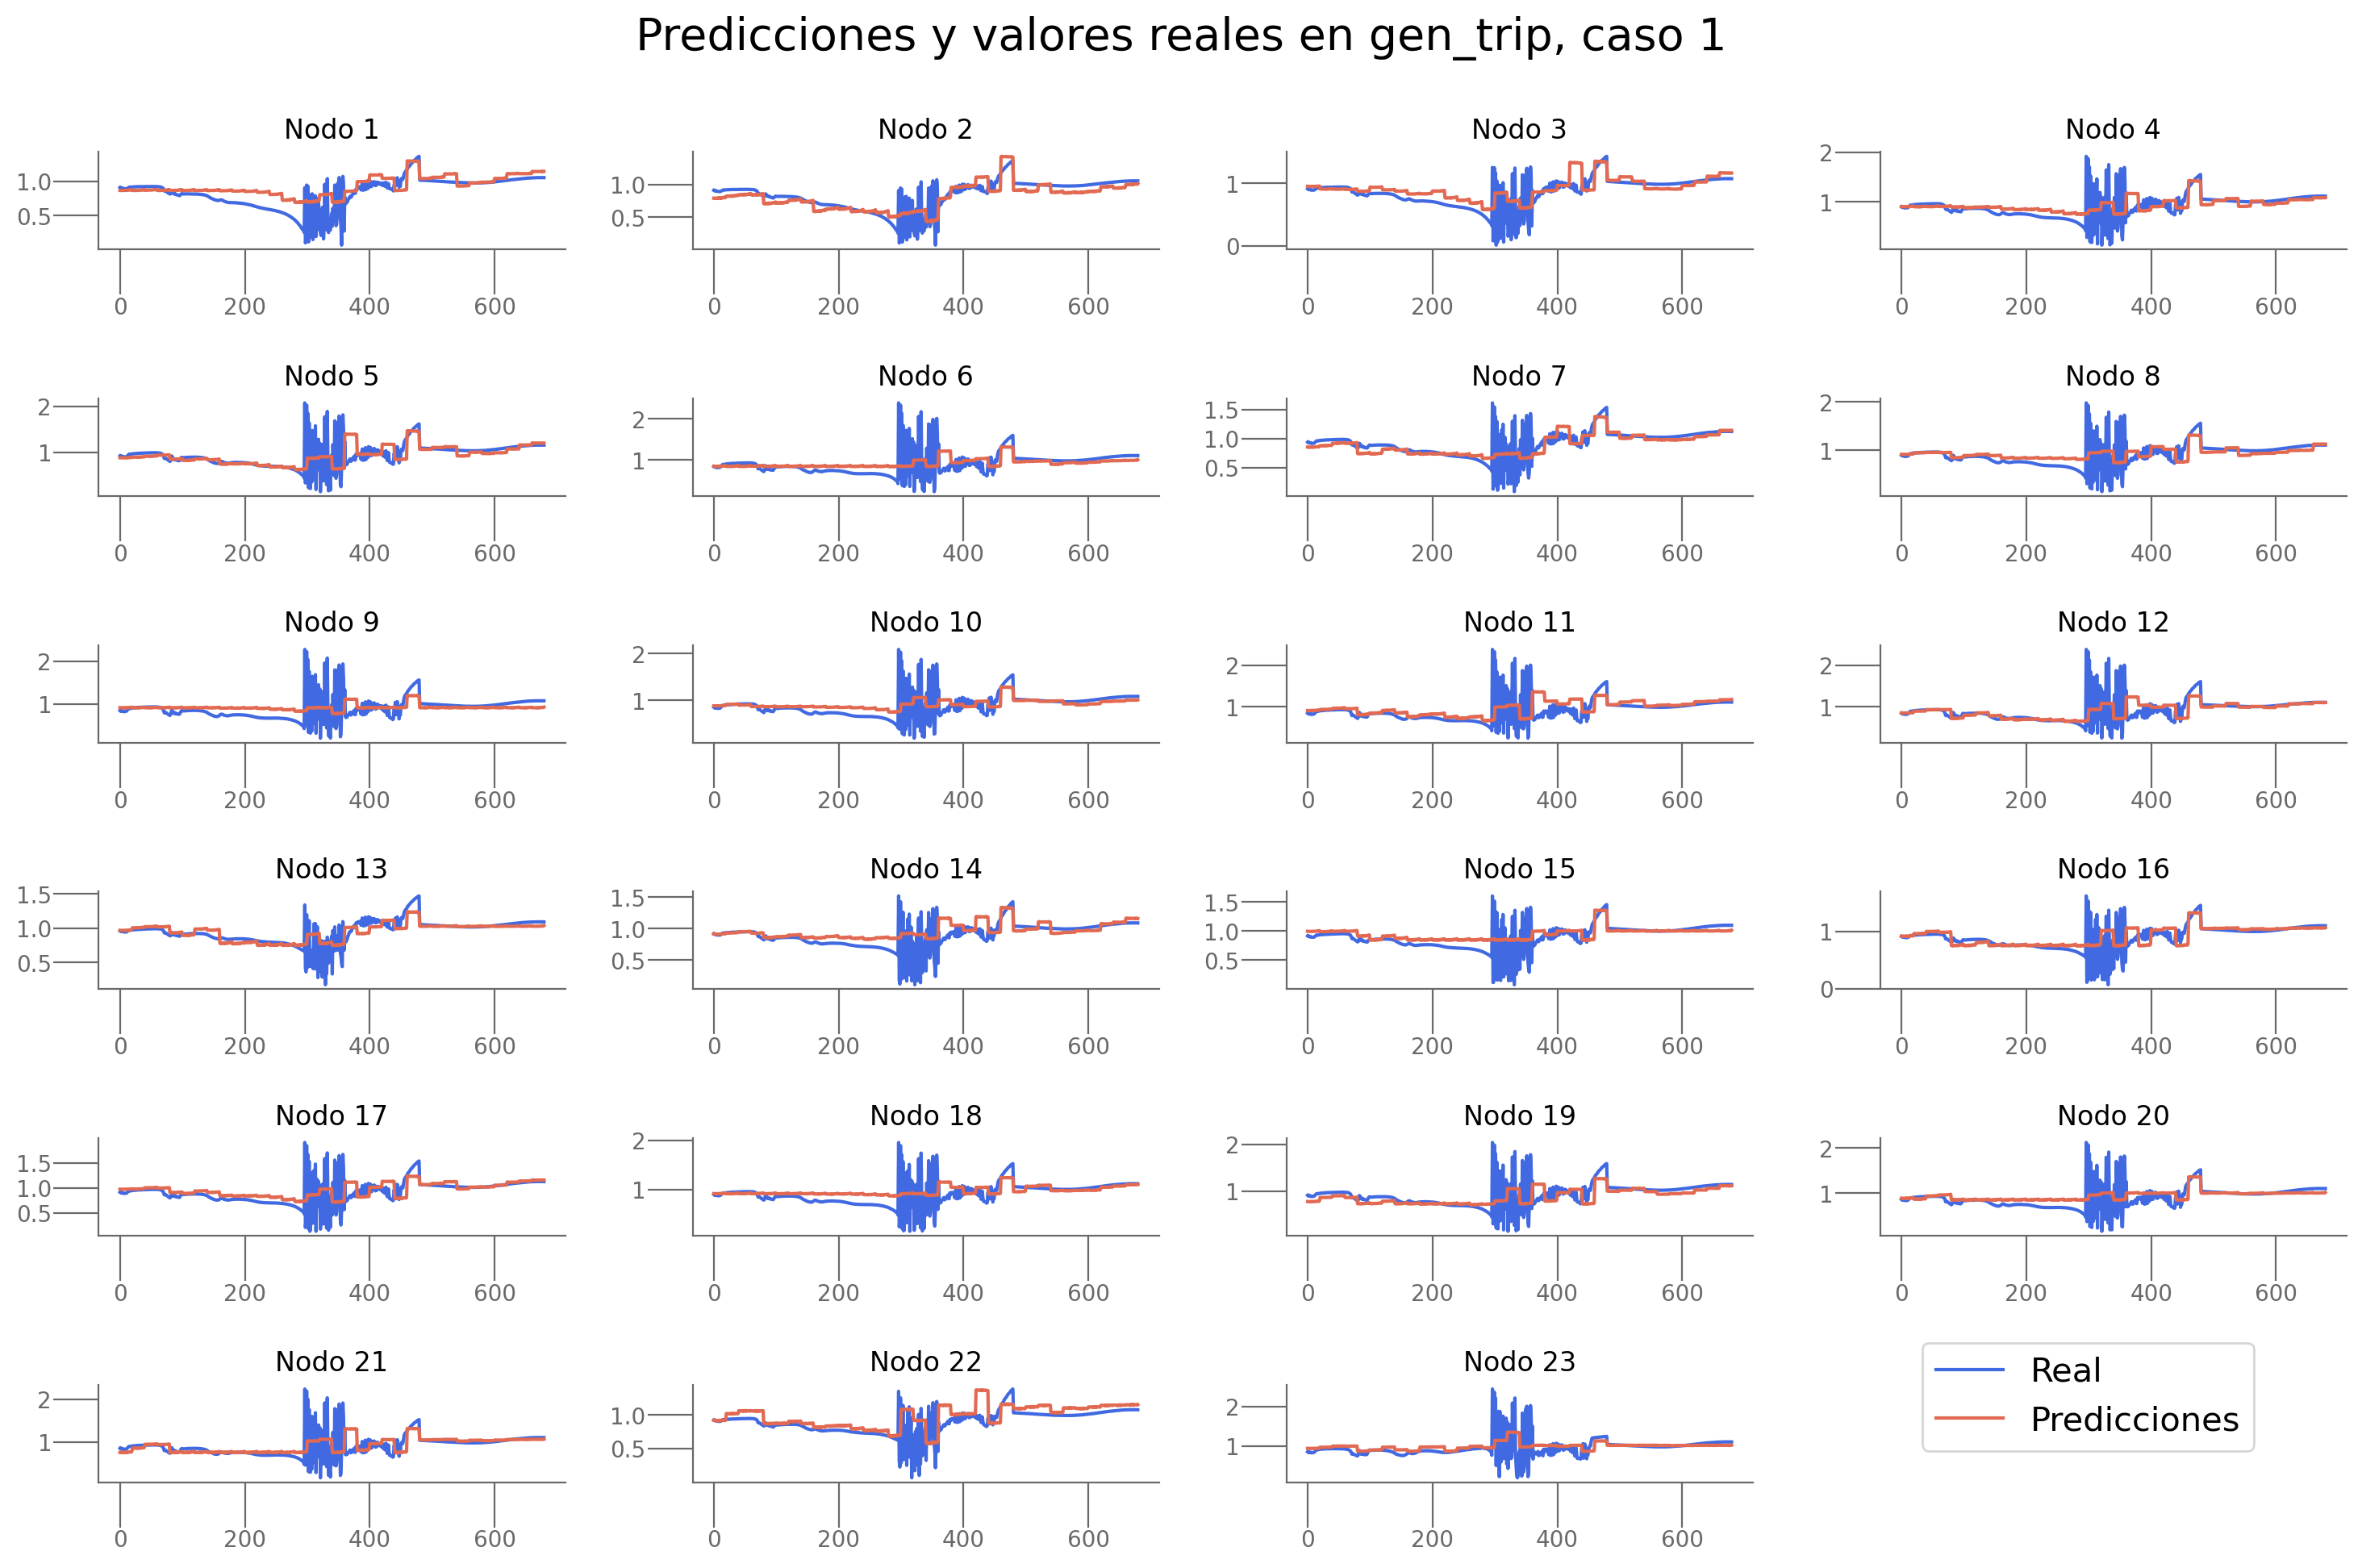

In [14]:
_,_,_, predictions_gt_ajuste,real_gt_ajuste = trainer_gt.test()
plot_predictions(predictions_gt_ajuste, real_gt_ajuste, n_target, 1, n_div_gt, problem_gt)

In [15]:
trainer_gt.save_model(path_save_experiment=path_save_experiment_gt, params = params_gt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1     MPNN_LSTM                {'hidden_size': 16, 'dropout': 0.2}   
2  LSTM_NOBATCH                                                NaN   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4     EvolveGCN                                                NaN   
5         DCRNN                                     {'hidden': 10}   
6        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
7        MSTGCN                                                NaN   
8         AGCRN            {'hidden': 10, 'K': 10, 'embedding': 3}   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.007638   0.204209   
1    ./results/gen_trip/ajustes/MPNNLSTM_results.csv  0.045889 -18.247558   
2   

### Bus trip

In [16]:
problem_bt = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [17]:

n_div_bt = loader.div
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]
embedding_dim =5

#### Sencilla 

In [56]:
model_bt = AGCRNModel(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="AGCRN")
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model_bt.to(device)
trainer_bt = TrainerAGCRN(model_bt, dataset_bt,device, f"./results/{problem_bt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_bt.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 405
DataLoader for val set:
Number of batches: 87
DataLoader for test set:
Number of batches: 86

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1393 | Eval Loss: 0.0412 | Eval R2: 0.2645 | 
Epoch 2/30 | Train Loss: 0.0239 | Eval Loss: 0.0210 | Eval R2: 0.5995 | 
Epoch 3/30 | Train Loss: 0.0163 | Eval Loss: 0.0157 | Eval R2: 0.6998 | 
Epoch 4/30 | Train Loss: 0.0134 | Eval Loss: 0.0138 | Eval R2: 0.7324 | 
Epoch 5/30 | Train Loss: 0.0117 | Eval Loss: 0.0133 | Eval R2: 0.7398 | 
Epoch 6/30 | Train Loss: 0.0108 | Eval Loss: 0.0128 | Eval R2: 0.7494 | 
Epoch 7/30 | Train Loss: 0.0102 | Eval Loss: 0.0128 | Eval R2: 0.7494 | 
Epoch 8/30 | Train Loss: 0.0098 | Eval Loss: 0.0130 | Eval R2: 0.7409 | 
Epoch 9/30 | Train Loss: 0.0094 | Eval Loss

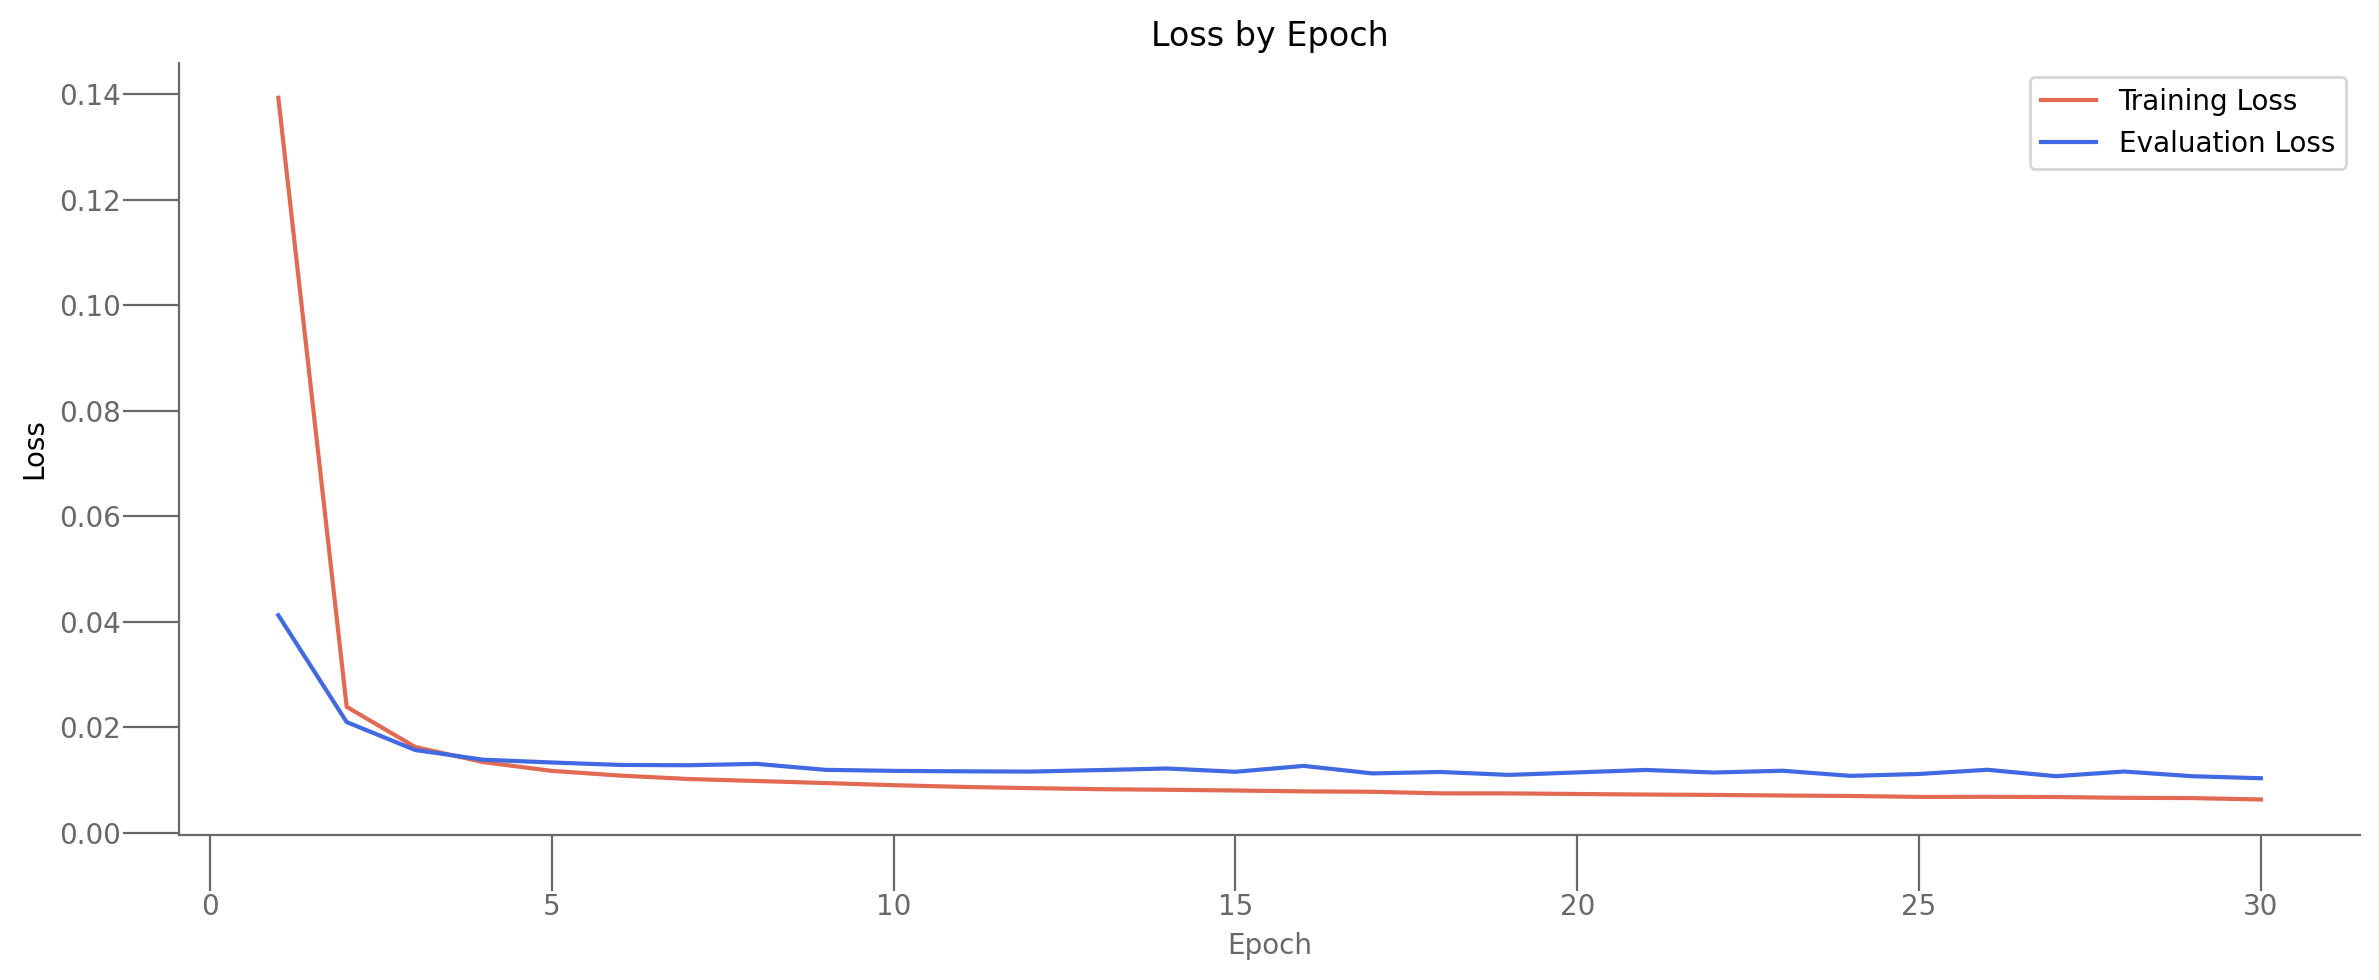


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.010044, test r2score 0.827705


In [57]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bt, real_bt = trainer_bt.test()



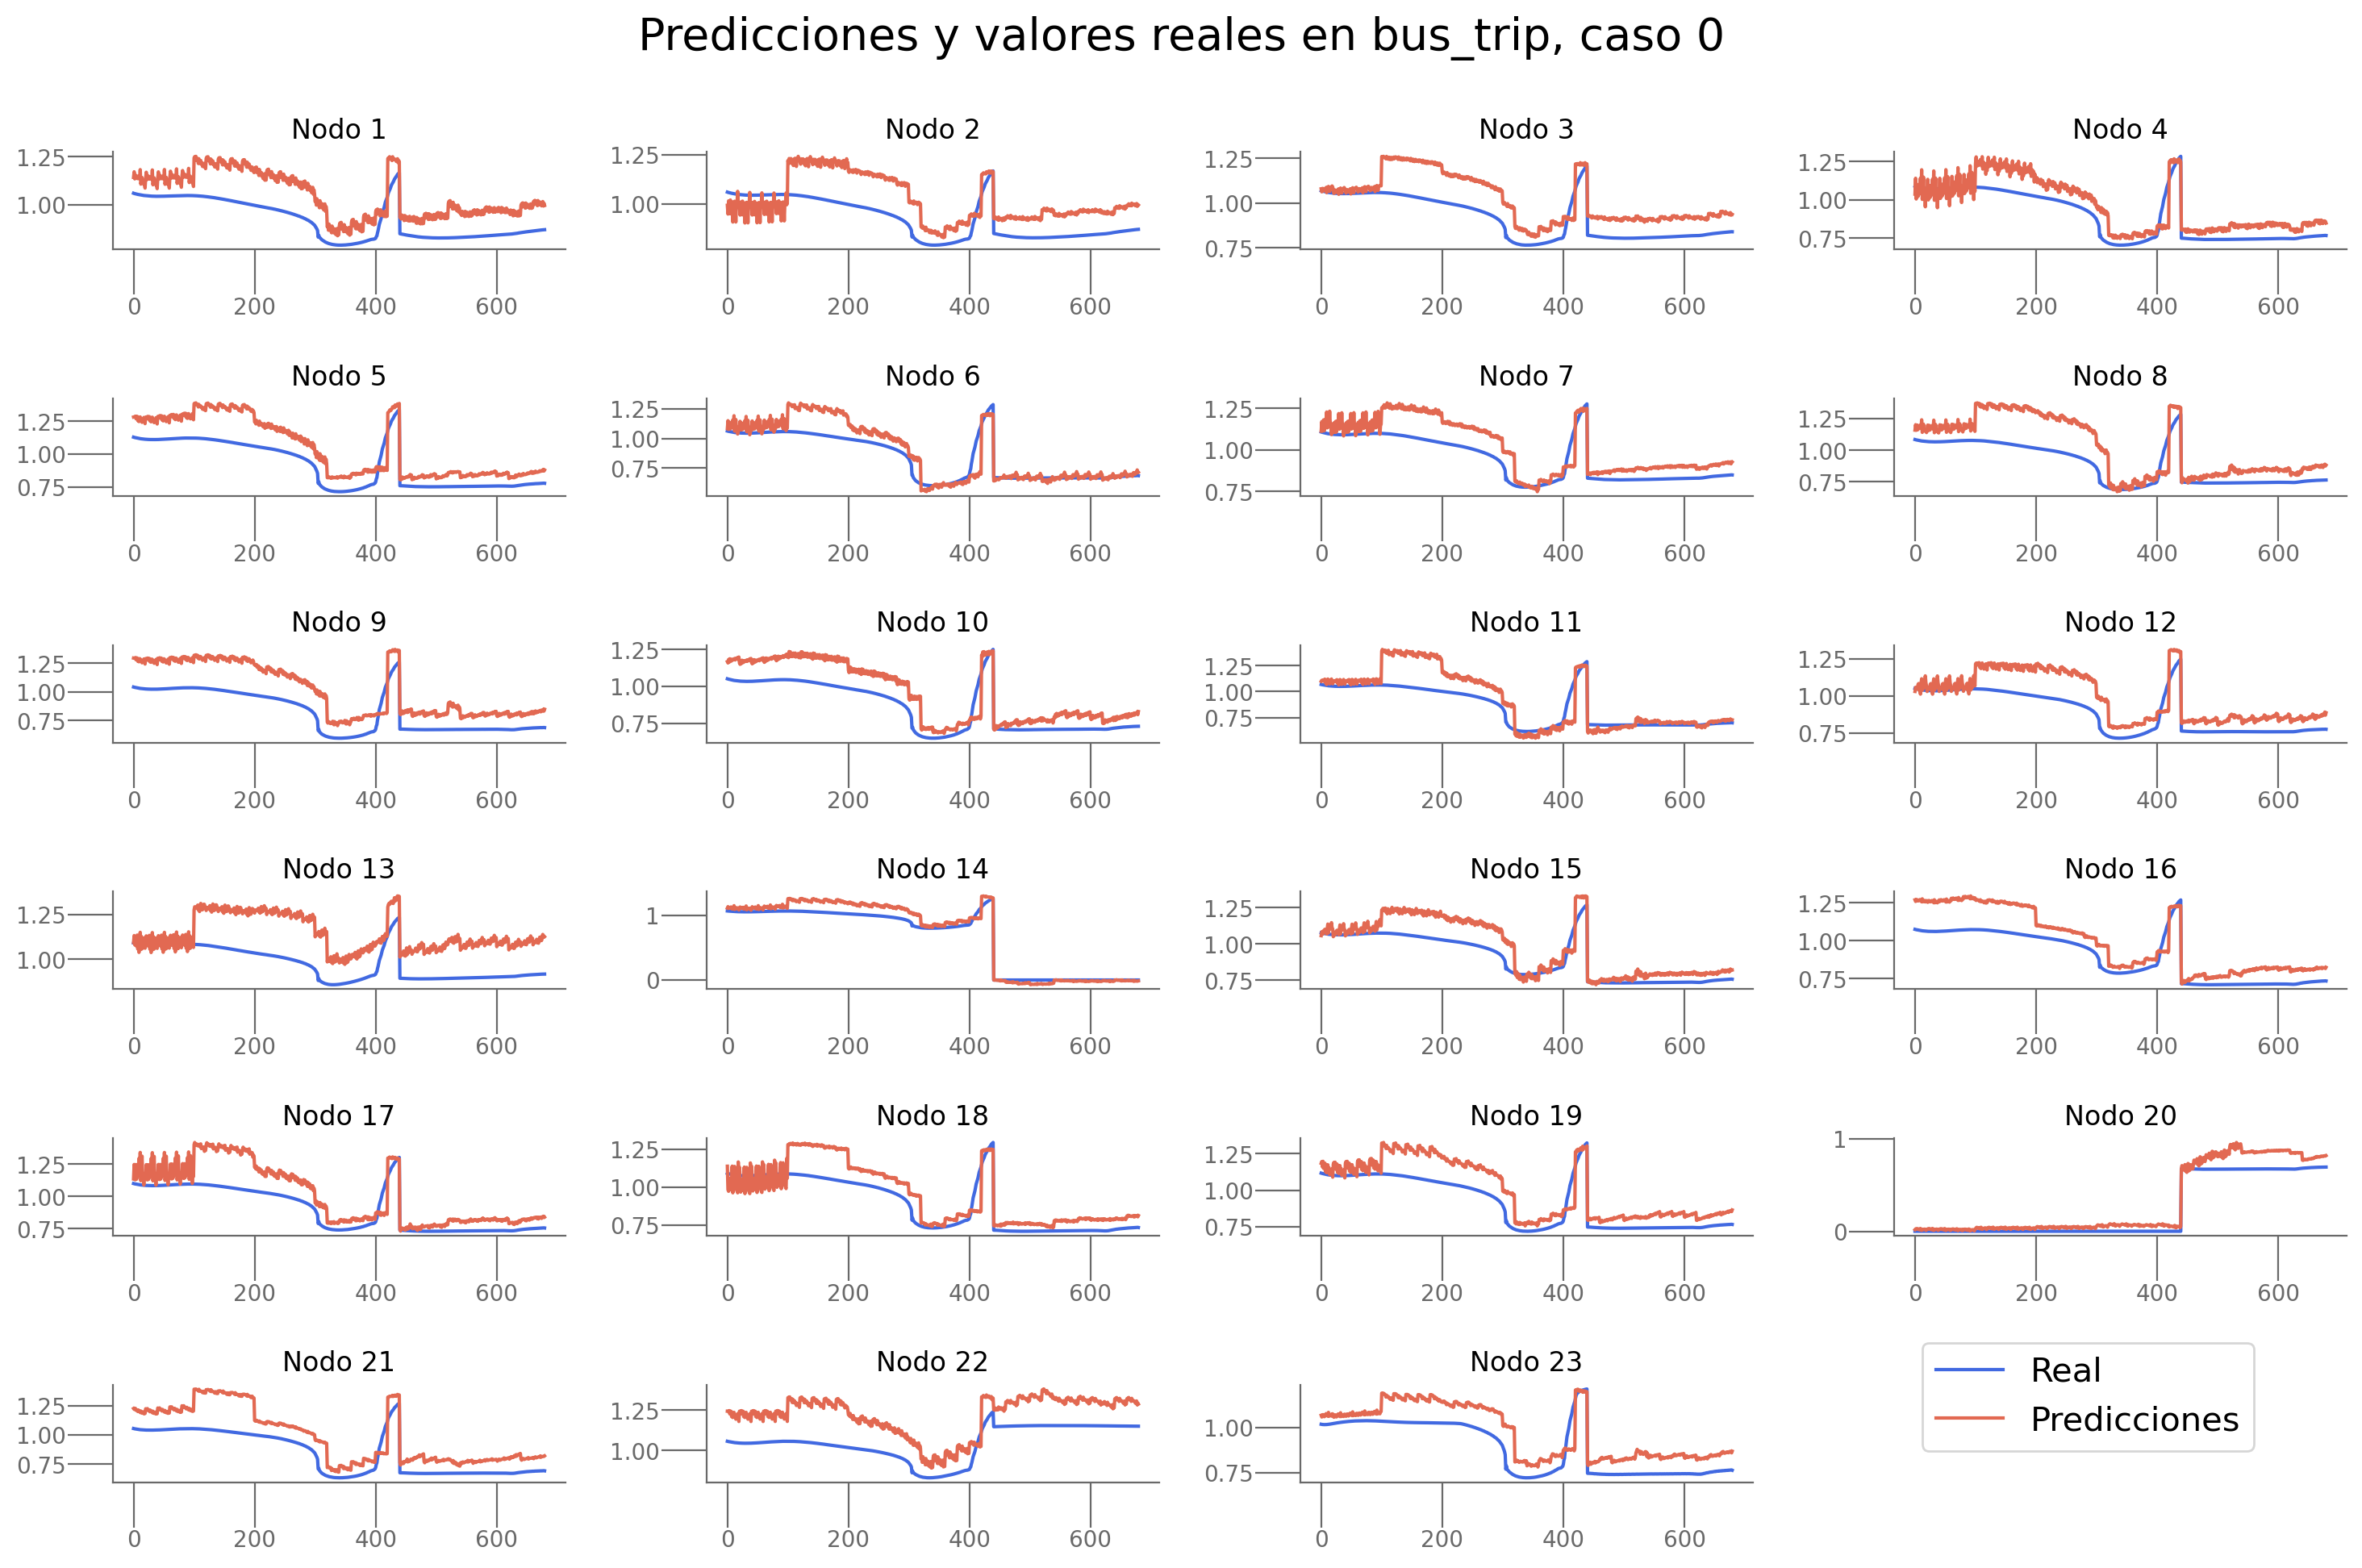

In [58]:
plot_predictions(predictions_bt, real_bt, n_target, 0, n_div_bt, problem_bt)

#### Ajuste de parámetros

In [18]:

trainer_bt,params_bt, resultados_final_bt, resultados_bt = entrenar_y_evaluar_modelos(param_grid, dataset_bt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bt)

  0%|          | 0/36 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 405
DataLoader for val set:
Number of batches: 87
DataLoader for test set:
Number of batches: 86

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.5059 | Eval Loss: 0.2592 | Eval R2: -3.5289 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.1996 | Eval Loss: 0.1686 | Eval R2: -1.9026 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.1428 | Eval Loss: 0.1246 | Eval R2: -1.1532 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.1143 | Eval Loss: 0.1093 | Eval R2: -0.8772 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.1029 | Eval Loss: 0.1028 | Eval R2: -0.7645 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.0955 | Eval Loss: 0.0909 | Eval R2: -0.5397 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.0880 | Eval Loss: 0.0791 | Eval R2: -0.3537 | LR: 0.0010 | 
Epoch 8/30 | Train

  3%|▎         | 1/36 [03:15<1:54:04, 195.55s/it]

preds:  (5, 23, 20)
test loss: 0.052769, test R2 score: 0.024200
Parámetros:  3 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 3, 'Loss_final': 0.05477423965930939, 'R2_eval': 0.10731066018342972, 'Loss_eval': 0.050221677869558334, 'R2_tst': 0.02419999956414783, 'Loss_tst': 0.05276922136545181, 'Loss_nodes': [0.12920232117176056, 0.02972584217786789, 0.06115763261914253, 0.026121946051716805, 0.02531421184539795, 0.03284740447998047, 0.020946431905031204, 0.08964996784925461, 0.02725222148001194, 0.02755003236234188, 0.03042786940932274, 0.021050140261650085, 0.05497279390692711, 0.07734377682209015, 0.0800204798579216, 0.03193492814898491, 0.07268908619880676, 0.07736411690711975, 0.09001030027866364, 0.12312807887792587, 0.024695491418242455, 0.015951815992593765, 0.0443352572619915]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for tra

  6%|▌         | 2/36 [06:28<1:49:47, 193.74s/it]

preds:  (5, 23, 20)
test loss: 0.042316, test R2 score: 0.248901
Parámetros:  3 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 3, 'Loss_final': 0.04774685204029083, 'R2_eval': 0.2140539139509201, 'Loss_eval': 0.04375869780778885, 'R2_tst': 0.24890093004239344, 'Loss_tst': 0.04231550171971321, 'Loss_nodes': [0.04741792380809784, 0.01745065674185753, 0.030535345897078514, 0.0794503390789032, 0.03109128214418888, 0.048094071447849274, 0.03250961750745773, 0.052838653326034546, 0.058141887187957764, 0.045684222131967545, 0.03366273641586304, 0.026821613311767578, 0.021248070523142815, 0.04908280447125435, 0.0624363087117672, 0.01738807186484337, 0.06948813050985336, 0.032878462225198746, 0.0546133853495121, 0.07289450615644455, 0.037759795784950256, 0.020260082557797432, 0.031508561223745346]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for 

  8%|▊         | 3/36 [09:43<1:46:56, 194.43s/it]

preds:  (5, 23, 20)
test loss: 0.033388, test R2 score: 0.379074
Parámetros:  3 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 3, 'Loss_final': 0.030650164932012558, 'R2_eval': 0.38305285573005676, 'Loss_eval': 0.03234012424945831, 'R2_tst': 0.37907391472930724, 'Loss_tst': 0.03338771313428879, 'Loss_nodes': [0.022762356325984, 0.015753142535686493, 0.03791915997862816, 0.04068174213171005, 0.02603590488433838, 0.04450521990656853, 0.05369141325354576, 0.0355524867773056, 0.038069188594818115, 0.0338653028011322, 0.07566791027784348, 0.03951379284262657, 0.017241209745407104, 0.020175496116280556, 0.03554980084300041, 0.03129523992538452, 0.03879552707076073, 0.01594904623925686, 0.027544723823666573, 0.04238509759306908, 0.032811012119054794, 0.022561410441994667, 0.019591189920902252]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for tr

 11%|█         | 4/36 [14:45<2:06:21, 236.92s/it]

preds:  (5, 23, 20)
test loss: 0.040646, test R2 score: 0.310303
Parámetros:  3 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 3, 'Loss_final': 0.04291351139545441, 'R2_eval': 0.3307090401649475, 'Loss_eval': 0.03932853415608406, 'R2_tst': 0.31030273584172663, 'Loss_tst': 0.04064583033323288, 'Loss_nodes': [0.026515694335103035, 0.041047412902116776, 0.03575756773352623, 0.0409945547580719, 0.05333233252167702, 0.04577286168932915, 0.04857713729143143, 0.04173309728503227, 0.04166806861758232, 0.04315907135605812, 0.045960377901792526, 0.033498525619506836, 0.03530862182378769, 0.033675190061330795, 0.03889843076467514, 0.034107595682144165, 0.05520439147949219, 0.04755602777004242, 0.0471818707883358, 0.04489363729953766, 0.033167485147714615, 0.02856319397687912, 0.03828096762299538]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for tra

 14%|█▍        | 5/36 [19:39<2:13:07, 257.67s/it]

preds:  (5, 23, 20)
test loss: 0.087460, test R2 score: -0.603881
Parámetros:  3 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 3, 'Loss_final': 0.08717668056488037, 'R2_eval': -0.5031546950340271, 'Loss_eval': 0.08463813364505768, 'R2_tst': -0.6038805825167983, 'Loss_tst': 0.08746020495891571, 'Loss_nodes': [0.1728670597076416, 0.05894068628549576, 0.04237089306116104, 0.08778563886880875, 0.10684022307395935, 0.0701102465391159, 0.057152602821588516, 0.13970524072647095, 0.0370352640748024, 0.13443632423877716, 0.08716271072626114, 0.046234384179115295, 0.021550312638282776, 0.12292652577161789, 0.12075763195753098, 0.03042975440621376, 0.1356685608625412, 0.032908372581005096, 0.14437656104564667, 0.18425999581813812, 0.0386679507791996, 0.03055913746356964, 0.1088385134935379]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train se

 17%|█▋        | 6/36 [24:37<2:15:36, 271.20s/it]

preds:  (5, 23, 20)
test loss: 0.043891, test R2 score: 0.192041
Parámetros:  3 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 3, 'Loss_final': 0.04821375757455826, 'R2_eval': 0.3539329171180725, 'Loss_eval': 0.037349339574575424, 'R2_tst': 0.19204087973873146, 'Loss_tst': 0.04389073699712753, 'Loss_nodes': [0.024033643305301666, 0.020186597481369972, 0.056094978004693985, 0.13419729471206665, 0.030636612325906754, 0.030491147190332413, 0.03538285940885544, 0.034578900784254074, 0.07296223193407059, 0.03693736344575882, 0.03790193796157837, 0.05391555652022362, 0.016429666429758072, 0.02147984318435192, 0.02810419164597988, 0.022708848118782043, 0.04238440468907356, 0.021922076120972633, 0.03443628549575806, 0.1723879724740982, 0.026993144303560257, 0.018543196842074394, 0.03677811473608017]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader f

 19%|█▉        | 7/36 [34:02<2:57:32, 367.32s/it]

preds:  (5, 23, 20)
test loss: 0.070080, test R2 score: -0.277588
Parámetros:  3 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 3, 'Loss_final': 0.07137473672628403, 'R2_eval': -0.2810611426830292, 'Loss_eval': 0.07140550762414932, 'R2_tst': -0.2775884625629784, 'Loss_tst': 0.07007964700460434, 'Loss_nodes': [0.07001633197069168, 0.05892366170883179, 0.05499393865466118, 0.07539936155080795, 0.04339897632598877, 0.07406653463840485, 0.03265652433037758, 0.13779056072235107, 0.04937579482793808, 0.06879841536283493, 0.04952053725719452, 0.038724884390830994, 0.036194633692502975, 0.05694148689508438, 0.06304527819156647, 0.03575790300965309, 0.19539371132850647, 0.0605558305978775, 0.14437972009181976, 0.083867147564888, 0.044781215488910675, 0.02835799939930439, 0.10889144241809845]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train 

 22%|██▏       | 8/36 [42:57<3:16:21, 420.76s/it]

preds:  (5, 23, 20)
test loss: 0.079705, test R2 score: -0.464656
Parámetros:  3 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 3, 'Loss_final': 0.08665753901004791, 'R2_eval': -0.4863797426223755, 'Loss_eval': 0.08327833563089371, 'R2_tst': -0.4646562924834551, 'Loss_tst': 0.07970483601093292, 'Loss_nodes': [0.0522640198469162, 0.060563113540410995, 0.05595840513706207, 0.1390625536441803, 0.07065438479185104, 0.0671122595667839, 0.05774741992354393, 0.1369795799255371, 0.07446124404668808, 0.13332915306091309, 0.06338262557983398, 0.05111642926931381, 0.03564658388495445, 0.04759305715560913, 0.055682774633169174, 0.04827795550227165, 0.19714809954166412, 0.06017247587442398, 0.14492760598659515, 0.07690981775522232, 0.06255324184894562, 0.03370554745197296, 0.10796297341585159]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train se

 25%|██▌       | 9/36 [51:30<3:22:19, 449.60s/it]

preds:  (5, 23, 20)
test loss: 0.071958, test R2 score: -0.316613
Parámetros:  3 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 3, 'Loss_final': 0.07473140954971313, 'R2_eval': -0.0933351069688797, 'Loss_eval': 0.06286348402500153, 'R2_tst': -0.3166129612563915, 'Loss_tst': 0.07195766270160675, 'Loss_nodes': [0.15533795952796936, 0.035292528569698334, 0.056297436356544495, 0.13411961495876312, 0.04769620671868324, 0.039967671036720276, 0.06309233605861664, 0.07217789441347122, 0.13223415613174438, 0.06723932176828384, 0.05601368471980095, 0.054212912917137146, 0.025187844410538673, 0.0596792958676815, 0.0684792771935463, 0.04594278335571289, 0.12304916232824326, 0.03443729877471924, 0.08184844255447388, 0.17201988399028778, 0.043316472321748734, 0.021138133481144905, 0.06624595075845718]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for t

 28%|██▊       | 10/36 [55:14<2:44:40, 380.03s/it]

Parámetros:  5 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 5, 'Loss_final': 0.020361710339784622, 'R2_eval': 0.4560459554195404, 'Loss_eval': 0.02791263908147812, 'R2_tst': 0.5109092697801795, 'Loss_tst': 0.02634185180068016, 'Loss_nodes': [0.010545376688241959, 0.00998084619641304, 0.03388143330812454, 0.038549479097127914, 0.01805107481777668, 0.015454798005521297, 0.012446689419448376, 0.026987899094820023, 0.030788535252213478, 0.03235357999801636, 0.021531593054533005, 0.011169472709298134, 0.024804705753922462, 0.044597283005714417, 0.03263881430029869, 0.01767253503203392, 0.04881812632083893, 0.04869498312473297, 0.03487667068839073, 0.016708480194211006, 0.03223828971385956, 0.01824328303337097, 0.024828625842928886]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 405
DataLoader for val set:
Num

 31%|███       | 11/36 [58:59<2:18:29, 332.40s/it]

preds:  (5, 23, 20)
test loss: 0.016248, test R2 score: 0.722423
Parámetros:  5 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 5, 'Loss_final': 0.017379093915224075, 'R2_eval': 0.6678974032402039, 'Loss_eval': 0.017513668164610863, 'R2_tst': 0.7224233891848937, 'Loss_tst': 0.01624772883951664, 'Loss_nodes': [0.010281618684530258, 0.010245793499052525, 0.01908276602625847, 0.0213659405708313, 0.025953544303774834, 0.017989611253142357, 0.014562921598553658, 0.012776557356119156, 0.02454427443444729, 0.014726349152624607, 0.01883576810359955, 0.009379599243402481, 0.013584394939243793, 0.015369839034974575, 0.019557874649763107, 0.008772830478847027, 0.01551294606178999, 0.02068963088095188, 0.01406545378267765, 0.02294621430337429, 0.01179634127765894, 0.011184918694198132, 0.02047259733080864]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader

 33%|███▎      | 12/36 [1:02:33<1:58:33, 296.40s/it]

preds:  (5, 23, 20)
test loss: 0.030513, test R2 score: 0.470973
Parámetros:  5 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 5, 'Loss_final': 0.02107248269021511, 'R2_eval': 0.4289129972457886, 'Loss_eval': 0.03091292828321457, 'R2_tst': 0.4709730638801279, 'Loss_tst': 0.03051341325044632, 'Loss_nodes': [0.01008074264973402, 0.020887501537799835, 0.026489462703466415, 0.03312195837497711, 0.02391764149069786, 0.02296750433743, 0.024813083931803703, 0.020152874290943146, 0.03283822536468506, 0.10841980576515198, 0.03987729921936989, 0.0394420251250267, 0.011481988243758678, 0.012031144462525845, 0.016050973907113075, 0.01640242524445057, 0.02689359150826931, 0.017565105110406876, 0.017217813059687614, 0.03431083261966705, 0.020921023562550545, 0.011852103285491467, 0.11407343298196793]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for tr

 36%|███▌      | 13/36 [1:08:13<1:58:38, 309.50s/it]

preds:  (5, 23, 20)
test loss: 0.032032, test R2 score: 0.443891
Parámetros:  5 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 5, 'Loss_final': 0.031496331095695496, 'R2_eval': 0.41705143451690674, 'Loss_eval': 0.03284979239106178, 'R2_tst': 0.4438910839042292, 'Loss_tst': 0.03203154727816582, 'Loss_nodes': [0.017948327586054802, 0.017156735062599182, 0.03275766596198082, 0.04472219944000244, 0.03718135878443718, 0.027735771611332893, 0.06847872585058212, 0.022952701896429062, 0.048667632043361664, 0.02488945797085762, 0.02906426228582859, 0.02113141492009163, 0.03533536195755005, 0.02655685506761074, 0.028670089319348335, 0.012177327647805214, 0.04572742059826851, 0.04454798251390457, 0.02352878451347351, 0.026418326422572136, 0.03662467002868652, 0.02595796063542366, 0.03849458694458008]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for

 39%|███▉      | 14/36 [1:13:40<1:55:26, 314.84s/it]

preds:  (5, 23, 20)
test loss: 0.062436, test R2 score: -0.066898
Parámetros:  5 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 5, 'Loss_final': 0.04712830111384392, 'R2_eval': -0.11507874727249146, 'Loss_eval': 0.06383170932531357, 'R2_tst': -0.06689792687692855, 'Loss_tst': 0.06243574991822243, 'Loss_nodes': [0.04035666212439537, 0.03630176559090614, 0.12689745426177979, 0.05013270676136017, 0.08900207281112671, 0.07729148119688034, 0.04413359612226486, 0.044067107141017914, 0.03262675553560257, 0.03458837419748306, 0.0578061081469059, 0.062033507972955704, 0.029672589153051376, 0.03994429484009743, 0.1433895081281662, 0.08905362337827682, 0.07666333764791489, 0.028133036568760872, 0.0635639876127243, 0.0592648945748806, 0.11634921282529831, 0.06439819186925888, 0.030351921916007996]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for tra

 42%|████▏     | 15/36 [1:19:08<1:51:34, 318.77s/it]

preds:  (5, 23, 20)
test loss: 0.092776, test R2 score: -0.653456
Parámetros:  5 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 5, 'Loss_final': 0.053222429007291794, 'R2_eval': -0.5098618865013123, 'Loss_eval': 0.08630923926830292, 'R2_tst': -0.6534561440007788, 'Loss_tst': 0.09277568012475967, 'Loss_nodes': [0.02370942384004593, 0.05000961571931839, 0.04733173921704292, 0.06318236142396927, 0.049823712557554245, 0.04547957330942154, 0.052703969180583954, 0.04599898308515549, 0.06858178228139877, 0.04189221188426018, 0.4373268783092499, 0.04820484295487404, 0.02697431482374668, 0.02896677330136299, 0.03347047418355942, 0.6690982580184937, 0.06520145386457443, 0.06618953496217728, 0.06277499347925186, 0.05924205482006073, 0.03843524307012558, 0.020518342033028603, 0.08872416615486145]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for trai

 44%|████▍     | 16/36 [1:29:09<2:14:36, 403.82s/it]

preds:  (5, 23, 20)
test loss: 0.079963, test R2 score: -0.470691
Parámetros:  5 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 5, 'Loss_final': 0.0794772282242775, 'R2_eval': -0.4118049442768097, 'Loss_eval': 0.07890043407678604, 'R2_tst': -0.4706909644595292, 'Loss_tst': 0.07996276766061783, 'Loss_nodes': [0.1283540278673172, 0.03927227109670639, 0.043565645813941956, 0.14340263605117798, 0.06545441597700119, 0.03740004450082779, 0.0516510009765625, 0.1179426982998848, 0.08442392200231552, 0.12699531018733978, 0.0436038076877594, 0.042967021465301514, 0.03909778967499733, 0.0794382244348526, 0.0819237008690834, 0.08287341147661209, 0.12786129117012024, 0.06013792008161545, 0.13013292849063873, 0.13029560446739197, 0.0892852246761322, 0.02171197533607483, 0.07135292887687683]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:
N

 47%|████▋     | 17/36 [1:38:19<2:21:50, 447.94s/it]

preds:  (5, 23, 20)
test loss: 0.083488, test R2 score: -0.543147
Parámetros:  5 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 5, 'Loss_final': 0.08734571933746338, 'R2_eval': -0.43180587887763977, 'Loss_eval': 0.08080695569515228, 'R2_tst': -0.5431473379744999, 'Loss_tst': 0.08348798006772995, 'Loss_nodes': [0.15464963018894196, 0.038494937121868134, 0.03133825212717056, 0.13506174087524414, 0.04165717214345932, 0.036728132516145706, 0.058831021189689636, 0.13231469690799713, 0.07647679001092911, 0.12519682943820953, 0.03180975094437599, 0.05114537104964256, 0.049006782472133636, 0.07272306829690933, 0.08763506263494492, 0.04909791052341461, 0.1835310459136963, 0.0750463679432869, 0.15661446750164032, 0.1328021138906479, 0.06255855411291122, 0.034996189177036285, 0.1025075912475586]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for trai

 50%|█████     | 18/36 [1:47:27<2:23:23, 477.98s/it]

preds:  (5, 23, 20)
test loss: 0.082691, test R2 score: -0.509514
Parámetros:  5 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 5, 'Loss_final': 0.08795929700136185, 'R2_eval': -0.45654457807540894, 'Loss_eval': 0.08248955011367798, 'R2_tst': -0.5095143795548368, 'Loss_tst': 0.08269104361534119, 'Loss_nodes': [0.15019913017749786, 0.06730575859546661, 0.04649673029780388, 0.09354166686534882, 0.07042548060417175, 0.07331737130880356, 0.0526447631418705, 0.14187413454055786, 0.06397352367639542, 0.09971766918897629, 0.05154429376125336, 0.04719480127096176, 0.0348391979932785, 0.11299905180931091, 0.11998987197875977, 0.04478142037987709, 0.12405652552843094, 0.059719767421483994, 0.14648060500621796, 0.11419100314378738, 0.07286816090345383, 0.03179848566651344, 0.08193454891443253]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train 

 53%|█████▎    | 19/36 [1:51:22<1:54:42, 404.86s/it]

preds:  (5, 23, 20)
test loss: 0.022985, test R2 score: 0.548872
Parámetros:  10 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 10, 'Loss_final': 0.016275547444820404, 'R2_eval': 0.6367257833480835, 'Loss_eval': 0.018628360703587532, 'R2_tst': 0.5488716710126206, 'Loss_tst': 0.0229853093624115, 'Loss_nodes': [0.013833505101501942, 0.0153236398473382, 0.022887030616402626, 0.04172944650053978, 0.023482460528612137, 0.018629493191838264, 0.011181408539414406, 0.01806298829615116, 0.04009062796831131, 0.03281846642494202, 0.026196597144007683, 0.01344231516122818, 0.023617779836058617, 0.011474967002868652, 0.014258971437811852, 0.012616944499313831, 0.0387149453163147, 0.013233920559287071, 0.03209201246500015, 0.025451818481087685, 0.035843949764966965, 0.016092559322714806, 0.027586249634623528]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoad

 56%|█████▌    | 20/36 [1:55:14<1:34:08, 353.06s/it]

preds:  (5, 23, 20)
test loss: 0.015579, test R2 score: 0.723703
Parámetros:  10 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 10, 'Loss_final': 0.015517828054726124, 'R2_eval': 0.6653174757957458, 'Loss_eval': 0.016887057572603226, 'R2_tst': 0.7237027798279598, 'Loss_tst': 0.01557902991771698, 'Loss_nodes': [0.00819458905607462, 0.010477088391780853, 0.011093681678175926, 0.017639754340052605, 0.016039250418543816, 0.01811468042433262, 0.017808467149734497, 0.016673166304826736, 0.021358979865908623, 0.01791125349700451, 0.022584302350878716, 0.009355345740914345, 0.008699553087353706, 0.011882105842232704, 0.013673365116119385, 0.017342768609523773, 0.016910750418901443, 0.015719309449195862, 0.01626821979880333, 0.020521001890301704, 0.024100301787257195, 0.010922408662736416, 0.015027361921966076]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

D

 58%|█████▊    | 21/36 [1:59:26<1:20:40, 322.69s/it]

preds:  (5, 23, 20)
test loss: 0.021815, test R2 score: 0.573437
Parámetros:  10 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 10, 'Loss_final': 0.01797843910753727, 'R2_eval': 0.4912923276424408, 'Loss_eval': 0.024627814069390297, 'R2_tst': 0.5734366686881422, 'Loss_tst': 0.021814722567796707, 'Loss_nodes': [0.02103557251393795, 0.038900092244148254, 0.015979280695319176, 0.019031604751944542, 0.025105027481913567, 0.021786730736494064, 0.013786401599645615, 0.022321667522192, 0.020977992564439774, 0.020776787772774696, 0.026865852996706963, 0.019002635031938553, 0.013912711292505264, 0.010568276047706604, 0.018717031925916672, 0.041293997317552567, 0.02897627092897892, 0.017861001193523407, 0.023932643234729767, 0.02139963023364544, 0.024089505895972252, 0.013817557133734226, 0.021600302308797836]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

Dat

 61%|██████    | 22/36 [2:08:19<1:30:01, 385.79s/it]

preds:  (5, 23, 20)
test loss: 0.029454, test R2 score: 0.504912
Parámetros:  10 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 10, 'Loss_final': 0.023155566304922104, 'R2_eval': 0.49468594789505005, 'Loss_eval': 0.029027694836258888, 'R2_tst': 0.5049122449569883, 'Loss_tst': 0.029454128816723824, 'Loss_nodes': [0.022189613431692123, 0.04424900934100151, 0.017588989809155464, 0.035680171102285385, 0.01924612559378147, 0.05209643393754959, 0.019517993554472923, 0.05358423292636871, 0.030085664242506027, 0.03556526452302933, 0.022791700437664986, 0.015892086550593376, 0.024929488077759743, 0.02269865572452545, 0.02451123110949993, 0.03878824785351753, 0.02472180314362049, 0.022570036351680756, 0.04842790216207504, 0.028162958100438118, 0.035055506974458694, 0.015813928097486496, 0.02327786199748516]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLo

 64%|██████▍   | 23/36 [2:16:57<1:32:12, 425.56s/it]

preds:  (5, 23, 20)
test loss: 0.024533, test R2 score: 0.571688
Parámetros:  10 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 10, 'Loss_final': 0.026036327704787254, 'R2_eval': 0.40589308738708496, 'Loss_eval': 0.03137626871466637, 'R2_tst': 0.5716877364016836, 'Loss_tst': 0.02453305758535862, 'Loss_nodes': [0.021092718467116356, 0.017594238743185997, 0.021737243980169296, 0.025571143254637718, 0.022299017757177353, 0.022464528679847717, 0.016949111595749855, 0.022133050486445427, 0.039715155959129333, 0.024248816072940826, 0.038676243275403976, 0.013973069377243519, 0.031295303255319595, 0.02019355818629265, 0.025423957034945488, 0.02023429423570633, 0.028317172080278397, 0.03486800938844681, 0.025022661313414574, 0.026043199002742767, 0.030173886567354202, 0.016974586993455887, 0.01925937458872795]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

D

 67%|██████▋   | 24/36 [2:23:29<1:23:05, 415.42s/it]

preds:  (5, 23, 20)
test loss: 0.030991, test R2 score: 0.420726
Parámetros:  10 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 10, 'Loss_final': 0.025740765035152435, 'R2_eval': 0.38618555665016174, 'Loss_eval': 0.03177819401025772, 'R2_tst': 0.4207262349745303, 'Loss_tst': 0.030991047620773315, 'Loss_nodes': [0.02074144408106804, 0.07449578493833542, 0.022559132426977158, 0.02408779412508011, 0.02915537916123867, 0.03760248422622681, 0.03639892861247063, 0.037276409566402435, 0.04475832358002663, 0.03105546347796917, 0.0350445955991745, 0.026372279971837997, 0.024848222732543945, 0.016249144449830055, 0.025121014565229416, 0.025157935917377472, 0.03452564403414726, 0.0406319722533226, 0.02353864721953869, 0.022571368142962456, 0.03130333870649338, 0.020801115781068802, 0.028497617691755295]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader 

 69%|██████▉   | 25/36 [2:35:43<1:33:42, 511.10s/it]

preds:  (5, 23, 20)
test loss: 0.036933, test R2 score: 0.363355
Parámetros:  10 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 10, 'Loss_final': 0.03746773675084114, 'R2_eval': 0.25968438386917114, 'Loss_eval': 0.04009218513965607, 'R2_tst': 0.3633550042191139, 'Loss_tst': 0.036932896822690964, 'Loss_nodes': [0.024815350770950317, 0.016794558614492416, 0.07561163604259491, 0.05765432491898537, 0.06912212073802948, 0.02478213608264923, 0.04957897588610649, 0.04474905878305435, 0.023082779720425606, 0.02792864292860031, 0.032514289021492004, 0.02295496128499508, 0.020541582256555557, 0.020271776244044304, 0.023106593638658524, 0.015144824050366879, 0.06108414754271507, 0.031073670834302902, 0.04964819550514221, 0.036508359014987946, 0.04915705323219299, 0.014410106465220451, 0.05892152711749077]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoade

 72%|███████▏  | 26/36 [2:47:29<1:34:54, 569.49s/it]

preds:  (5, 23, 20)
test loss: 0.068087, test R2 score: -0.208276
Parámetros:  10 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 10, 'Loss_final': 0.06091718748211861, 'R2_eval': -0.12489991635084152, 'Loss_eval': 0.06358470022678375, 'R2_tst': -0.20827551203630976, 'Loss_tst': 0.0680868923664093, 'Loss_nodes': [0.09793546795845032, 0.044726692140102386, 0.06249737739562988, 0.0649341568350792, 0.0646803230047226, 0.041110362857580185, 0.055264946073293686, 0.07747187465429306, 0.059518370777368546, 0.071751169860363, 0.08701769262552261, 0.044791627675294876, 0.0580049566924572, 0.06106022372841835, 0.06846868991851807, 0.045477114617824554, 0.1696651428937912, 0.0557868629693985, 0.08338161557912827, 0.09730923175811768, 0.053626708686351776, 0.030869051814079285, 0.07064883410930634]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for tr

 75%|███████▌  | 27/36 [2:58:13<1:28:46, 591.81s/it]

preds:  (5, 23, 20)
test loss: 0.053322, test R2 score: 0.033008
Parámetros:  10 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 10, 'Loss_final': 0.054572876542806625, 'R2_eval': 0.08565275371074677, 'Loss_eval': 0.051191747188568115, 'R2_tst': 0.033007672178777904, 'Loss_tst': 0.05332242697477341, 'Loss_nodes': [0.02934647724032402, 0.044018760323524475, 0.053900957107543945, 0.08357417583465576, 0.03469627723097801, 0.026849713176488876, 0.05616765096783638, 0.036839358508586884, 0.07415655255317688, 0.07685576379299164, 0.05708317831158638, 0.051113687455654144, 0.01414942741394043, 0.02472717873752117, 0.026517193764448166, 0.048628684133291245, 0.20291399955749512, 0.03564956411719322, 0.04282929748296738, 0.09618079662322998, 0.02958202362060547, 0.01678646355867386, 0.06384868174791336]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader

 78%|███████▊  | 28/36 [3:02:41<1:05:56, 494.62s/it]

preds:  (5, 23, 20)
test loss: 0.015828, test R2 score: 0.710717
Parámetros:  15 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 15, 'Loss_final': 0.010807906277477741, 'R2_eval': 0.6458697319030762, 'Loss_eval': 0.016818096861243248, 'R2_tst': 0.7107166609211711, 'Loss_tst': 0.01582762971520424, 'Loss_nodes': [0.018481062725186348, 0.012865617871284485, 0.01252103503793478, 0.01574604958295822, 0.01667512021958828, 0.019688095897436142, 0.010263187810778618, 0.011806502938270569, 0.0175050999969244, 0.028057483956217766, 0.024243850260972977, 0.016468869522213936, 0.010819461196660995, 0.017770355567336082, 0.017374590039253235, 0.007852834649384022, 0.018185874447226524, 0.01062787789851427, 0.014024730771780014, 0.015216412954032421, 0.015178637579083443, 0.020639214664697647, 0.01202354021370411]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

Data

 81%|████████  | 29/36 [3:07:04<49:36, 425.28s/it]  

preds:  (5, 23, 20)
test loss: 0.015934, test R2 score: 0.717620
Parámetros:  15 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 15, 'Loss_final': 0.013637954369187355, 'R2_eval': 0.6139011383056641, 'Loss_eval': 0.019023708999156952, 'R2_tst': 0.7176197646378577, 'Loss_tst': 0.015933960676193237, 'Loss_nodes': [0.014470470137894154, 0.013325422070920467, 0.012480181641876698, 0.013315067626535892, 0.021641939878463745, 0.02287440001964569, 0.014377854764461517, 0.01804383471608162, 0.01473449170589447, 0.019158441573381424, 0.015835601836442947, 0.01087779738008976, 0.009666958823800087, 0.010728782042860985, 0.015335910953581333, 0.014589158818125725, 0.018474949523806572, 0.014774790033698082, 0.017785102128982544, 0.025742175057530403, 0.019079742953181267, 0.011536012403666973, 0.017631947994232178]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================



 83%|████████▎ | 30/36 [3:11:24<37:34, 375.68s/it]

preds:  (5, 23, 20)
test loss: 0.017024, test R2 score: 0.690887
Parámetros:  15 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 15, 'Loss_final': 0.013525806367397308, 'R2_eval': 0.48199203610420227, 'Loss_eval': 0.025362195447087288, 'R2_tst': 0.6908867046523405, 'Loss_tst': 0.017024487257003784, 'Loss_nodes': [0.01525262463837862, 0.023809216916561127, 0.016146685928106308, 0.013905717991292477, 0.025334132835268974, 0.017349112778902054, 0.01364570576697588, 0.01555563136935234, 0.022146424278616905, 0.015562701970338821, 0.019961733371019363, 0.022830244153738022, 0.012652922421693802, 0.009230146184563637, 0.015598427504301071, 0.009384446777403355, 0.020115137100219727, 0.013245886191725731, 0.019313883036375046, 0.020396191626787186, 0.026295362040400505, 0.010878268629312515, 0.012952578254044056]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

 86%|████████▌ | 31/36 [3:18:15<32:11, 386.30s/it]

preds:  (5, 23, 20)
test loss: 0.032285, test R2 score: 0.383095
Parámetros:  15 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 15, 'Loss_final': 0.020391302183270454, 'R2_eval': 0.36122533679008484, 'Loss_eval': 0.032481323927640915, 'R2_tst': 0.3830950955328855, 'Loss_tst': 0.03228513151407242, 'Loss_nodes': [0.017020583152770996, 0.1396910846233368, 0.021734412759542465, 0.029251230880618095, 0.024927379563450813, 0.15352120995521545, 0.024214772507548332, 0.03351221978664398, 0.031012125313282013, 0.023772675544023514, 0.01873454824090004, 0.013491644524037838, 0.01699751429259777, 0.008884918875992298, 0.00938068050891161, 0.01335354708135128, 0.022979678586125374, 0.020834000781178474, 0.03720132261514664, 0.014052257873117924, 0.024198338389396667, 0.01307629980146885, 0.030715595930814743]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLo

 89%|████████▉ | 32/36 [3:24:53<25:58, 389.69s/it]

preds:  (5, 23, 20)
test loss: 0.020577, test R2 score: 0.647040
Parámetros:  15 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 15, 'Loss_final': 0.02064024843275547, 'R2_eval': 0.5981969833374023, 'Loss_eval': 0.02154037542641163, 'R2_tst': 0.6470396150888117, 'Loss_tst': 0.020577454939484596, 'Loss_nodes': [0.012101659551262856, 0.030456440523266792, 0.03346625715494156, 0.01891997456550598, 0.023528020828962326, 0.020448921248316765, 0.0242817010730505, 0.02649695985019207, 0.023885453119874, 0.021023744717240334, 0.024589112028479576, 0.014041171409189701, 0.016136744990944862, 0.013205000199377537, 0.016075707972049713, 0.015788227319717407, 0.026307206600904465, 0.019770514219999313, 0.027733247727155685, 0.01887437514960766, 0.017545323818922043, 0.013065780512988567, 0.015539913438260555]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoa

 92%|█████████▏| 33/36 [3:31:27<19:32, 390.82s/it]

preds:  (5, 23, 20)
test loss: 0.019259, test R2 score: 0.666624
Parámetros:  15 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 15, 'Loss_final': 0.019447380676865578, 'R2_eval': 0.547295331954956, 'Loss_eval': 0.023190731182694435, 'R2_tst': 0.6666237393345585, 'Loss_tst': 0.01925870217382908, 'Loss_nodes': [0.009661005809903145, 0.017179161310195923, 0.012043748050928116, 0.0166319627314806, 0.02160825952887535, 0.021671485155820847, 0.021406061947345734, 0.02229814976453781, 0.023411564528942108, 0.018742596730589867, 0.02199653908610344, 0.015878034755587578, 0.011365549638867378, 0.009798653423786163, 0.016253333538770676, 0.037761788815259933, 0.03345726802945137, 0.019677424803376198, 0.021366460248827934, 0.019847888499498367, 0.01986485905945301, 0.010845924727618694, 0.020182471722364426]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataL

 94%|█████████▍| 34/36 [3:44:34<16:59, 509.96s/it]

preds:  (5, 23, 20)
test loss: 0.046648, test R2 score: 0.149063
Parámetros:  15 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 15, 'Loss_final': 0.03286973387002945, 'R2_eval': 0.08786126971244812, 'Loss_eval': 0.05003084987401962, 'R2_tst': 0.14906294474700826, 'Loss_tst': 0.046647630631923676, 'Loss_nodes': [0.015331965871155262, 0.03631969913840294, 0.03254314512014389, 0.0888507068157196, 0.052841052412986755, 0.05499971657991409, 0.0396081916987896, 0.07935382425785065, 0.032075777649879456, 0.021105682477355003, 0.03562826290726662, 0.0254319217056036, 0.026243800297379494, 0.09377654641866684, 0.09181439876556396, 0.016828373074531555, 0.06613869220018387, 0.02747395634651184, 0.08059804141521454, 0.030636094510555267, 0.05234020948410034, 0.04191607981920242, 0.031039245426654816]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for

 97%|█████████▋| 35/36 [3:57:31<09:49, 589.89s/it]

preds:  (5, 23, 20)
test loss: 0.042484, test R2 score: 0.274609
Parámetros:  15 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 15, 'Loss_final': 0.045852553099393845, 'R2_eval': 0.2192685306072235, 'Loss_eval': 0.0445188470184803, 'R2_tst': 0.27460879096450275, 'Loss_tst': 0.04248445853590965, 'Loss_nodes': [0.02137898840010166, 0.03519017994403839, 0.03705371916294098, 0.03172330558300018, 0.06082730367779732, 0.03938185051083565, 0.042012836784124374, 0.0296595711261034, 0.03301587328314781, 0.03347926214337349, 0.0641024112701416, 0.04398147761821747, 0.017104029655456543, 0.07526101917028427, 0.04166899621486664, 0.0496358647942543, 0.026461925357580185, 0.035594578832387924, 0.07142940908670425, 0.05630451440811157, 0.07461657375097275, 0.029697254300117493, 0.027561631053686142]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for tra

100%|██████████| 36/36 [4:10:59<00:00, 418.33s/it]

preds:  (5, 23, 20)
test loss: 0.062265, test R2 score: -0.143104
Parámetros:  15 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 15, 'Loss_final': 0.06159165874123573, 'R2_eval': -0.07926354557275772, 'Loss_eval': 0.059504058212041855, 'R2_tst': -0.14310389046385824, 'Loss_tst': 0.062265411019325256, 'Loss_nodes': [0.10809055715799332, 0.04519842192530632, 0.04985295981168747, 0.06939375400543213, 0.0586109384894371, 0.05064531788229942, 0.05398121476173401, 0.07187401503324509, 0.06013910844922066, 0.07373112440109253, 0.06213733181357384, 0.04356194660067558, 0.028349939733743668, 0.05988205969333649, 0.06843362003564835, 0.10979724675416946, 0.07765951007604599, 0.05028508976101875, 0.08657515048980713, 0.07265543192625046, 0.04968007653951645, 0.02685854583978653, 0.05471125990152359]}


In [19]:
path_save_experiment_bt = results_save_path+f"/{problem_bt}"+ f"/ajustes/{name_model}_results.csv"
resultados_bt.to_csv(path_save_experiment_bt, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.015579, test R2 score: 0.723703


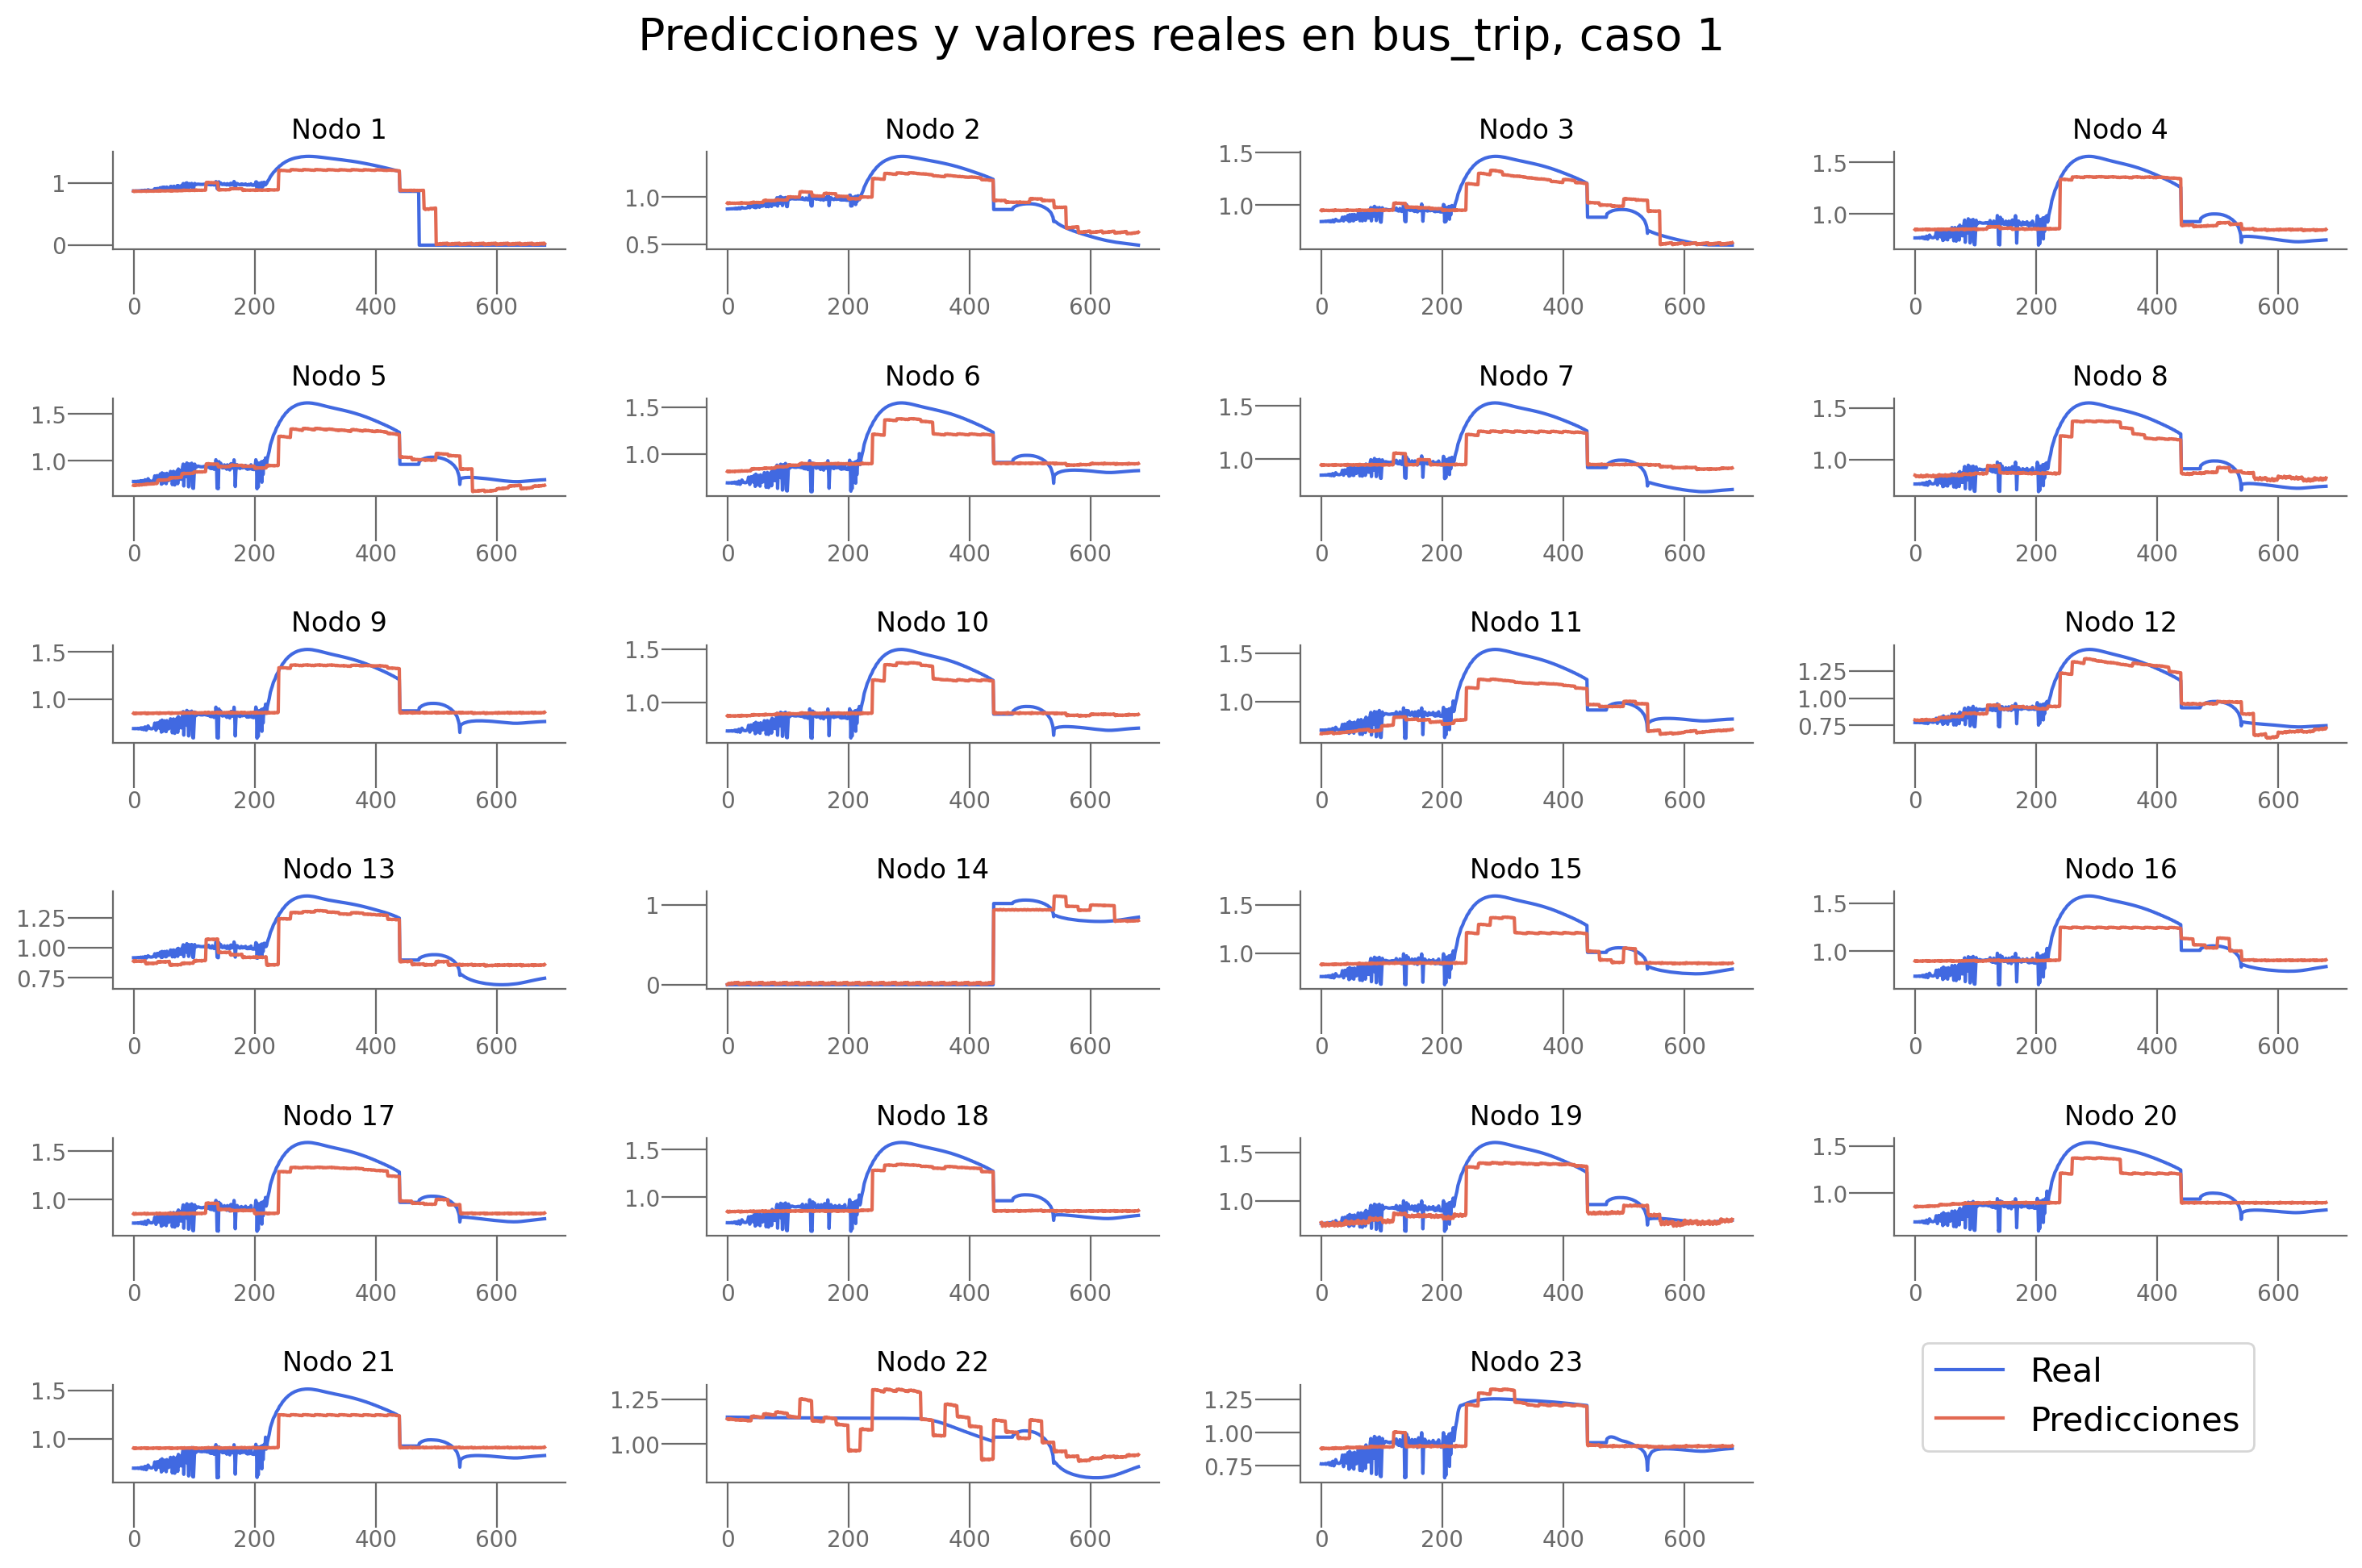

In [20]:
_,_,_, predictions_bt_ajuste,real_bt_ajuste = trainer_bt.test()
plot_predictions(predictions_bt_ajuste, real_bt_ajuste, n_target, 1, n_div_bt, problem_bt)

In [21]:
trainer_bt.save_model(path_save_experiment=path_save_experiment_bt, params = params_bt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                                          (32, 0.8)   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4         DCRNN                                     {'hidden': 60}   
5     EvolveGCN                                                NaN   
6        ASTGCN  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_...   
7         AGCRN            {'hidden': 10, 'K': 10, 'embedding': 3}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.005474  0.923150   
1                                                NaN  0.005606  0.865487   
2    ./results/bus_trip/ajustes/MPNNLSTM_results.csv  0.006753  0.845855   
3

### Bus fault

In [22]:
problem_bf = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bf)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [23]:

n_div_bf = loader.div
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
embedding_dim =5

#### Sencilla 

In [65]:
model_bf = AGCRNModel(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="AGCRN")
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model_bf.to(device)
trainer_bf = TrainerAGCRN(model_bf, dataset_bf,device, f"./results/{problem_bf}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_bf.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 405
DataLoader for val set:
Number of batches: 87
DataLoader for test set:
Number of batches: 86

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1202 | Eval Loss: 0.0651 | Eval R2: -0.7065 | 
Epoch 2/30 | Train Loss: 0.0397 | Eval Loss: 0.0472 | Eval R2: -0.0885 | 
Epoch 3/30 | Train Loss: 0.0325 | Eval Loss: 0.0425 | Eval R2: 0.0232 | 
Epoch 4/30 | Train Loss: 0.0293 | Eval Loss: 0.0399 | Eval R2: 0.0929 | 
Epoch 5/30 | Train Loss: 0.0274 | Eval Loss: 0.0385 | Eval R2: 0.1230 | 
Epoch 6/30 | Train Loss: 0.0265 | Eval Loss: 0.0373 | Eval R2: 0.1440 | 
Epoch 7/30 | Train Loss: 0.0258 | Eval Loss: 0.0356 | Eval R2: 0.2215 | 
Epoch 8/30 | Train Loss: 0.0251 | Eval Loss: 0.0345 | Eval R2: 0.2387 | 
Epoch 9/30 | Train Loss: 0.0245 | Eval Lo

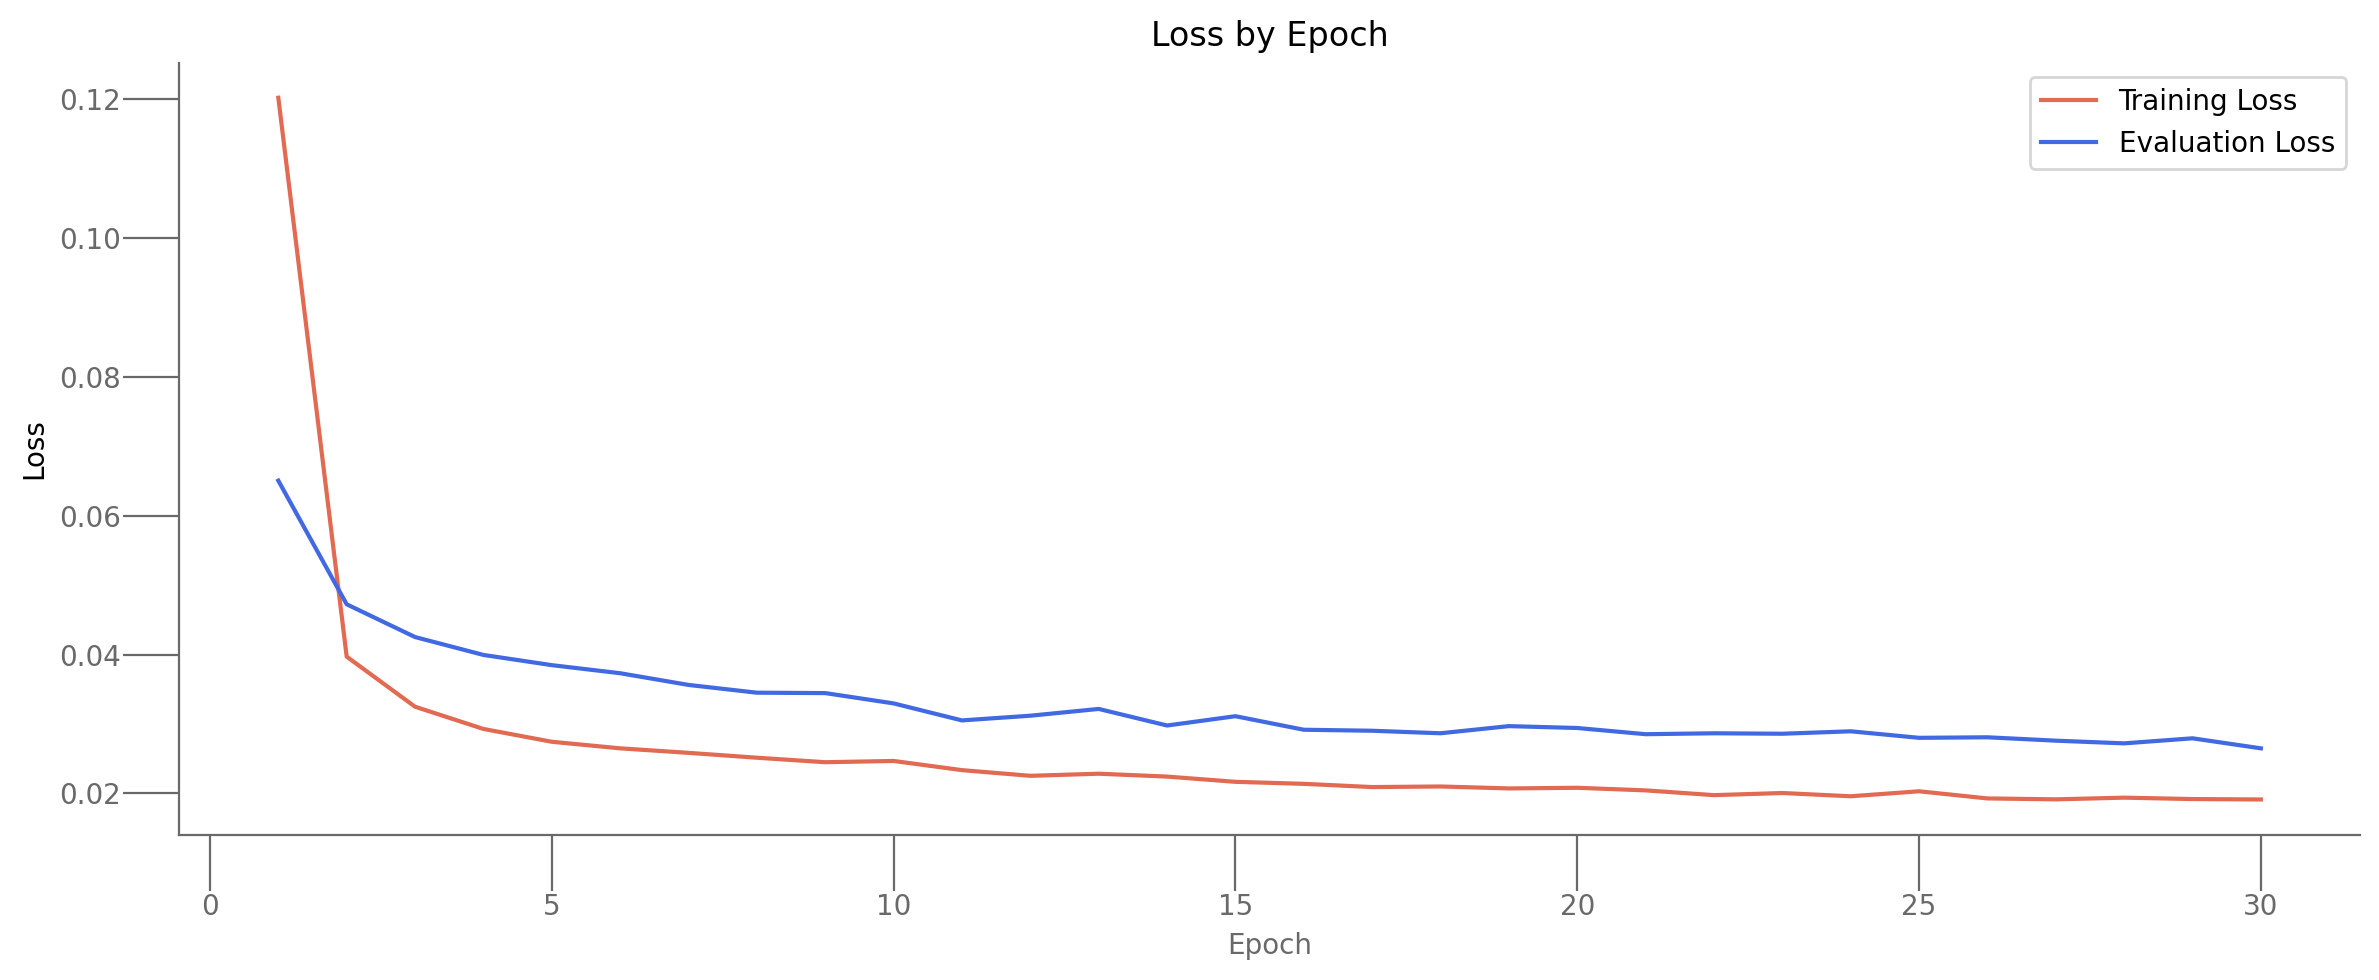


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.021107, test r2score 0.318805


In [66]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bf, real_bf = trainer_bf.test()



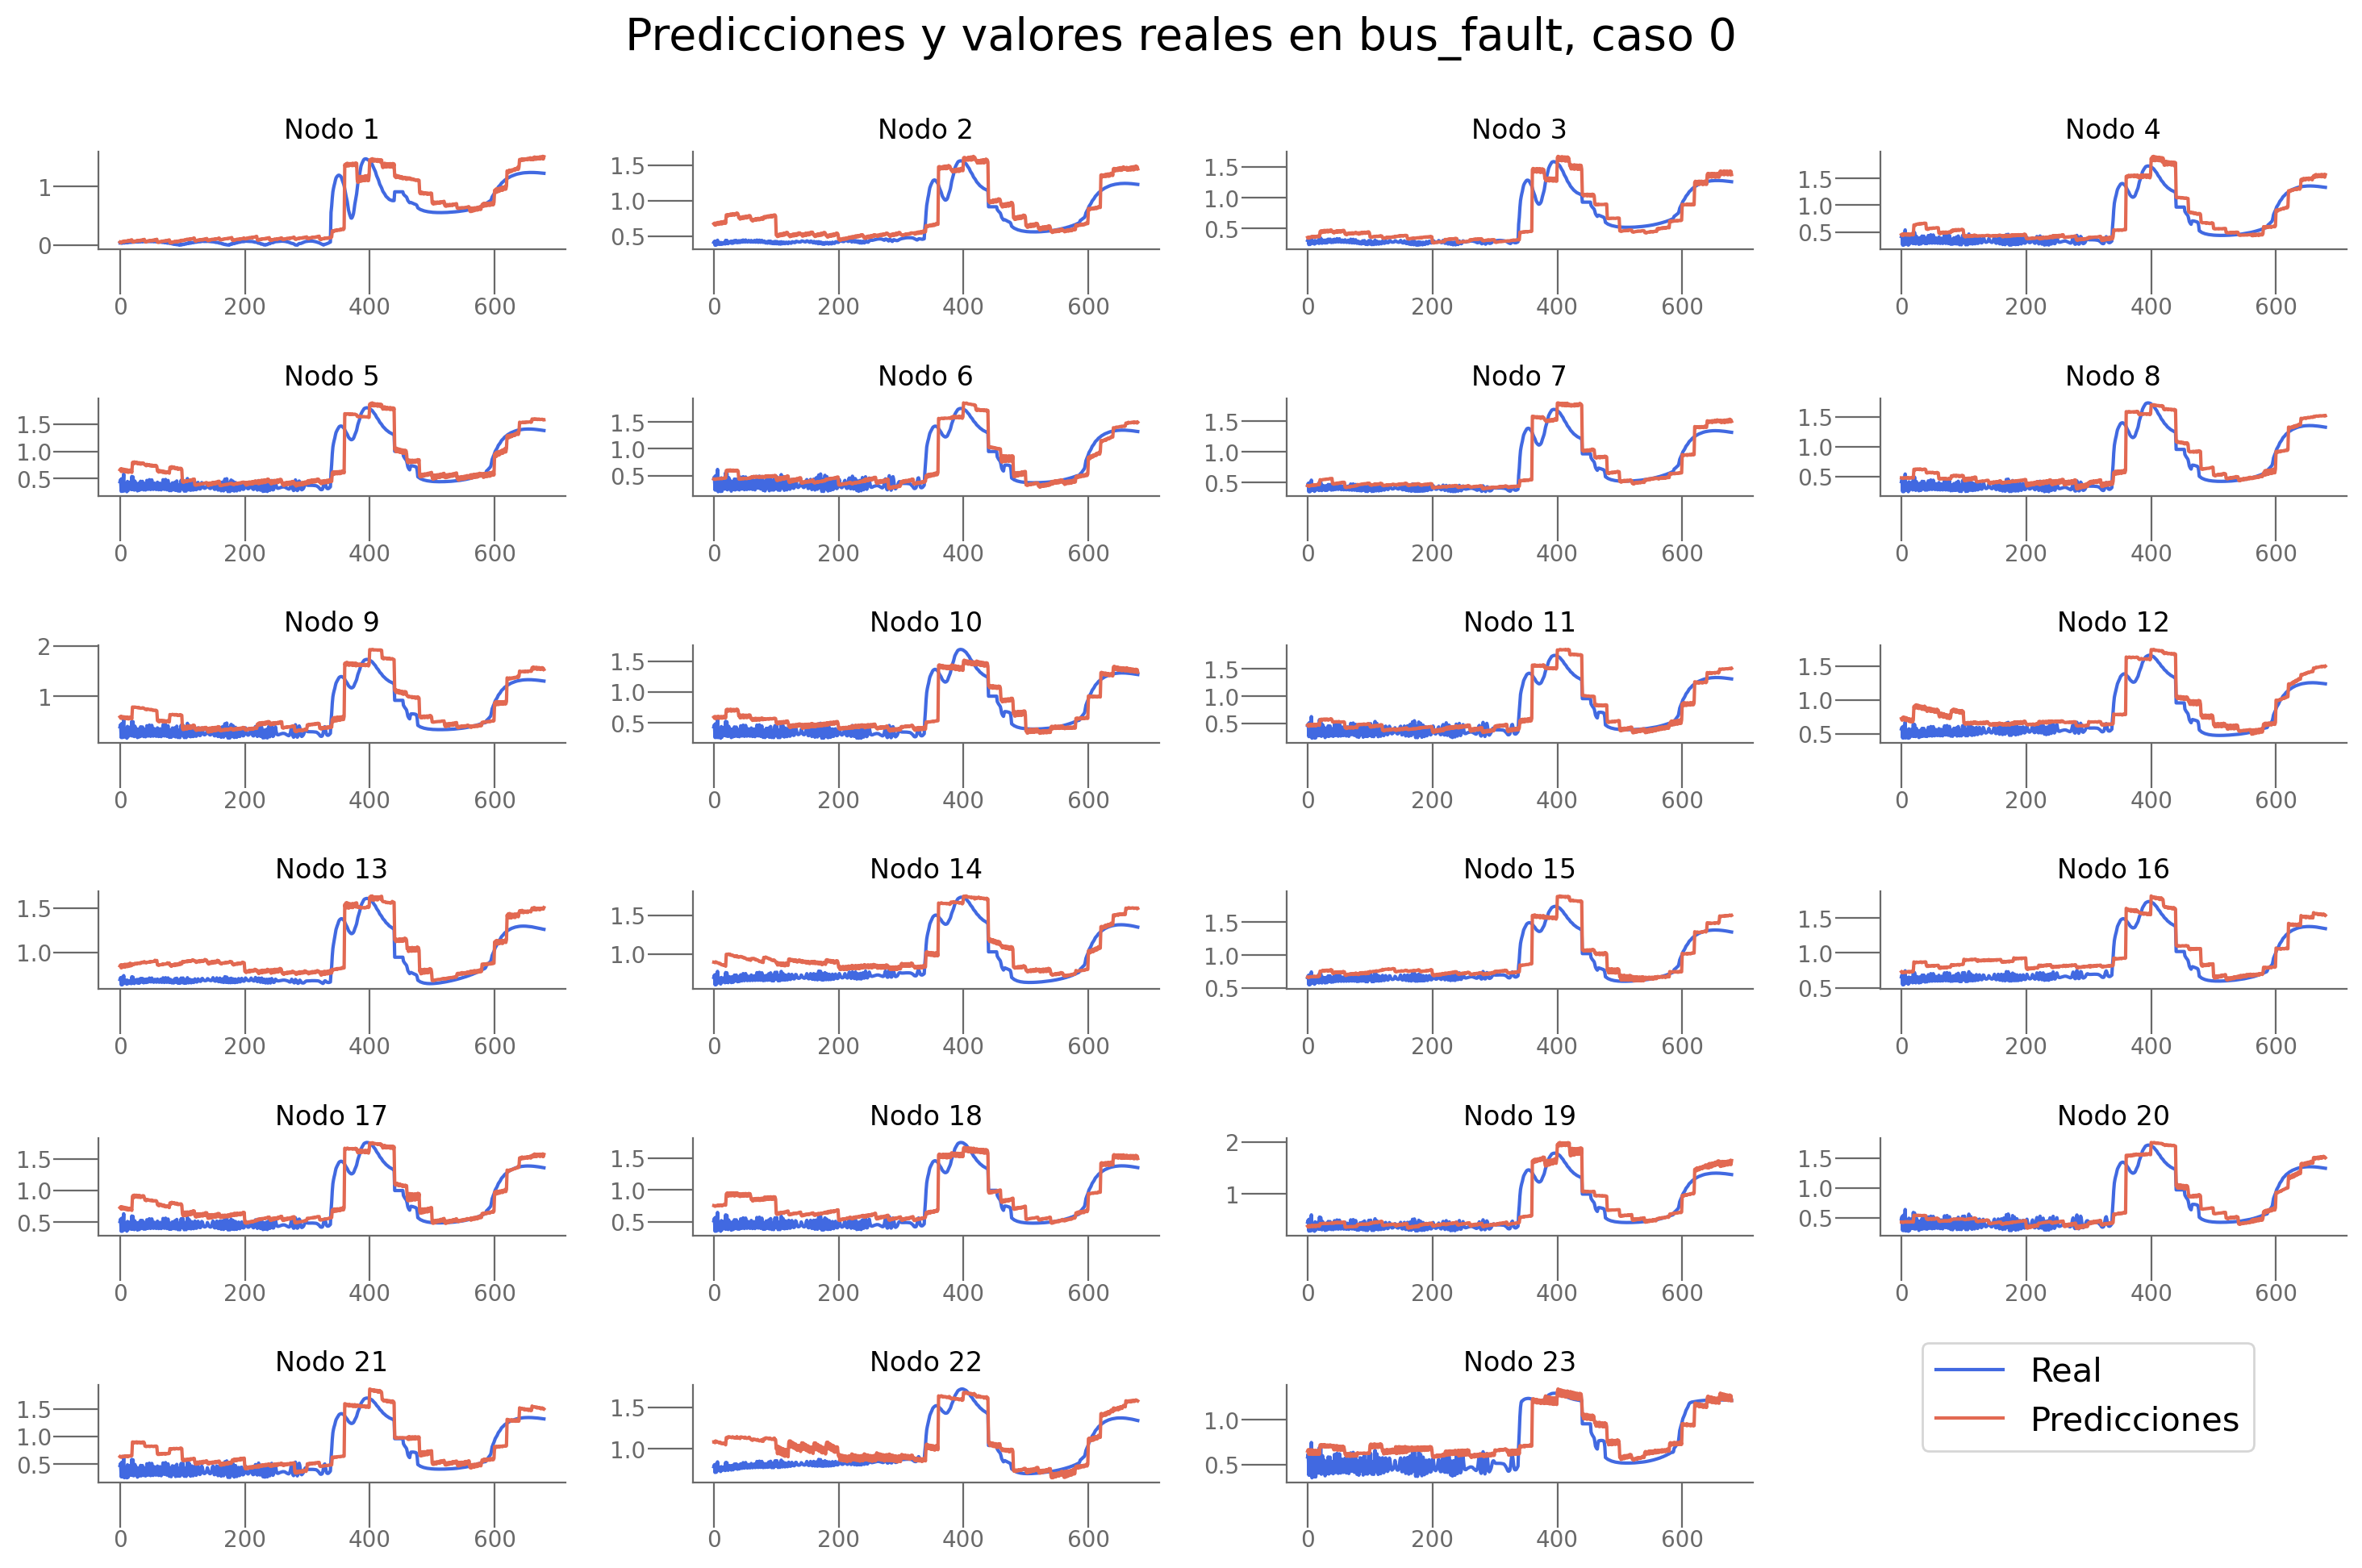

In [67]:
plot_predictions(predictions_bf, real_bf, n_target, 0, n_div_bf, problem_bf)

#### Ajuste de parámetros

In [24]:


trainer_bf,params_bf, resultados_final_bf, resultados_bf = entrenar_y_evaluar_modelos(param_grid, dataset_bf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bf)

  0%|          | 0/36 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 405
DataLoader for val set:
Number of batches: 87
DataLoader for test set:
Number of batches: 86

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.3466 | Eval Loss: 0.2261 | Eval R2: -9.0680 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.1891 | Eval Loss: 0.1672 | Eval R2: -6.1358 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.1500 | Eval Loss: 0.1424 | Eval R2: -4.8430 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.1299 | Eval Loss: 0.1321 | Eval R2: -4.3738 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.1202 | Eval Loss: 0.1319 | Eval R2: -4.2199 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.1140 | Eval Loss: 0.1270 | Eval R2: -4.0200 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.1101 | Eval Loss: 0.1201 | Eval R2: -3.8728 | LR: 0.0010 | 
Epoch 8/30 | Train

  3%|▎         | 1/36 [04:55<2:52:21, 295.47s/it]

preds:  (5, 23, 20)
test loss: 0.063603, test R2 score: -4.190842
Parámetros:  3 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 3, 'Loss_final': 0.07013145089149475, 'R2_eval': -1.7970811128616333, 'Loss_eval': 0.0747881606221199, 'R2_tst': -4.190842451382184, 'Loss_tst': 0.06360315531492233, 'Loss_nodes': [0.031041309237480164, 0.018712492659687996, 0.026162374764680862, 0.033205654472112656, 0.04673608019948006, 0.034755539149045944, 0.03551851585507393, 0.19926775991916656, 0.04865141957998276, 0.027923602610826492, 0.03433911129832268, 0.02077331766486168, 0.17343151569366455, 0.023655148223042488, 0.02394498698413372, 0.08170365542173386, 0.046295758336782455, 0.18711963295936584, 0.23046134412288666, 0.03651795908808708, 0.035138342529535294, 0.02591570094227791, 0.04160131514072418]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for

  6%|▌         | 2/36 [09:31<2:40:48, 283.78s/it]

preds:  (5, 23, 20)
test loss: 0.041885, test R2 score: -1.519240
Parámetros:  3 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 3, 'Loss_final': 0.05507996305823326, 'R2_eval': -0.8020204305648804, 'Loss_eval': 0.06269825994968414, 'R2_tst': -1.519240002546731, 'Loss_tst': 0.04188528284430504, 'Loss_nodes': [0.02661840245127678, 0.025137227028608322, 0.04230697080492973, 0.0300802793353796, 0.04735344648361206, 0.05573286488652229, 0.04202961549162865, 0.0341799221932888, 0.04867326840758324, 0.05720910802483559, 0.05155263841152191, 0.030170269310474396, 0.05729082599282265, 0.05135924741625786, 0.060393910855054855, 0.016746599227190018, 0.03838077932596207, 0.03714685142040253, 0.02965320460498333, 0.06308285892009735, 0.02526707388460636, 0.03425468131899834, 0.058741386979818344]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for trai

  8%|▊         | 3/36 [14:05<2:33:49, 279.68s/it]

preds:  (5, 23, 20)
test loss: 0.057179, test R2 score: -3.302732
Parámetros:  3 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 3, 'Loss_final': 0.05794581025838852, 'R2_eval': -1.5590202808380127, 'Loss_eval': 0.0707240104675293, 'R2_tst': -3.3027316607547688, 'Loss_tst': 0.05717867612838745, 'Loss_nodes': [0.026142176240682602, 0.05401604622602463, 0.06284158676862717, 0.08518647402524948, 0.06480731815099716, 0.0589328370988369, 0.042856622487306595, 0.056948449462652206, 0.08661618083715439, 0.04955097660422325, 0.0509762167930603, 0.06536044925451279, 0.04828468710184097, 0.057657934725284576, 0.0641370415687561, 0.039563603699207306, 0.03162466362118721, 0.06636667251586914, 0.06055772677063942, 0.0996873676776886, 0.0432288683950901, 0.048819053918123245, 0.05094660818576813]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train 

 11%|█         | 4/36 [19:45<2:41:49, 303.42s/it]

preds:  (5, 23, 20)
test loss: 0.052925, test R2 score: -2.218401
Parámetros:  3 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 3, 'Loss_final': 0.059463176876306534, 'R2_eval': -1.1250168085098267, 'Loss_eval': 0.07020173221826553, 'R2_tst': -2.218401300178926, 'Loss_tst': 0.05292519927024841, 'Loss_nodes': [0.04651033505797386, 0.03400969132781029, 0.02734140120446682, 0.05399098992347717, 0.0798211619257927, 0.053507983684539795, 0.047041960060596466, 0.033672548830509186, 0.05253124609589577, 0.06305494159460068, 0.05632458254694939, 0.03876376524567604, 0.04269832372665405, 0.05516807362437248, 0.0496528297662735, 0.031872257590293884, 0.04773248732089996, 0.06101443991065025, 0.06198602542281151, 0.05615502595901489, 0.054695356637239456, 0.054718632251024246, 0.11501538753509521]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for tr

 14%|█▍        | 5/36 [26:29<2:55:26, 339.56s/it]

preds:  (5, 23, 20)
test loss: 0.052336, test R2 score: -1.543329
Parámetros:  3 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 3, 'Loss_final': 0.061291616410017014, 'R2_eval': -1.6148618459701538, 'Loss_eval': 0.07408798485994339, 'R2_tst': -1.543329478164291, 'Loss_tst': 0.05233599990606308, 'Loss_nodes': [0.042207617312669754, 0.04156490042805672, 0.04162352532148361, 0.0648583248257637, 0.064577117562294, 0.054095711559057236, 0.04885369539260864, 0.03505847603082657, 0.0699237510561943, 0.04179370030760765, 0.04726126044988632, 0.03870807960629463, 0.04685796797275543, 0.05387987568974495, 0.047162506729364395, 0.05979723855853081, 0.07496413588523865, 0.06969370692968369, 0.05047817528247833, 0.048824988305568695, 0.06265823543071747, 0.05220852792263031, 0.0466763861477375]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train s

 17%|█▋        | 6/36 [32:17<2:51:09, 342.32s/it]

preds:  (5, 23, 20)
test loss: 0.060213, test R2 score: -2.756600
Parámetros:  3 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 3, 'Loss_final': 0.062059495598077774, 'R2_eval': -1.172365427017212, 'Loss_eval': 0.07526490092277527, 'R2_tst': -2.756600390873758, 'Loss_tst': 0.06021347641944885, 'Loss_nodes': [0.04458758980035782, 0.048357393592596054, 0.03885138779878616, 0.04424327239394188, 0.09104679524898529, 0.04693024605512619, 0.10344833880662918, 0.05636908859014511, 0.07265807688236237, 0.04420328140258789, 0.038624994456768036, 0.045259587466716766, 0.041414614766836166, 0.04803586006164551, 0.057092588394880295, 0.06395726650953293, 0.13465294241905212, 0.06941549479961395, 0.07185707241296768, 0.0712331011891365, 0.04814235493540764, 0.05256146565079689, 0.05196704342961311]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for tra

 19%|█▉        | 7/36 [42:49<3:31:20, 437.25s/it]

preds:  (5, 23, 20)
test loss: 0.072590, test R2 score: -4.103506
Parámetros:  3 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 3, 'Loss_final': 0.07582447677850723, 'R2_eval': -2.304739475250244, 'Loss_eval': 0.09567680209875107, 'R2_tst': -4.103506455756616, 'Loss_tst': 0.07259022444486618, 'Loss_nodes': [0.057922203093767166, 0.06759722530841827, 0.05663232505321503, 0.043037377297878265, 0.09321903437376022, 0.06494610756635666, 0.07215353846549988, 0.05595507100224495, 0.062337372452020645, 0.045403193682432175, 0.05436268076300621, 0.056426092982292175, 0.04258229583501816, 0.14913299679756165, 0.1356372833251953, 0.039101243019104004, 0.07760186493396759, 0.08633803576231003, 0.07537596672773361, 0.05092506483197212, 0.049435727298259735, 0.17755188047885895, 0.05590042844414711]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for tr

 22%|██▏       | 8/36 [53:22<3:53:04, 499.44s/it]

preds:  (5, 23, 20)
test loss: 0.083551, test R2 score: -5.735566
Parámetros:  3 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 3, 'Loss_final': 0.10018566995859146, 'R2_eval': -2.7149999141693115, 'Loss_eval': 0.10460016876459122, 'R2_tst': -5.735566314738279, 'Loss_tst': 0.08355101943016052, 'Loss_nodes': [0.05569670349359512, 0.047184720635414124, 0.056543249636888504, 0.05783800780773163, 0.05244288221001625, 0.12223289161920547, 0.053668927401304245, 0.051444053649902344, 0.08667563647031784, 0.05074751749634743, 0.06922872364521027, 0.06371783465147018, 0.04423338919878006, 0.05511089414358139, 0.07318197190761566, 0.20958083868026733, 0.06203413009643555, 0.0720263347029686, 0.06501846760511398, 0.11477036774158478, 0.16641032695770264, 0.2531198263168335, 0.03876567259430885]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train

 25%|██▌       | 9/36 [1:02:09<3:48:37, 508.04s/it]

preds:  (5, 23, 20)
test loss: 0.058892, test R2 score: -1.530203
Parámetros:  3 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 3, 'Loss_final': 0.07294624298810959, 'R2_eval': -1.576436161994934, 'Loss_eval': 0.08420165628194809, 'R2_tst': -1.530203263724707, 'Loss_tst': 0.05889175832271576, 'Loss_nodes': [0.10412483662366867, 0.06838661432266235, 0.057238612323999405, 0.054630767554044724, 0.042267706245183945, 0.060326896607875824, 0.055970702320337296, 0.054343704134225845, 0.08092387020587921, 0.05483580008149147, 0.054772503674030304, 0.05277517810463905, 0.04574882611632347, 0.051019903272390366, 0.058822810649871826, 0.06213728338479996, 0.056624699383974075, 0.06028561666607857, 0.06567177921533585, 0.06979517638683319, 0.056608472019433975, 0.048624683171510696, 0.03857395425438881]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader 

 28%|██▊       | 10/36 [1:05:39<3:00:16, 416.00s/it]

preds:  (5, 23, 20)
test loss: 0.059324, test R2 score: -2.930573
Parámetros:  5 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 5, 'Loss_final': 0.04512225091457367, 'R2_eval': -0.8381298780441284, 'Loss_eval': 0.06848952174186707, 'R2_tst': -2.9305731641568333, 'Loss_tst': 0.059324026107788086, 'Loss_nodes': [0.11866283416748047, 0.04381531476974487, 0.02777617983520031, 0.03375132009387016, 0.04930290952324867, 0.06570281833410263, 0.04405427724123001, 0.030480628833174706, 0.04960258677601814, 0.09841957688331604, 0.09282338619232178, 0.06587593257427216, 0.08752894401550293, 0.07488832622766495, 0.053240254521369934, 0.040430519729852676, 0.04657384380698204, 0.03830266743898392, 0.051900457590818405, 0.06349484622478485, 0.03457092121243477, 0.0763888731598854, 0.07686525583267212]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for tr

 31%|███       | 11/36 [1:09:07<2:26:48, 352.35s/it]

preds:  (5, 23, 20)
test loss: 0.038633, test R2 score: -1.107296
Parámetros:  5 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 5, 'Loss_final': 0.03913049027323723, 'R2_eval': -0.5147731900215149, 'Loss_eval': 0.050653934478759766, 'R2_tst': -1.107295535534405, 'Loss_tst': 0.03863285854458809, 'Loss_nodes': [0.027882611379027367, 0.03367402032017708, 0.03803897649049759, 0.03707710653543472, 0.0481991171836853, 0.036379434168338776, 0.03608136996626854, 0.032455530017614365, 0.04968594014644623, 0.02998472936451435, 0.03551790118217468, 0.050353676080703735, 0.027722563594579697, 0.04103071987628937, 0.03712746500968933, 0.0528421625494957, 0.03454422578215599, 0.04392356798052788, 0.03788168355822563, 0.04588428512215614, 0.04808161035180092, 0.03472095727920532, 0.029466157779097557]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for tr

 33%|███▎      | 12/36 [1:12:35<2:03:27, 308.65s/it]

preds:  (5, 23, 20)
test loss: 0.089924, test R2 score: -5.117023
Parámetros:  5 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 5, 'Loss_final': 0.04529120773077011, 'R2_eval': -2.1562609672546387, 'Loss_eval': 0.1100497841835022, 'R2_tst': -5.1170231398324795, 'Loss_tst': 0.0899241641163826, 'Loss_nodes': [0.16410361230373383, 0.0559956431388855, 0.06760465353727341, 0.06938482075929642, 0.08569038659334183, 0.07649871706962585, 0.17871308326721191, 0.07476940006017685, 0.052398499101400375, 0.11715048551559448, 0.09146451950073242, 0.10296078771352768, 0.0563911572098732, 0.07939116656780243, 0.07514328509569168, 0.06404128670692444, 0.18058376014232635, 0.05157019942998886, 0.11119642108678818, 0.08475005626678467, 0.1077878326177597, 0.06378385424613953, 0.0568823479115963]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:


 36%|███▌      | 13/36 [1:17:07<1:53:57, 297.29s/it]

preds:  (5, 23, 20)
test loss: 0.043448, test R2 score: -1.896690
Parámetros:  5 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 5, 'Loss_final': 0.04770594462752342, 'R2_eval': -0.4239707887172699, 'Loss_eval': 0.05385754629969597, 'R2_tst': -1.8966901266390865, 'Loss_tst': 0.04344765096902847, 'Loss_nodes': [0.06616687029600143, 0.02504735253751278, 0.03451517969369888, 0.034169502556324005, 0.05807696282863617, 0.03645899146795273, 0.03464188799262047, 0.03294830396771431, 0.044738851487636566, 0.05014781653881073, 0.06946688145399094, 0.05548829957842827, 0.05141254514455795, 0.02835906110703945, 0.027531862258911133, 0.02419281005859375, 0.050144512206315994, 0.056013572961091995, 0.04862840846180916, 0.06393018364906311, 0.03505922853946686, 0.027652423828840256, 0.04450439661741257]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for 

 39%|███▉      | 14/36 [1:21:39<1:46:12, 289.64s/it]

preds:  (5, 23, 20)
test loss: 0.050000, test R2 score: -1.452124
Parámetros:  5 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 5, 'Loss_final': 0.05571281909942627, 'R2_eval': -0.978762686252594, 'Loss_eval': 0.06426522135734558, 'R2_tst': -1.4521235485936375, 'Loss_tst': 0.050000011920928955, 'Loss_nodes': [0.03644786402583122, 0.04229805991053581, 0.07560132443904877, 0.05249254032969475, 0.07763079553842545, 0.04535821080207825, 0.082957923412323, 0.031489111483097076, 0.06827645748853683, 0.035223718732595444, 0.043328363448381424, 0.021763186901807785, 0.04450375959277153, 0.049544982612133026, 0.03949594870209694, 0.0598609559237957, 0.03819893300533295, 0.052915263921022415, 0.05314948409795761, 0.050394024699926376, 0.057867683470249176, 0.05436185747385025, 0.03683977946639061]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for t

 42%|████▏     | 15/36 [1:26:03<1:38:44, 282.11s/it]

preds:  (5, 23, 20)
test loss: 0.043782, test R2 score: -1.331811
Parámetros:  5 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 5, 'Loss_final': 0.04949554055929184, 'R2_eval': -0.5932506918907166, 'Loss_eval': 0.06002907454967499, 'R2_tst': -1.3318106074487763, 'Loss_tst': 0.04378167539834976, 'Loss_nodes': [0.052141930907964706, 0.03662307560443878, 0.04238574206829071, 0.05440738424658775, 0.041234441101551056, 0.050148483365774155, 0.043897490948438644, 0.04156116023659706, 0.06287307292222977, 0.04624364525079727, 0.05439121648669243, 0.03945348039269447, 0.026511764153838158, 0.02364659309387207, 0.03271348401904106, 0.04230285808444023, 0.04542744532227516, 0.04910678789019585, 0.06184647977352142, 0.06187624856829643, 0.039563458412885666, 0.0285174623131752, 0.030104802921414375]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for 

 44%|████▍     | 16/36 [1:34:37<1:57:14, 351.73s/it]

preds:  (5, 23, 20)
test loss: 0.052255, test R2 score: -1.652650
Parámetros:  5 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 5, 'Loss_final': 0.07117660343647003, 'R2_eval': -1.3042328357696533, 'Loss_eval': 0.07769231498241425, 'R2_tst': -1.6526497506362312, 'Loss_tst': 0.0522545650601387, 'Loss_nodes': [0.04343213140964508, 0.056337274610996246, 0.047542423009872437, 0.04198933020234108, 0.06473807245492935, 0.06280016154050827, 0.0528864860534668, 0.05484982952475548, 0.06902019679546356, 0.04777787998318672, 0.05538060888648033, 0.04783150926232338, 0.05702599138021469, 0.046636976301670074, 0.03807617723941803, 0.05127938836812973, 0.047798145562410355, 0.05638488009572029, 0.06544008105993271, 0.05907861143350601, 0.044694628566503525, 0.045804157853126526, 0.04504995048046112]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for tr

 47%|████▋     | 17/36 [1:43:05<2:06:18, 398.85s/it]

preds:  (5, 23, 20)
test loss: 0.056351, test R2 score: -2.548214
Parámetros:  5 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 5, 'Loss_final': 0.06694602221250534, 'R2_eval': -1.3490725755691528, 'Loss_eval': 0.07410424202680588, 'R2_tst': -2.548214195603519, 'Loss_tst': 0.05635055899620056, 'Loss_nodes': [0.05119394138455391, 0.06043350324034691, 0.049278974533081055, 0.0575733408331871, 0.051843076944351196, 0.06608647853136063, 0.056671082973480225, 0.0385751947760582, 0.07220666855573654, 0.0412135049700737, 0.06098123639822006, 0.035101547837257385, 0.04510177671909332, 0.05011609569191933, 0.06581132113933563, 0.041321780532598495, 0.07150927186012268, 0.07300946861505508, 0.0625387579202652, 0.06558618694543839, 0.05366114526987076, 0.08931133151054382, 0.036937080323696136]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train

 50%|█████     | 18/36 [1:51:35<2:09:42, 432.37s/it]

preds:  (5, 23, 20)
test loss: 0.071204, test R2 score: -4.383372
Parámetros:  5 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 5, 'Loss_final': 0.07782081514596939, 'R2_eval': -1.9441123008728027, 'Loss_eval': 0.08660244941711426, 'R2_tst': -4.383372363312457, 'Loss_tst': 0.07120433449745178, 'Loss_nodes': [0.0672009289264679, 0.030614254996180534, 0.058293525129556656, 0.1404556781053543, 0.055464666336774826, 0.0773712694644928, 0.05621842294931412, 0.050315991044044495, 0.17540888488292694, 0.053010135889053345, 0.07209226489067078, 0.11742790043354034, 0.03124672919511795, 0.03110622800886631, 0.05020737275481224, 0.04278555139899254, 0.06015494093298912, 0.08274652808904648, 0.0674591064453125, 0.15311114490032196, 0.0692717656493187, 0.0484442263841629, 0.04729219526052475]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train se

 53%|█████▎    | 19/36 [1:55:02<1:43:16, 364.49s/it]

preds:  (5, 23, 20)
test loss: 0.037198, test R2 score: -1.047515
Parámetros:  10 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 10, 'Loss_final': 0.02691483497619629, 'R2_eval': -0.0047411262057721615, 'Loss_eval': 0.04157298803329468, 'R2_tst': -1.0475149754947584, 'Loss_tst': 0.037197694182395935, 'Loss_nodes': [0.0314314030110836, 0.023986423388123512, 0.017810195684432983, 0.06853962689638138, 0.04301565885543823, 0.038425758481025696, 0.03709083050489426, 0.023635737597942352, 0.07014410197734833, 0.035300225019454956, 0.04472413659095764, 0.02888927049934864, 0.03525714948773384, 0.03448311239480972, 0.0328935869038105, 0.02026659995317459, 0.03412226587533951, 0.03280255198478699, 0.03807183355093002, 0.037481680512428284, 0.055166859179735184, 0.03189222142100334, 0.04011572152376175]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader

 56%|█████▌    | 20/36 [1:58:30<1:24:40, 317.52s/it]

preds:  (5, 23, 20)
test loss: 0.034256, test R2 score: -0.516008
Parámetros:  10 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 10, 'Loss_final': 0.033054884523153305, 'R2_eval': -0.06712448596954346, 'Loss_eval': 0.043642111122608185, 'R2_tst': -0.516008156435378, 'Loss_tst': 0.03425567224621773, 'Loss_nodes': [0.02074277028441429, 0.026888839900493622, 0.025609562173485756, 0.037086233496665955, 0.051491376012563705, 0.03728898987174034, 0.03292476758360863, 0.050589390099048615, 0.043022215366363525, 0.026336994022130966, 0.043443843722343445, 0.027315879240632057, 0.01784088835120201, 0.026467345654964447, 0.039582204073667526, 0.029369650408625603, 0.039920687675476074, 0.03490211442112923, 0.03700915724039078, 0.03807251527905464, 0.04414181411266327, 0.025486689060926437, 0.03234654292464256]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

Dat

 58%|█████▊    | 21/36 [2:01:58<1:11:09, 284.61s/it]

preds:  (5, 23, 20)
test loss: 0.038160, test R2 score: -0.816372
Parámetros:  10 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 10, 'Loss_final': 0.03271040320396423, 'R2_eval': -0.09999845176935196, 'Loss_eval': 0.04383125901222229, 'R2_tst': -0.8163717571449794, 'Loss_tst': 0.03815985098481178, 'Loss_nodes': [0.04166268929839134, 0.028111765161156654, 0.02799973636865616, 0.03751492127776146, 0.03720436990261078, 0.04538402333855629, 0.051321372389793396, 0.04064483940601349, 0.037046000361442566, 0.04498162493109703, 0.038539957255125046, 0.032137271016836166, 0.029472406953573227, 0.03003745898604393, 0.03300371393561363, 0.054324470460414886, 0.05174772068858147, 0.03459197282791138, 0.03797873854637146, 0.040847957134246826, 0.051915861666202545, 0.026021402329206467, 0.025186266750097275]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoa

 61%|██████    | 22/36 [2:06:42<1:06:25, 284.65s/it]

preds:  (5, 23, 20)
test loss: 0.037465, test R2 score: -0.839202
Parámetros:  10 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 10, 'Loss_final': 0.03723632171750069, 'R2_eval': -0.13111332058906555, 'Loss_eval': 0.04664142057299614, 'R2_tst': -0.8392020039338642, 'Loss_tst': 0.037464868277311325, 'Loss_nodes': [0.030724966898560524, 0.024852633476257324, 0.0420951247215271, 0.03642117232084274, 0.03484145551919937, 0.03579208254814148, 0.026404688134789467, 0.039082594215869904, 0.044251665472984314, 0.03798900544643402, 0.038906633853912354, 0.02873186767101288, 0.028022965416312218, 0.03183041885495186, 0.028164062649011612, 0.027588827535510063, 0.07857206463813782, 0.05196012556552887, 0.04756822809576988, 0.03849542513489723, 0.0346607081592083, 0.026364780962467194, 0.04837046191096306]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoade

 64%|██████▍   | 23/36 [2:11:22<1:01:19, 283.07s/it]

preds:  (5, 23, 20)
test loss: 0.037142, test R2 score: -0.543560
Parámetros:  10 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 10, 'Loss_final': 0.03780723735690117, 'R2_eval': -0.13729462027549744, 'Loss_eval': 0.04792899265885353, 'R2_tst': -0.5435596702475233, 'Loss_tst': 0.03714222088456154, 'Loss_nodes': [0.035973865538835526, 0.03154342621564865, 0.03928801789879799, 0.03507222235202789, 0.03800475597381592, 0.03864959999918938, 0.03771476447582245, 0.03384775668382645, 0.046348392963409424, 0.039233848452568054, 0.03570229932665825, 0.028936998918652534, 0.0315830260515213, 0.028530780225992203, 0.030539143830537796, 0.057720672339200974, 0.04263635724782944, 0.03533193841576576, 0.03992435708642006, 0.037966713309288025, 0.042748674750328064, 0.022609736770391464, 0.044363684952259064]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoad

 67%|██████▋   | 24/36 [2:16:03<56:28, 282.40s/it]  

preds:  (5, 23, 20)
test loss: 0.042705, test R2 score: -1.165233
Parámetros:  10 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 10, 'Loss_final': 0.04072980210185051, 'R2_eval': -0.5015251636505127, 'Loss_eval': 0.0547519326210022, 'R2_tst': -1.165233313210811, 'Loss_tst': 0.042705316096544266, 'Loss_nodes': [0.03188668563961983, 0.05799967795610428, 0.03918328881263733, 0.0376458577811718, 0.0381220318377018, 0.05163804814219475, 0.03658570721745491, 0.04117170348763466, 0.058927763253450394, 0.07280145585536957, 0.043167099356651306, 0.03302335739135742, 0.021802563220262527, 0.027245037257671356, 0.027728473767638206, 0.06969602406024933, 0.03884080797433853, 0.04885762184858322, 0.04351634532213211, 0.054138004779815674, 0.05115829408168793, 0.0221911258995533, 0.034895241260528564]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for t

 69%|██████▉   | 25/36 [2:26:04<1:09:19, 378.12s/it]

preds:  (5, 23, 20)
test loss: 0.041452, test R2 score: -1.317755
Parámetros:  10 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 10, 'Loss_final': 0.05110647901892662, 'R2_eval': -0.4612691104412079, 'Loss_eval': 0.056494709104299545, 'R2_tst': -1.3177547268023495, 'Loss_tst': 0.04145202785730362, 'Loss_nodes': [0.02806279808282852, 0.04467815160751343, 0.0404854454100132, 0.04076116904616356, 0.05648403242230415, 0.05535437911748886, 0.04254714399576187, 0.04048875719308853, 0.04632236063480377, 0.03764992952346802, 0.04194071516394615, 0.027749525383114815, 0.03639853745698929, 0.04268382489681244, 0.03893614187836647, 0.02726386860013008, 0.04490978270769119, 0.05678096413612366, 0.049537815153598785, 0.04197198525071144, 0.04071778431534767, 0.034679558128118515, 0.03699186444282532]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for t

 72%|███████▏  | 26/36 [2:35:46<1:13:11, 439.14s/it]

preds:  (5, 23, 20)
test loss: 0.061361, test R2 score: -3.271287
Parámetros:  10 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 10, 'Loss_final': 0.05213533714413643, 'R2_eval': -0.7991514801979065, 'Loss_eval': 0.06579572707414627, 'R2_tst': -3.2712869224915226, 'Loss_tst': 0.06136125698685646, 'Loss_nodes': [0.0693603903055191, 0.0609031617641449, 0.05191141366958618, 0.08793557435274124, 0.07249941676855087, 0.07028647512197495, 0.0721411257982254, 0.06440086662769318, 0.08609122037887573, 0.05293779447674751, 0.06431818753480911, 0.04238980636000633, 0.02942882850766182, 0.039487142115831375, 0.04030046612024307, 0.06990063935518265, 0.04951588436961174, 0.09649817645549774, 0.0583019033074379, 0.07653353363275528, 0.06525058299303055, 0.03770435228943825, 0.05321183800697327]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train s

 75%|███████▌  | 27/36 [2:45:30<1:12:24, 482.74s/it]

preds:  (5, 23, 20)
test loss: 0.053058, test R2 score: -2.422359
Parámetros:  10 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 10, 'Loss_final': 0.05897592753171921, 'R2_eval': -0.8492368459701538, 'Loss_eval': 0.06739317625761032, 'R2_tst': -2.4223590616625024, 'Loss_tst': 0.05305763706564903, 'Loss_nodes': [0.08797267079353333, 0.044823385775089264, 0.05896647647023201, 0.055146876722574234, 0.06344061344861984, 0.058316636830568314, 0.054421912878751755, 0.041072189807891846, 0.07578053325414658, 0.04150671139359474, 0.054089512676000595, 0.04599723592400551, 0.034394074231386185, 0.032196830958127975, 0.03694553300738335, 0.04400118812918663, 0.055984459817409515, 0.060737065970897675, 0.05113879591226578, 0.05811241641640663, 0.09038591384887695, 0.03421585634350777, 0.04067881032824516]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoade

 78%|███████▊  | 28/36 [2:49:22<54:19, 407.47s/it]  

Parámetros:  15 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 15, 'Loss_final': 0.031564582139253616, 'R2_eval': 0.08669490367174149, 'Loss_eval': 0.03996748477220535, 'R2_tst': -0.5541221766820901, 'Loss_tst': 0.03212714567780495, 'Loss_nodes': [0.03256785497069359, 0.0218901876360178, 0.023588111624121666, 0.04076240956783295, 0.03554148226976395, 0.03504849597811699, 0.02381466142833233, 0.02782176248729229, 0.04014137014746666, 0.03136250749230385, 0.037710417062044144, 0.024444080889225006, 0.03484846651554108, 0.026780294254422188, 0.024542536586523056, 0.02333904430270195, 0.03827591985464096, 0.05330805853009224, 0.03232602775096893, 0.03388933092355728, 0.0415370799601078, 0.021922338753938675, 0.03346192091703415]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 405
DataLoader for val set:
Number 

 81%|████████  | 29/36 [2:53:07<41:09, 352.83s/it]

preds:  (5, 23, 20)
test loss: 0.031563, test R2 score: -0.441072
Parámetros:  15 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 15, 'Loss_final': 0.028986720368266106, 'R2_eval': 0.06447766721248627, 'Loss_eval': 0.04010873660445213, 'R2_tst': -0.44107166521669383, 'Loss_tst': 0.031563468277454376, 'Loss_nodes': [0.021792899817228317, 0.020125985145568848, 0.03332220017910004, 0.03204350173473358, 0.03140771761536598, 0.03393149748444557, 0.031147152185440063, 0.023548780009150505, 0.04089810326695442, 0.031381092965602875, 0.028939779847860336, 0.03444204106926918, 0.03159821406006813, 0.02285069040954113, 0.03849824145436287, 0.03347817435860634, 0.03848942741751671, 0.03660619258880615, 0.03795995935797691, 0.03361094743013382, 0.03667972981929779, 0.02278105728328228, 0.030426327139139175]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoade

 83%|████████▎ | 30/36 [2:56:54<31:29, 314.95s/it]

preds:  (5, 23, 20)
test loss: 0.046710, test R2 score: -1.634788
Parámetros:  15 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 15, 'Loss_final': 0.03046269156038761, 'R2_eval': -0.24654585123062134, 'Loss_eval': 0.04913199692964554, 'R2_tst': -1.634788417180006, 'Loss_tst': 0.046710290014743805, 'Loss_nodes': [0.03393968194723129, 0.05291327089071274, 0.03718581423163414, 0.03538237512111664, 0.04634103178977966, 0.05034675821661949, 0.06946708261966705, 0.05029911920428276, 0.040181003510951996, 0.03840770944952965, 0.06320488452911377, 0.03587282821536064, 0.031069373711943626, 0.05338574945926666, 0.04645027592778206, 0.06424959003925323, 0.0512995570898056, 0.045042846351861954, 0.036207348108291626, 0.04404637590050697, 0.07966979593038559, 0.03268991410732269, 0.03668426349759102]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for 

 86%|████████▌ | 31/36 [3:02:25<26:39, 319.95s/it]

preds:  (5, 23, 20)
test loss: 0.034131, test R2 score: -0.283133
Parámetros:  15 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 15, 'Loss_final': 0.031101591885089874, 'R2_eval': -0.11936409026384354, 'Loss_eval': 0.04411431401968002, 'R2_tst': -0.2831329250383448, 'Loss_tst': 0.03413143381476402, 'Loss_nodes': [0.028198247775435448, 0.02727566845715046, 0.02242368645966053, 0.039831310510635376, 0.03926737233996391, 0.04287654161453247, 0.033941108733415604, 0.03509834036231041, 0.0468498170375824, 0.03845369443297386, 0.04190896824002266, 0.029449202120304108, 0.022252697497606277, 0.02470891736447811, 0.025922609493136406, 0.03057185932993889, 0.039002206176519394, 0.03483632951974869, 0.03726894035935402, 0.03790346533060074, 0.043356213718652725, 0.030176905915141106, 0.033448800444602966]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoad

 89%|████████▉ | 32/36 [3:07:47<21:21, 320.41s/it]

preds:  (5, 23, 20)
test loss: 0.039971, test R2 score: -1.039573
Parámetros:  15 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 15, 'Loss_final': 0.03367383033037186, 'R2_eval': -0.108185775578022, 'Loss_eval': 0.04665881767868996, 'R2_tst': -1.0395730383287758, 'Loss_tst': 0.03997085243463516, 'Loss_nodes': [0.03164123743772507, 0.020953036844730377, 0.040716663002967834, 0.043639831244945526, 0.03921786695718765, 0.047383878380060196, 0.03609675168991089, 0.12091002613306046, 0.04748618230223656, 0.03222585469484329, 0.035606589168310165, 0.02808198891580105, 0.022679759189486504, 0.028113730251789093, 0.03483497351408005, 0.038753654807806015, 0.04106440395116806, 0.04004649072885513, 0.03684339299798012, 0.04433935880661011, 0.04462066665291786, 0.029576534405350685, 0.03449678793549538]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader 

 92%|█████████▏| 33/36 [3:13:09<16:02, 320.89s/it]

preds:  (5, 23, 20)
test loss: 0.041563, test R2 score: -1.296515
Parámetros:  15 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 15, 'Loss_final': 0.03539036959409714, 'R2_eval': -0.35839173197746277, 'Loss_eval': 0.05041977018117905, 'R2_tst': -1.2965151222667917, 'Loss_tst': 0.041563138365745544, 'Loss_nodes': [0.029538042843341827, 0.02864055335521698, 0.05722060427069664, 0.04434287175536156, 0.056467410176992416, 0.04591875150799751, 0.03889623284339905, 0.042979560792446136, 0.05160942301154137, 0.031331706792116165, 0.04897024855017662, 0.030493417754769325, 0.024032138288021088, 0.03831658139824867, 0.05467766895890236, 0.0387444831430912, 0.040875330567359924, 0.035446226596832275, 0.039550937712192535, 0.052544545382261276, 0.05982448160648346, 0.02377837523818016, 0.04175248742103577]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoad

 94%|█████████▍| 34/36 [3:24:22<14:12, 426.41s/it]

preds:  (5, 23, 20)
test loss: 0.039867, test R2 score: -0.845737
Parámetros:  15 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 15, 'Loss_final': 0.04045844078063965, 'R2_eval': -0.2881637215614319, 'Loss_eval': 0.05203736573457718, 'R2_tst': -0.8457370385876315, 'Loss_tst': 0.03986663371324539, 'Loss_nodes': [0.039811402559280396, 0.02962924912571907, 0.04035797342658043, 0.04324156418442726, 0.041878074407577515, 0.03993109613656998, 0.03266602382063866, 0.047965824604034424, 0.05039454996585846, 0.03866305574774742, 0.04831402376294136, 0.03121965192258358, 0.022908248007297516, 0.032425787299871445, 0.03168121725320816, 0.027399199083447456, 0.04844733327627182, 0.047744158655405045, 0.05427087843418121, 0.04447562247514725, 0.05227096006274223, 0.02867579646408558, 0.04256093129515648]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader f

 97%|█████████▋| 35/36 [3:36:01<08:28, 508.24s/it]

preds:  (5, 23, 20)
test loss: 0.042505, test R2 score: -1.433906
Parámetros:  15 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 15, 'Loss_final': 0.04287828877568245, 'R2_eval': -0.3650495111942291, 'Loss_eval': 0.054687317460775375, 'R2_tst': -1.4339056652737978, 'Loss_tst': 0.04250521957874298, 'Loss_nodes': [0.04039919003844261, 0.03731608763337135, 0.032721057534217834, 0.0406060591340065, 0.03922192007303238, 0.0572696328163147, 0.04166906699538231, 0.04356266185641289, 0.05939718335866928, 0.0369858518242836, 0.046578679233789444, 0.03655132278800011, 0.024368667975068092, 0.03423278033733368, 0.03488233685493469, 0.038910020142793655, 0.05463394522666931, 0.043136849999427795, 0.04490136727690697, 0.04320480301976204, 0.04239964112639427, 0.038826216012239456, 0.06584473699331284]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for 

100%|██████████| 36/36 [3:47:11<00:00, 378.65s/it]

preds:  (5, 23, 20)
test loss: 0.080932, test R2 score: -5.371604
Parámetros:  15 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 15, 'Loss_final': 0.04954192042350769, 'R2_eval': -1.4653295278549194, 'Loss_eval': 0.08773376047611237, 'R2_tst': -5.371604431176057, 'Loss_tst': 0.08093156665563583, 'Loss_nodes': [0.15092433989048004, 0.03147861734032631, 0.07752031832933426, 0.05300181359052658, 0.06435155868530273, 0.15069149434566498, 0.08412458002567291, 0.14245276153087616, 0.058203473687171936, 0.05434545874595642, 0.16699862480163574, 0.0559890940785408, 0.023200513795018196, 0.05914481729269028, 0.09937597066164017, 0.0547618493437767, 0.056881293654441833, 0.10963065177202225, 0.06855976581573486, 0.05764055252075195, 0.1363929957151413, 0.03167331963777542, 0.07408227771520615]}


In [25]:
path_save_experiment_bf = results_save_path+f"/{problem_bf}"+ f"/ajustes/{name_model}_results.csv"
resultados_bf.to_csv(path_save_experiment_bf, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.031563, test R2 score: -0.441072


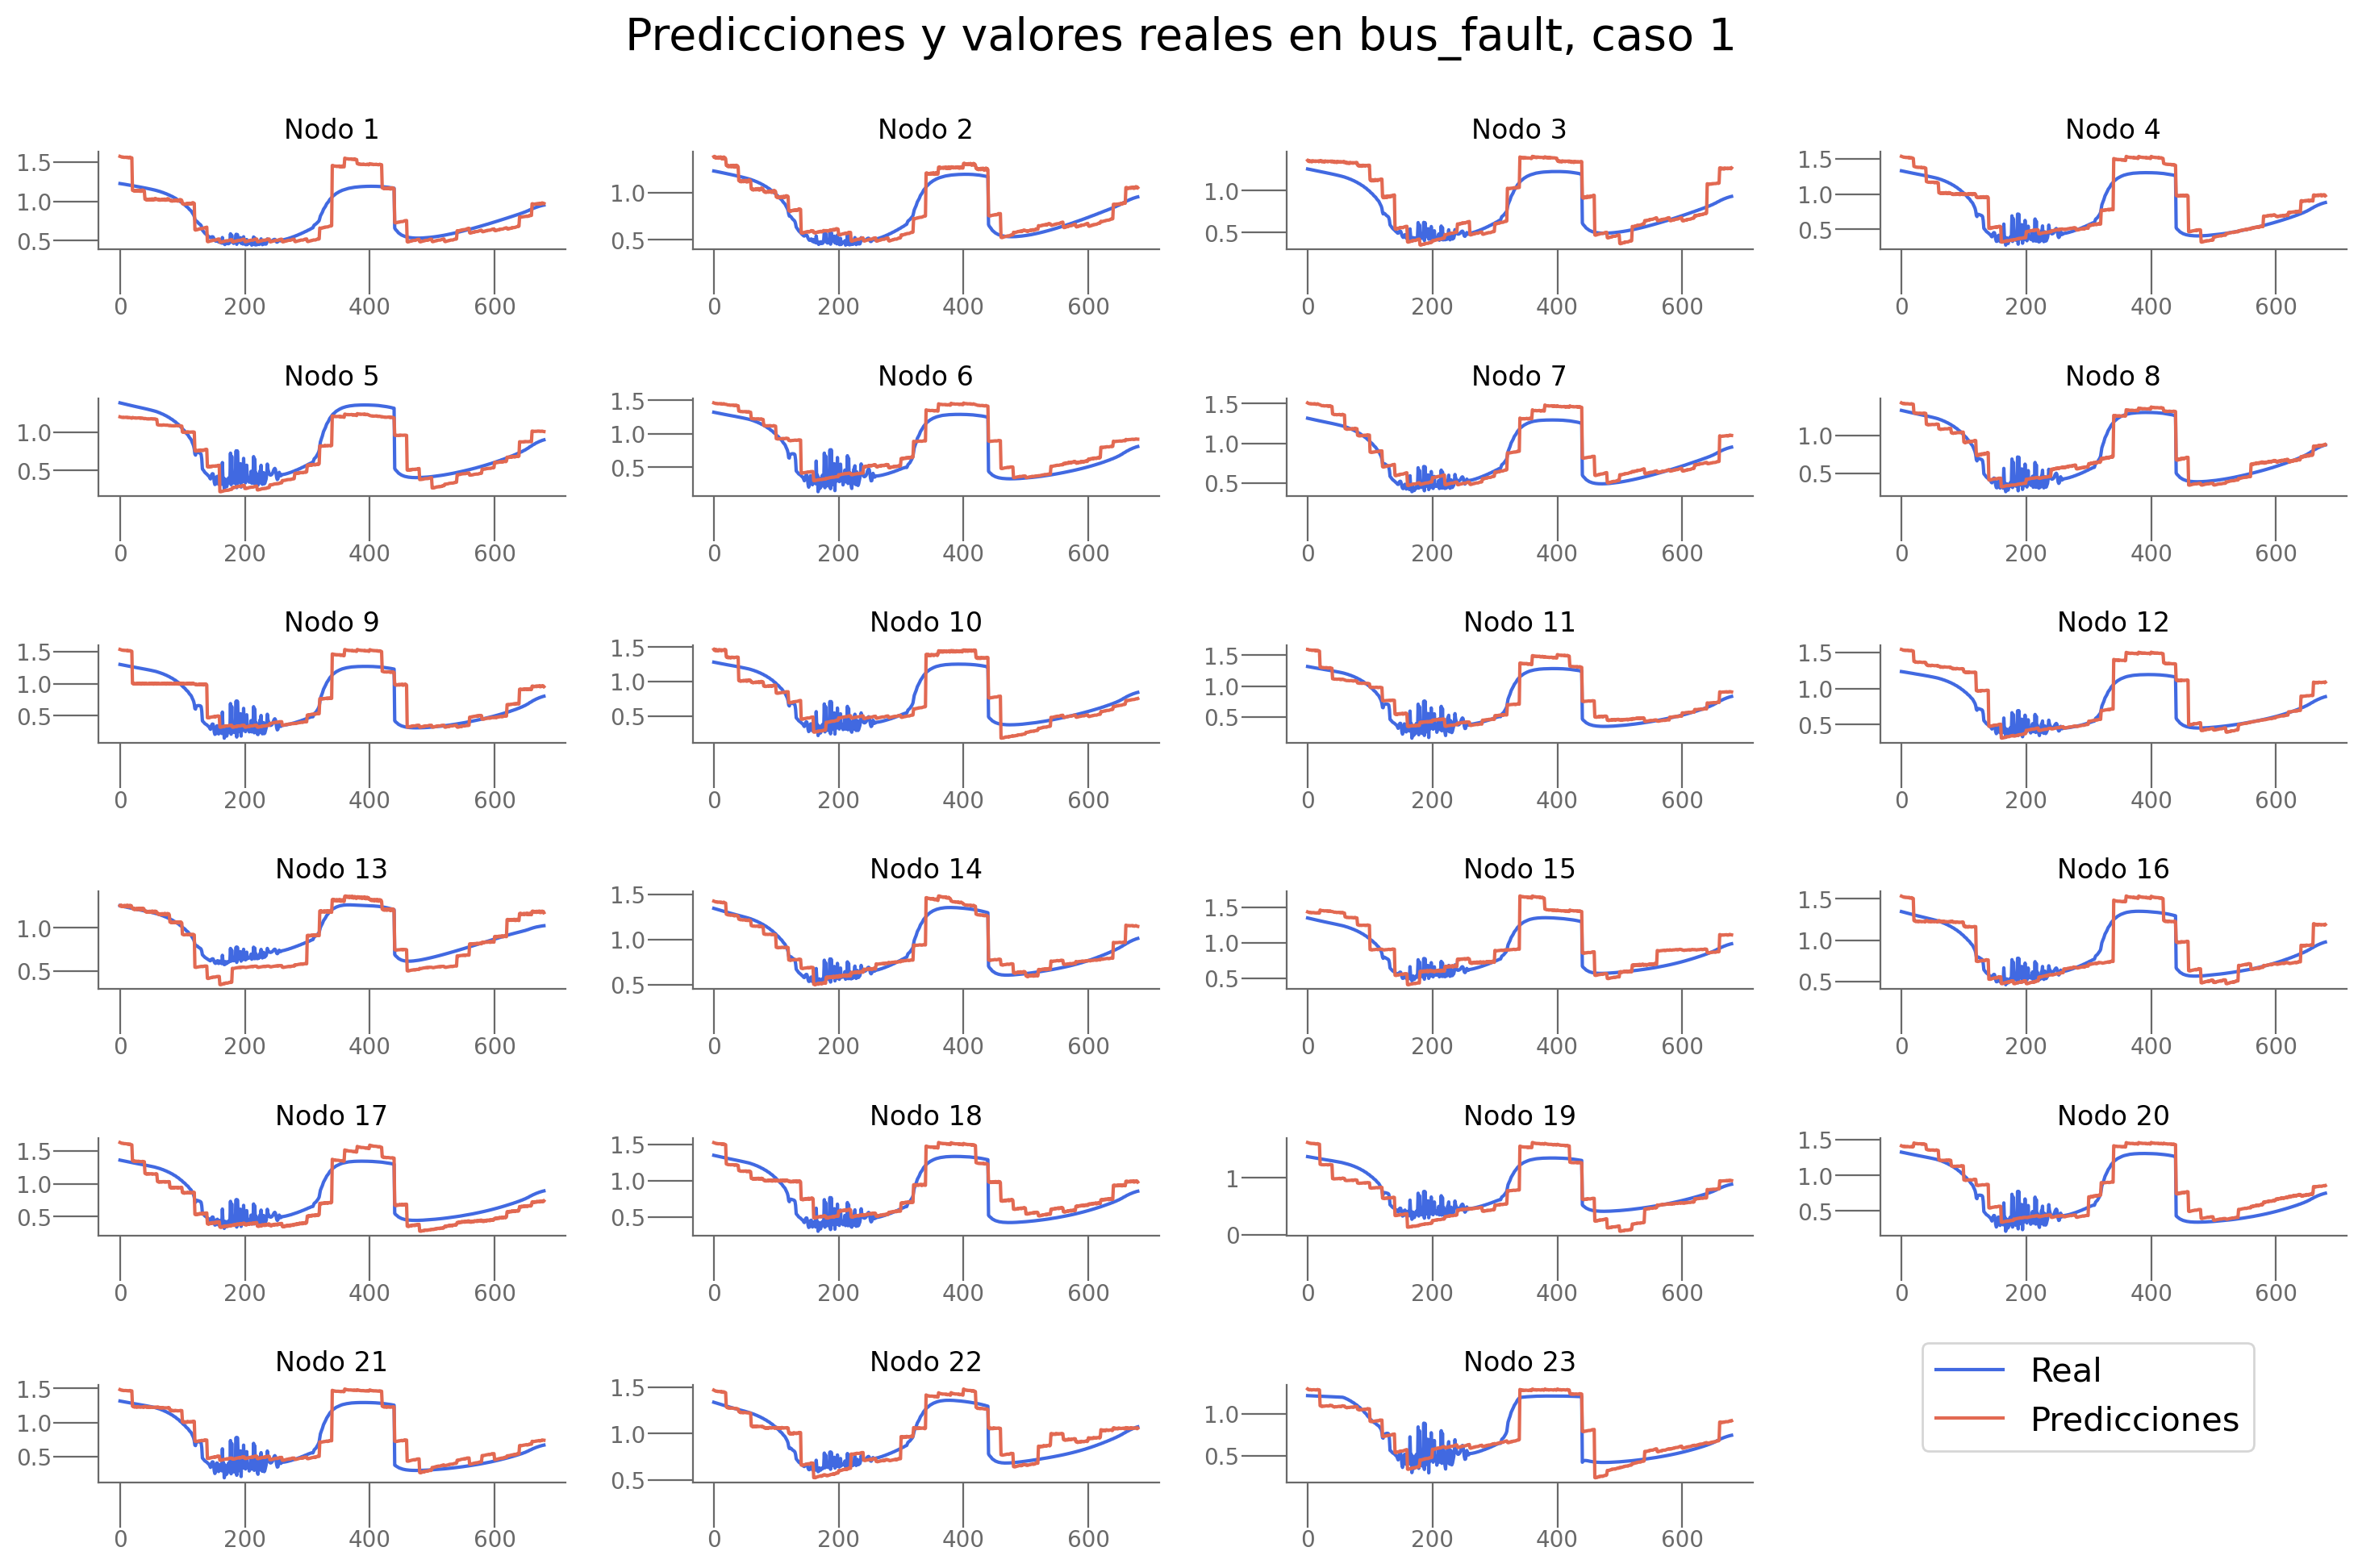

In [26]:
_,_,_, predictions_bf_ajuste,real_bf_ajuste = trainer_bf.test()
plot_predictions(predictions_bf_ajuste, real_bf_ajuste, n_target, 1, n_div_bf, problem_bf)

In [27]:
trainer_bf.save_model(path_save_experiment=path_save_experiment_bf, params = params_bf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
3   DyGrEncoder             {'aggr': 'mean', 'conv': 1, 'lstm': 1}   
4         DCRNN                                     {'hidden': 40}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
6     EvolveGCN                                                NaN   
7        ASTGCN  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_...   
8         AGCRN            {'hidden': 15, 'K': 10, 'embedding': 3}   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.017298   0.603716   
1                                                NaN  0.017459  -1.122112   
2   

### Branch Fault

In [28]:
problem_brf = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brf)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [29]:

n_div_brf = loader.div
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
embedding_dim =5

#### Sencilla 

In [74]:
model_brf = RecurrentGCN(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="AGCRN")
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model_brf.to(device)
trainer_brf = TrainerAGCRN(model_brf, dataset_brf,device, f"./results/{problem_brf}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_brf.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 432
DataLoader for val set:
Number of batches: 93
DataLoader for test set:
Number of batches: 93

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1014 | Eval Loss: 0.0667 | Eval R2: -0.4596 | 
Epoch 2/30 | Train Loss: 0.0388 | Eval Loss: 0.0514 | Eval R2: 0.0382 | 
Epoch 3/30 | Train Loss: 0.0331 | Eval Loss: 0.0471 | Eval R2: 0.1788 | 
Epoch 4/30 | Train Loss: 0.0308 | Eval Loss: 0.0415 | Eval R2: 0.3115 | 
Epoch 5/30 | Train Loss: 0.0284 | Eval Loss: 0.0444 | Eval R2: 0.2686 | 
Epoch 6/30 | Train Loss: 0.0274 | Eval Loss: 0.0410 | Eval R2: 0.3514 | 
Epoch 7/30 | Train Loss: 0.0260 | Eval Loss: 0.0390 | Eval R2: 0.3967 | 
Epoch 8/30 | Train Loss: 0.0253 | Eval Loss: 0.0362 | Eval R2: 0.4543 | 
Epoch 9/30 | Train Loss: 0.0244 | Eval Los

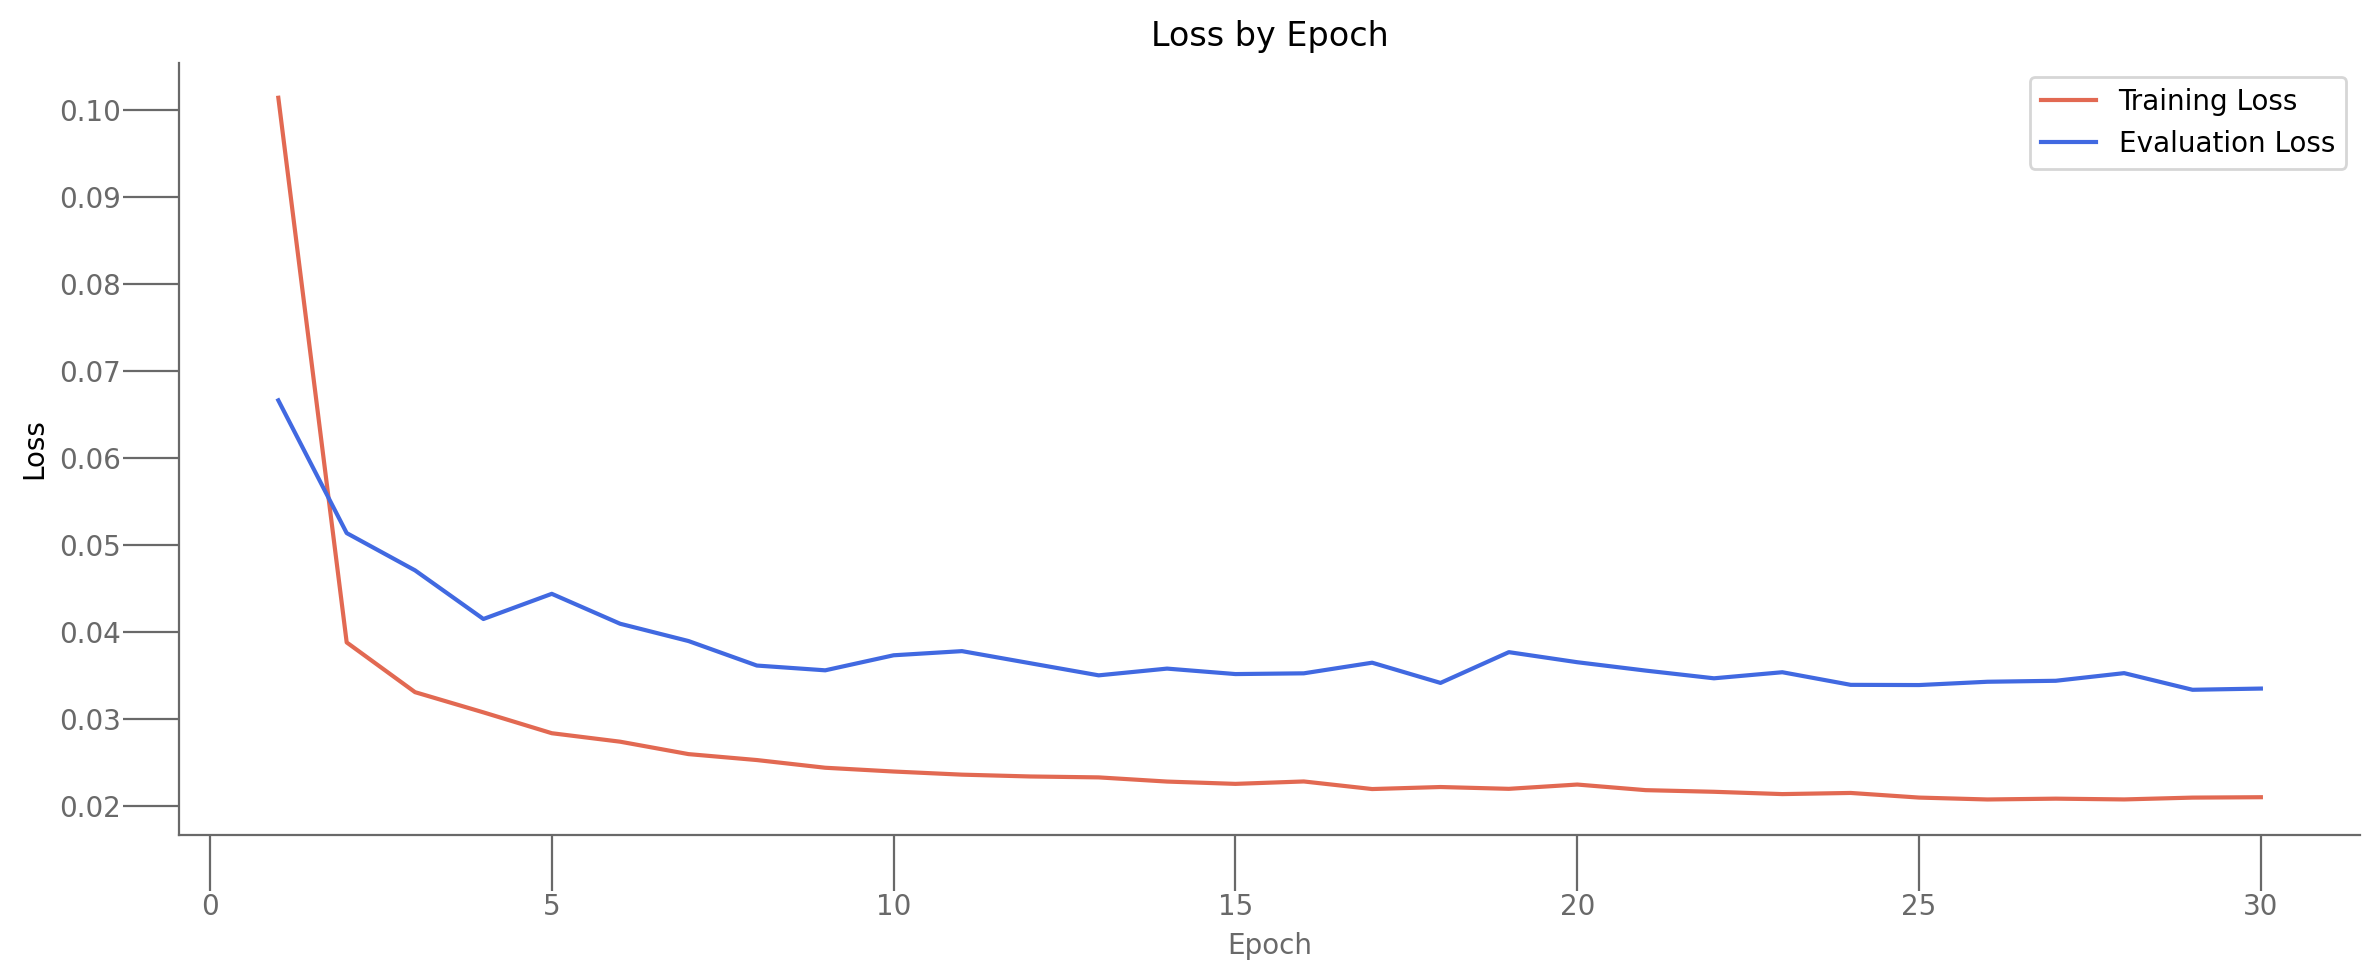


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.027778, test r2score 0.508333


In [75]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brf, real_brf = trainer_brf.test()



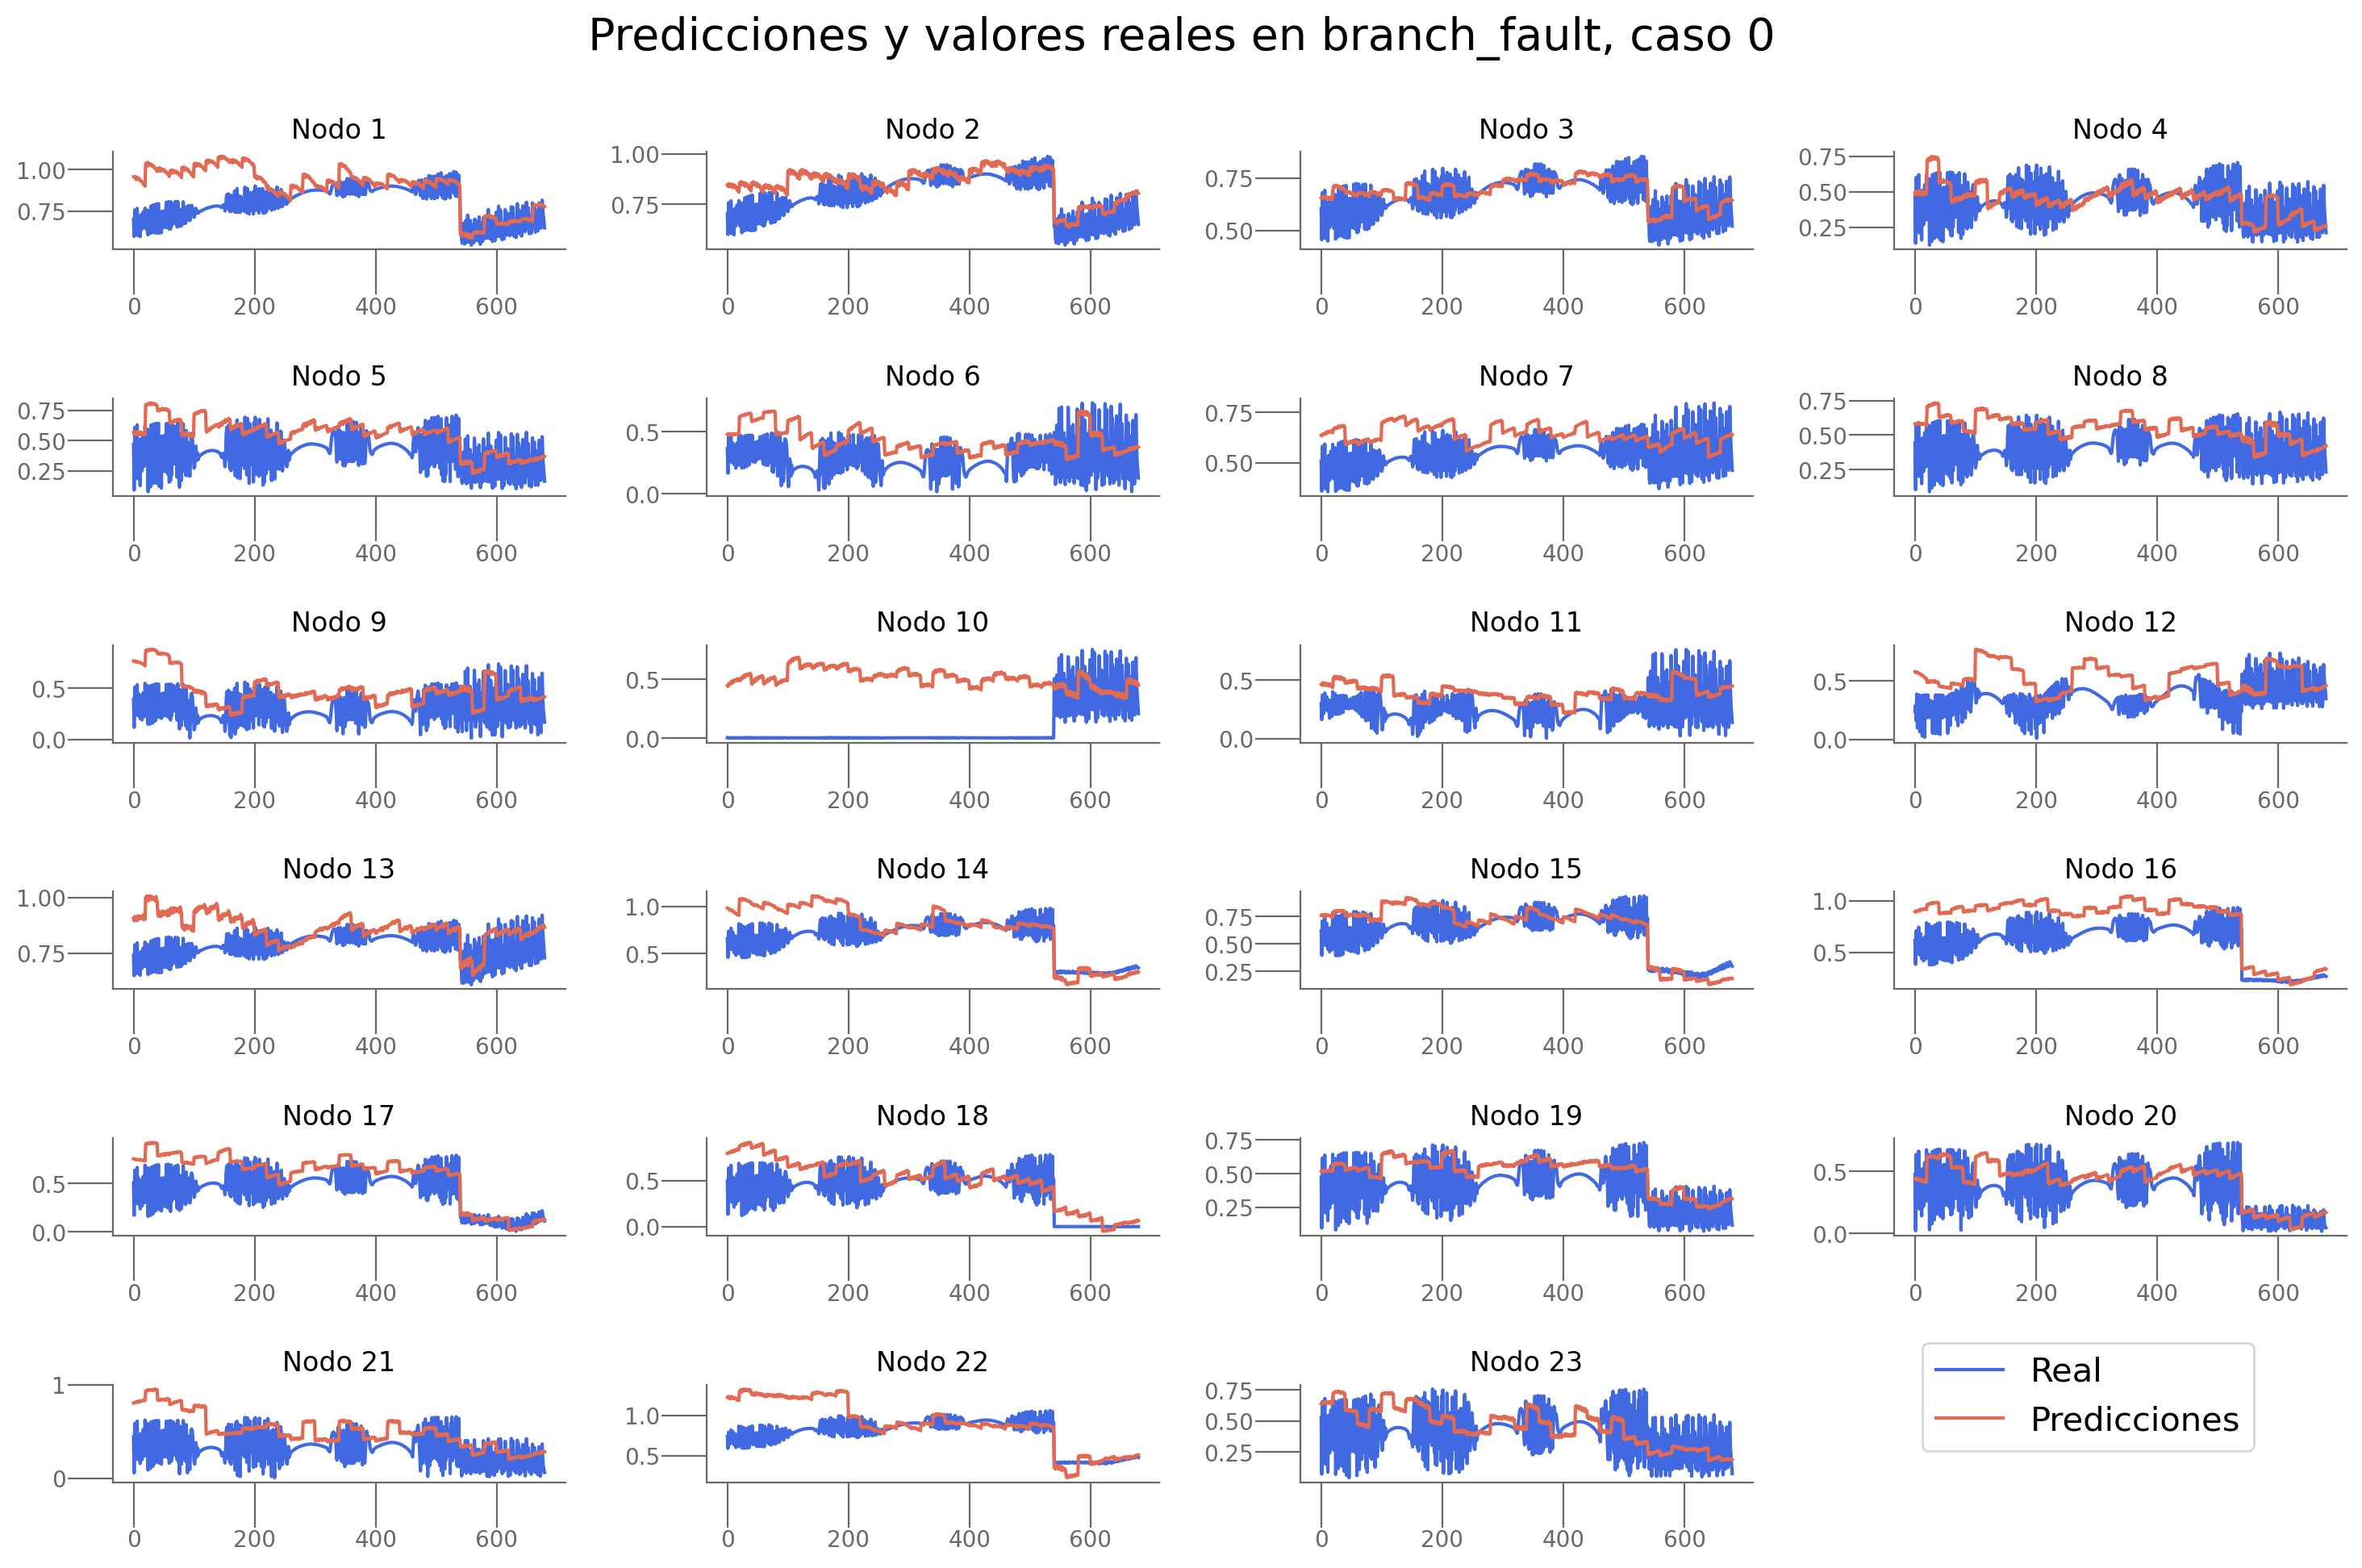

In [76]:
plot_predictions(predictions_brf, real_brf, n_target, 0, n_div_brf, problem_brf)

#### Ajuste de parámetros

In [30]:


trainer_brf,params_brf, resultados_final_brf, resultados_brf = entrenar_y_evaluar_modelos(param_grid, dataset_brf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brf)

  0%|          | 0/36 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 432
DataLoader for val set:
Number of batches: 93
DataLoader for test set:
Number of batches: 93

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2737 | Eval Loss: 0.2163 | Eval R2: -4.3709 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.1335 | Eval Loss: 0.1580 | Eval R2: -2.9217 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.1048 | Eval Loss: 0.1321 | Eval R2: -2.2694 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.0940 | Eval Loss: 0.1472 | Eval R2: -2.6107 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.0878 | Eval Loss: 0.1276 | Eval R2: -2.0902 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.0819 | Eval Loss: 0.1027 | Eval R2: -1.4711 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.0790 | Eval Loss: 0.0978 | Eval R2: -1.3505 | LR: 0.0010 | 
Epoch 8/30 | Train

  3%|▎         | 1/36 [03:32<2:03:53, 212.38s/it]

preds:  (5, 23, 20)
test loss: 0.048892, test R2 score: -0.141845
Parámetros:  3 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 3, 'Loss_final': 0.04721495881676674, 'R2_eval': -0.4195684492588043, 'Loss_eval': 0.06566847115755081, 'R2_tst': -0.1418452275081385, 'Loss_tst': 0.04889218881726265, 'Loss_nodes': [0.075149767100811, 0.0496261864900589, 0.0398152619600296, 0.04794200882315636, 0.04973050579428673, 0.04201938584446907, 0.03241162747144699, 0.03956258296966553, 0.048698436468839645, 0.05669205263257027, 0.05976651981472969, 0.03675651177763939, 0.04728716239333153, 0.05855802446603775, 0.038672707974910736, 0.030914653092622757, 0.04921765998005867, 0.055177006870508194, 0.06262312084436417, 0.06038288772106171, 0.04373181611299515, 0.052974097430706024, 0.04681042209267616]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train

  6%|▌         | 2/36 [06:57<1:58:04, 208.36s/it]

preds:  (5, 23, 20)
test loss: 0.072907, test R2 score: -0.873338
Parámetros:  3 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 3, 'Loss_final': 0.05102219432592392, 'R2_eval': -0.9300955533981323, 'Loss_eval': 0.08693337440490723, 'R2_tst': -0.8733383385520873, 'Loss_tst': 0.0729069709777832, 'Loss_nodes': [0.041890643537044525, 0.051210399717092514, 0.08050400018692017, 0.0578869953751564, 0.06475456804037094, 0.053095705807209015, 0.10548840463161469, 0.03973736613988876, 0.09010360389947891, 0.14698675274848938, 0.06047976762056351, 0.029181260615587234, 0.06673245131969452, 0.07377593964338303, 0.1073792576789856, 0.062210217118263245, 0.05469660088419914, 0.09337078779935837, 0.06782301515340805, 0.08895204216241837, 0.0694730281829834, 0.042938243597745895, 0.12818917632102966]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for trai

  8%|▊         | 3/36 [10:22<1:53:44, 206.80s/it]

preds:  (5, 23, 20)
test loss: 0.042127, test R2 score: 0.004841
Parámetros:  3 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 3, 'Loss_final': 0.05379416048526764, 'R2_eval': -0.4073841869831085, 'Loss_eval': 0.0634695366024971, 'R2_tst': 0.004841341122150203, 'Loss_tst': 0.04212718456983566, 'Loss_nodes': [0.022116683423519135, 0.018457505851984024, 0.03311845660209656, 0.03873389586806297, 0.05025024339556694, 0.04507443308830261, 0.033849265426397324, 0.03835584223270416, 0.04035310074687004, 0.04227374866604805, 0.03974763676524162, 0.031915076076984406, 0.03940807282924652, 0.045621681958436966, 0.06263317167758942, 0.045614056289196014, 0.04210321977734566, 0.057633232325315475, 0.04927181452512741, 0.05140325427055359, 0.046176787465810776, 0.05008664354681969, 0.04472750052809715]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for

 11%|█         | 4/36 [15:26<2:10:41, 245.06s/it]

preds:  (5, 23, 20)
test loss: 0.098105, test R2 score: -1.905478
Parámetros:  3 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 3, 'Loss_final': 0.06561120599508286, 'R2_eval': -1.767196536064148, 'Loss_eval': 0.11306030303239822, 'R2_tst': -1.9054777008231556, 'Loss_tst': 0.09810516238212585, 'Loss_nodes': [0.03181081265211105, 0.09145507216453552, 0.05482589080929756, 0.08580823242664337, 0.13327430188655853, 0.08350938558578491, 0.261201411485672, 0.07250610738992691, 0.16256046295166016, 0.10755805671215057, 0.04867583513259888, 0.03370469808578491, 0.10813134908676147, 0.10591256618499756, 0.08462811261415482, 0.0430360771715641, 0.09333169460296631, 0.1312422752380371, 0.12258012592792511, 0.05761357396841049, 0.09862357378005981, 0.11249712109565735, 0.13193225860595703]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:


 14%|█▍        | 5/36 [20:26<2:16:54, 264.98s/it]

preds:  (5, 23, 20)
test loss: 0.065373, test R2 score: -0.821233
Parámetros:  3 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 3, 'Loss_final': 0.06319694966077805, 'R2_eval': -1.771498441696167, 'Loss_eval': 0.11602910608053207, 'R2_tst': -0.8212331231200558, 'Loss_tst': 0.06537304818630219, 'Loss_nodes': [0.03795661777257919, 0.032196294516325, 0.0604238398373127, 0.056790634989738464, 0.07124628126621246, 0.05627501383423805, 0.12299319356679916, 0.043390970677137375, 0.06637368351221085, 0.06576098501682281, 0.05628329887986183, 0.0660828948020935, 0.045218512415885925, 0.05291799455881119, 0.07739926129579544, 0.06136767566204071, 0.06771183758974075, 0.07064241170883179, 0.0939045250415802, 0.09183231741189957, 0.06747399270534515, 0.06975953280925751, 0.06957849860191345]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set

 17%|█▋        | 6/36 [24:53<2:12:47, 265.57s/it]

preds:  (5, 23, 20)
test loss: 0.055612, test R2 score: -0.401140
Parámetros:  3 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 3, 'Loss_final': 0.06329168379306793, 'R2_eval': -0.9136808514595032, 'Loss_eval': 0.08574783056974411, 'R2_tst': -0.40113951686908034, 'Loss_tst': 0.055612336844205856, 'Loss_nodes': [0.05356273800134659, 0.08892426639795303, 0.03949146717786789, 0.044849708676338196, 0.0568157359957695, 0.06253978610038757, 0.05698293820023537, 0.05043904483318329, 0.058231696486473083, 0.042321834713220596, 0.04423937201499939, 0.03678412735462189, 0.04319492354989052, 0.052581869065761566, 0.052151910960674286, 0.05541570112109184, 0.06759972870349884, 0.07718264311552048, 0.06258586049079895, 0.06836682558059692, 0.0707455426454544, 0.052593257278203964, 0.041482798755168915]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for

 19%|█▉        | 7/36 [33:39<2:49:31, 350.76s/it]

preds:  (5, 23, 20)
test loss: 0.092492, test R2 score: -1.560196
Parámetros:  3 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 3, 'Loss_final': 0.0780518651008606, 'R2_eval': -2.9848403930664062, 'Loss_eval': 0.16137249767780304, 'R2_tst': -1.5601956603639766, 'Loss_tst': 0.09249212592840195, 'Loss_nodes': [0.04518016055226326, 0.04901263862848282, 0.06182006746530533, 0.07496638596057892, 0.11297392100095749, 0.07630955427885056, 0.10388830304145813, 0.1044878363609314, 0.08712577074766159, 0.07314037531614304, 0.11891912668943405, 0.08921875804662704, 0.06301979720592499, 0.1366981416940689, 0.13772159814834595, 0.057584572583436966, 0.07976524531841278, 0.13897976279258728, 0.11576805263757706, 0.12938418984413147, 0.0880526453256607, 0.12254197150468826, 0.06075989454984665]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set

 22%|██▏       | 8/36 [42:17<3:08:29, 403.92s/it]

preds:  (5, 23, 20)
test loss: 0.063509, test R2 score: -0.858338
Parámetros:  3 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 3, 'Loss_final': 0.0772840604186058, 'R2_eval': -1.5383732318878174, 'Loss_eval': 0.10486739873886108, 'R2_tst': -0.8583378703658038, 'Loss_tst': 0.06350928544998169, 'Loss_nodes': [0.03137442097067833, 0.060371316969394684, 0.05709419026970863, 0.06328742951154709, 0.07607077807188034, 0.08967490494251251, 0.05316710099577904, 0.05898675695061684, 0.05231687054038048, 0.055136434733867645, 0.08381439745426178, 0.05888862535357475, 0.05858400836586952, 0.07775284349918365, 0.05756080895662308, 0.04300194978713989, 0.06781705468893051, 0.07865314930677414, 0.07090520858764648, 0.08042984455823898, 0.09513963758945465, 0.045247599482536316, 0.0454384908080101]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train

 25%|██▌       | 9/36 [51:00<3:18:28, 441.04s/it]

preds:  (5, 23, 20)
test loss: 0.092557, test R2 score: -1.727328
Parámetros:  3 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 3, 'Loss_final': 0.11657371371984482, 'R2_eval': -3.0974903106689453, 'Loss_eval': 0.16138756275177002, 'R2_tst': -1.7273277737122723, 'Loss_tst': 0.09255745261907578, 'Loss_nodes': [0.14028166234493256, 0.04724712669849396, 0.09649142622947693, 0.11430108547210693, 0.10013327747583389, 0.08882385492324829, 0.11157909780740738, 0.08198723942041397, 0.1191428080201149, 0.0723806768655777, 0.11876828223466873, 0.07690340280532837, 0.03976989910006523, 0.09195557236671448, 0.08400087803602219, 0.08593697845935822, 0.11853872984647751, 0.09789155423641205, 0.0881619080901146, 0.13319960236549377, 0.10933315008878708, 0.0664120689034462, 0.04558136314153671]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:

 28%|██▊       | 10/36 [54:13<2:38:00, 364.63s/it]

preds:  (5, 23, 20)
test loss: 0.041820, test R2 score: 0.117149
Parámetros:  5 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 5, 'Loss_final': 0.036015406250953674, 'R2_eval': 0.01326860673725605, 'Loss_eval': 0.053467508405447006, 'R2_tst': 0.1171488770668827, 'Loss_tst': 0.041819795966148376, 'Loss_nodes': [0.02606889046728611, 0.014396946877241135, 0.0236247256398201, 0.02716907113790512, 0.04389152675867081, 0.04499019682407379, 0.026640823110938072, 0.0351586751639843, 0.04346151277422905, 0.03843744099140167, 0.05780172348022461, 0.031221354380249977, 0.04342089593410492, 0.049049269407987595, 0.04836541414260864, 0.03392446041107178, 0.05838068947196007, 0.06230662390589714, 0.042810261249542236, 0.05974322557449341, 0.0328989252448082, 0.044861793518066406, 0.07323096692562103]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for tr

 31%|███       | 11/36 [57:26<2:09:58, 311.93s/it]

preds:  (5, 23, 20)
test loss: 0.057046, test R2 score: -0.328941
Parámetros:  5 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 5, 'Loss_final': 0.03963811323046684, 'R2_eval': -0.454395592212677, 'Loss_eval': 0.07068078964948654, 'R2_tst': -0.32894072816692693, 'Loss_tst': 0.057046111673116684, 'Loss_nodes': [0.0323231965303421, 0.031857624650001526, 0.05142829194664955, 0.07829989492893219, 0.04678196460008621, 0.03822144493460655, 0.05496576428413391, 0.05718941241502762, 0.11217943578958511, 0.0615958534181118, 0.04597707837820053, 0.027334153652191162, 0.04296175763010979, 0.03583623096346855, 0.07119183987379074, 0.09558644145727158, 0.0593307763338089, 0.08587642759084702, 0.04880175366997719, 0.06575456261634827, 0.05547161027789116, 0.052262064069509506, 0.06083302944898605]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train

 33%|███▎      | 12/36 [1:00:37<1:50:09, 275.41s/it]

preds:  (5, 23, 20)
test loss: 0.051868, test R2 score: -0.148664
Parámetros:  5 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 5, 'Loss_final': 0.03784727305173874, 'R2_eval': -0.3366036117076874, 'Loss_eval': 0.06573981791734695, 'R2_tst': -0.14866388743829398, 'Loss_tst': 0.05186842754483223, 'Loss_nodes': [0.02056613191962242, 0.01763972081243992, 0.04043813794851303, 0.0352933369576931, 0.05235511437058449, 0.05708674341440201, 0.09003233164548874, 0.045340657234191895, 0.050051189959049225, 0.05603911355137825, 0.06164170429110527, 0.06156289204955101, 0.030309822410345078, 0.050324469804763794, 0.07253594696521759, 0.046770740300416946, 0.09046446532011032, 0.06136315315961838, 0.04096582531929016, 0.057923369109630585, 0.05171949043869972, 0.04968644306063652, 0.052863094955682755]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for

 36%|███▌      | 13/36 [1:04:52<1:43:11, 269.19s/it]

preds:  (5, 23, 20)
test loss: 0.045345, test R2 score: -0.064229
Parámetros:  5 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 5, 'Loss_final': 0.04842543974518776, 'R2_eval': -0.3354412317276001, 'Loss_eval': 0.060903385281562805, 'R2_tst': -0.0642289370708312, 'Loss_tst': 0.045344531536102295, 'Loss_nodes': [0.022757820785045624, 0.022876407951116562, 0.06245666369795799, 0.039491549134254456, 0.05416639521718025, 0.04344068095088005, 0.04007253423333168, 0.03341158106923103, 0.04560457915067673, 0.05283321812748909, 0.038295287638902664, 0.03267109394073486, 0.0399896614253521, 0.05388680472970009, 0.05026514455676079, 0.044365789741277695, 0.05994081497192383, 0.05842619389295578, 0.04481388255953789, 0.049062419682741165, 0.04091498628258705, 0.0450587160885334, 0.0681220144033432]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for t

 39%|███▉      | 14/36 [1:09:09<1:37:15, 265.25s/it]

preds:  (5, 23, 20)
test loss: 0.051706, test R2 score: -0.298685
Parámetros:  5 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 5, 'Loss_final': 0.04878617078065872, 'R2_eval': -0.5781409740447998, 'Loss_eval': 0.07355321198701859, 'R2_tst': -0.2986854967550374, 'Loss_tst': 0.05170608311891556, 'Loss_nodes': [0.030902616679668427, 0.030379733070731163, 0.052795760333538055, 0.05845429375767708, 0.04943433776497841, 0.04622746631503105, 0.05017796903848648, 0.041876088827848434, 0.05745919421315193, 0.04105936735868454, 0.05006897822022438, 0.03947732597589493, 0.03163526579737663, 0.04251287505030632, 0.05467541143298149, 0.06346873193979263, 0.07506651431322098, 0.06551172584295273, 0.08061107993125916, 0.05659536272287369, 0.06585037708282471, 0.0646812692284584, 0.040318116545677185]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for tr

 42%|████▏     | 15/36 [1:13:26<1:31:58, 262.81s/it]

preds:  (5, 23, 20)
test loss: 0.051344, test R2 score: -0.199144
Parámetros:  5 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 5, 'Loss_final': 0.05188398435711861, 'R2_eval': -0.5082157254219055, 'Loss_eval': 0.0730920061469078, 'R2_tst': -0.1991442682094962, 'Loss_tst': 0.05134390667080879, 'Loss_nodes': [0.022768273949623108, 0.01824984699487686, 0.11060501635074615, 0.06647931039333344, 0.07228395342826843, 0.05428607016801834, 0.0404156930744648, 0.042548518627882004, 0.061069637537002563, 0.03715841844677925, 0.06453390419483185, 0.06089980527758598, 0.0220206119120121, 0.049023959785699844, 0.04991024732589722, 0.04890326410531998, 0.05450114235281944, 0.06479893624782562, 0.04527080059051514, 0.06926345825195312, 0.05670485273003578, 0.03412504866719246, 0.03508917614817619]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train

 44%|████▍     | 16/36 [1:22:20<1:54:52, 344.62s/it]

preds:  (5, 23, 20)
test loss: 0.054598, test R2 score: -0.362484
Parámetros:  5 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 5, 'Loss_final': 0.055674225091934204, 'R2_eval': -0.7707027196884155, 'Loss_eval': 0.08159162104129791, 'R2_tst': -0.36248376010872185, 'Loss_tst': 0.054598476737737656, 'Loss_nodes': [0.032232675701379776, 0.03500041738152504, 0.04528285190463066, 0.04934564605355263, 0.06231801584362984, 0.05468309670686722, 0.07115042954683304, 0.05641867592930794, 0.04721178486943245, 0.04132071137428284, 0.04759823903441429, 0.03812002018094063, 0.04642418399453163, 0.04816555231809616, 0.046290576457977295, 0.043448541313409805, 0.08741283416748047, 0.1015886515378952, 0.06662506610155106, 0.06726248562335968, 0.056087613105773926, 0.050136905163526535, 0.06164003163576126]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for

 47%|████▋     | 17/36 [1:31:09<2:06:39, 399.95s/it]

preds:  (5, 23, 20)
test loss: 0.063758, test R2 score: -0.688394
Parámetros:  5 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 5, 'Loss_final': 0.06828469038009644, 'R2_eval': -1.3904786109924316, 'Loss_eval': 0.10150294005870819, 'R2_tst': -0.6883935352036871, 'Loss_tst': 0.06375829875469208, 'Loss_nodes': [0.06514905393123627, 0.042928025126457214, 0.05389270931482315, 0.04991309717297554, 0.06704097241163254, 0.0786411240696907, 0.06474360823631287, 0.04602047801017761, 0.05196626856923103, 0.06119740381836891, 0.10451295971870422, 0.054656438529491425, 0.03169018402695656, 0.07948485016822815, 0.07876621931791306, 0.05910914018750191, 0.06068127602338791, 0.09125314652919769, 0.06225141882896423, 0.07657406479120255, 0.06586083769798279, 0.046045899391174316, 0.07406160980463028]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for trai

 50%|█████     | 18/36 [1:39:53<2:11:09, 437.20s/it]

preds:  (5, 23, 20)
test loss: 0.052623, test R2 score: -0.446398
Parámetros:  5 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 5, 'Loss_final': 0.062246304005384445, 'R2_eval': -0.8870639801025391, 'Loss_eval': 0.08482126891613007, 'R2_tst': -0.44639840997791536, 'Loss_tst': 0.05262292921543121, 'Loss_nodes': [0.03624247759580612, 0.02889949083328247, 0.07206881791353226, 0.06648276001214981, 0.05630527436733246, 0.04404575005173683, 0.07123271375894547, 0.04010500758886337, 0.06802482903003693, 0.04158240556716919, 0.05579899251461029, 0.06919898837804794, 0.03622196987271309, 0.04365120828151703, 0.04134825989603996, 0.053669437766075134, 0.05694901943206787, 0.06569070369005203, 0.058351069688797, 0.07385697215795517, 0.05328524112701416, 0.036106206476688385, 0.041209783405065536]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for tra

 53%|█████▎    | 19/36 [1:43:11<1:43:31, 365.40s/it]

preds:  (5, 23, 20)
test loss: 0.055770, test R2 score: -0.238004
Parámetros:  10 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 10, 'Loss_final': 0.03035532310605049, 'R2_eval': -0.29364079236984253, 'Loss_eval': 0.06656459718942642, 'R2_tst': -0.23800406744304134, 'Loss_tst': 0.055770453065633774, 'Loss_nodes': [0.04857645183801651, 0.05449128895998001, 0.01865609921514988, 0.0732305720448494, 0.041247252374887466, 0.045137036591768265, 0.03488568961620331, 0.04278603196144104, 0.08995167165994644, 0.06018255650997162, 0.07683303207159042, 0.052036698907613754, 0.06926883012056351, 0.05872296914458275, 0.04915603995323181, 0.03347080200910568, 0.04628429561853409, 0.07156974077224731, 0.08730502426624298, 0.05770377814769745, 0.06213001161813736, 0.05931035801768303, 0.04978415369987488]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for

 56%|█████▌    | 20/36 [1:46:32<1:24:16, 316.05s/it]

preds:  (5, 23, 20)
test loss: 0.038140, test R2 score: 0.253840
Parámetros:  10 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 10, 'Loss_final': 0.0319523811340332, 'R2_eval': 0.07788790762424469, 'Loss_eval': 0.04916365444660187, 'R2_tst': 0.2538403722180656, 'Loss_tst': 0.03813962638378143, 'Loss_nodes': [0.020961565896868706, 0.020844465121626854, 0.021157534793019295, 0.04177890345454216, 0.0399128757417202, 0.044629666954278946, 0.03857405111193657, 0.032171107828617096, 0.05422819405794144, 0.03927057236433029, 0.03812149167060852, 0.028318962082266808, 0.02684912085533142, 0.03597621992230415, 0.047747302800416946, 0.04147724807262421, 0.04448520392179489, 0.056047163903713226, 0.03850604593753815, 0.04851625859737396, 0.04542789235711098, 0.03254887834191322, 0.03966069221496582]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for 

 58%|█████▊    | 21/36 [1:49:55<1:10:32, 282.16s/it]

preds:  (5, 23, 20)
test loss: 0.044729, test R2 score: 0.072587
Parámetros:  10 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 10, 'Loss_final': 0.030814209952950478, 'R2_eval': 0.021902745589613914, 'Loss_eval': 0.053792063146829605, 'R2_tst': 0.07258658919224381, 'Loss_tst': 0.04472941905260086, 'Loss_nodes': [0.01640617474913597, 0.032674241811037064, 0.03154902160167694, 0.03882969915866852, 0.04691701754927635, 0.04348500445485115, 0.0362217091023922, 0.04417631775140762, 0.059830568730831146, 0.039181459695100784, 0.04797114431858063, 0.07507030665874481, 0.030866259709000587, 0.043574415147304535, 0.049769364297389984, 0.060452546924352646, 0.04299371689558029, 0.04715516418218613, 0.050788428634405136, 0.06339309364557266, 0.0477529913187027, 0.04656296968460083, 0.033154942095279694]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader

 61%|██████    | 22/36 [1:54:42<1:06:08, 283.43s/it]

preds:  (5, 23, 20)
test loss: 0.052830, test R2 score: -0.133645
Parámetros:  10 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 10, 'Loss_final': 0.03437988832592964, 'R2_eval': -0.19240674376487732, 'Loss_eval': 0.061597563326358795, 'R2_tst': -0.13364505370121407, 'Loss_tst': 0.052830152213573456, 'Loss_nodes': [0.02257797308266163, 0.04486283287405968, 0.054934896528720856, 0.03882315009832382, 0.04531111940741539, 0.06599121540784836, 0.03644730523228645, 0.06093218922615051, 0.0403316505253315, 0.04085320979356766, 0.051380470395088196, 0.03575959429144859, 0.082936592400074, 0.05857442691922188, 0.05470074340701103, 0.031987812370061874, 0.08403703570365906, 0.08007778227329254, 0.07613293081521988, 0.05462139472365379, 0.04471661522984505, 0.05283902958035469, 0.05626364052295685]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for 

 64%|██████▍   | 23/36 [1:59:23<1:01:16, 282.81s/it]

preds:  (5, 23, 20)
test loss: 0.039409, test R2 score: 0.202660
Parámetros:  10 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 10, 'Loss_final': 0.04146843031048775, 'R2_eval': -0.06510477513074875, 'Loss_eval': 0.05624290183186531, 'R2_tst': 0.20265971647840564, 'Loss_tst': 0.03940948471426964, 'Loss_nodes': [0.020727097988128662, 0.02291097864508629, 0.033596061170101166, 0.04213354364037514, 0.038357947021722794, 0.04591413587331772, 0.035920288413763046, 0.038411714136600494, 0.049300163984298706, 0.03719405457377434, 0.044422753155231476, 0.032800499349832535, 0.020066391676664352, 0.03417057543992996, 0.04105216637253761, 0.05385584011673927, 0.040818952023983, 0.04844554886221886, 0.04614902287721634, 0.0530475489795208, 0.04605427011847496, 0.0418807752430439, 0.03918786346912384]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for

 67%|██████▋   | 24/36 [2:04:05<56:32, 282.72s/it]  

preds:  (5, 23, 20)
test loss: 0.048357, test R2 score: -0.145332
Parámetros:  10 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 10, 'Loss_final': 0.0386260561645031, 'R2_eval': -0.26929929852485657, 'Loss_eval': 0.0654161348938942, 'R2_tst': -0.1453320463269762, 'Loss_tst': 0.048357490450143814, 'Loss_nodes': [0.020360762253403664, 0.039509035646915436, 0.03476838767528534, 0.05841827392578125, 0.0878603532910347, 0.05071578547358513, 0.048287566751241684, 0.04534902423620224, 0.05663111060857773, 0.03877760097384453, 0.05507967993617058, 0.043112486600875854, 0.02620816044509411, 0.03590651974081993, 0.04565436765551567, 0.04837733507156372, 0.0744662806391716, 0.06445252895355225, 0.05315135791897774, 0.0565200001001358, 0.051381438970565796, 0.040854815393686295, 0.03637949749827385]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for t

 69%|██████▉   | 25/36 [2:14:39<1:11:06, 387.86s/it]

preds:  (5, 23, 20)
test loss: 0.051747, test R2 score: -0.187749
Parámetros:  10 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 10, 'Loss_final': 0.045361585915088654, 'R2_eval': -0.33726686239242554, 'Loss_eval': 0.0703670009970665, 'R2_tst': -0.1877485157832639, 'Loss_tst': 0.05174669623374939, 'Loss_nodes': [0.05859590694308281, 0.02385743521153927, 0.0341615229845047, 0.05371960625052452, 0.07024548947811127, 0.06221283972263336, 0.06667805463075638, 0.041764743626117706, 0.05875817686319351, 0.04980764538049698, 0.05258175730705261, 0.04413069039583206, 0.02482684887945652, 0.04533202573657036, 0.04896148666739464, 0.06776934117078781, 0.06263913959264755, 0.05537339299917221, 0.052158862352371216, 0.07194551080465317, 0.05948062241077423, 0.03905688226222992, 0.04611620306968689]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for tr

 72%|███████▏  | 26/36 [2:24:57<1:16:09, 457.00s/it]

preds:  (5, 23, 20)
test loss: 0.051626, test R2 score: -0.251133
Parámetros:  10 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 10, 'Loss_final': 0.046946097165346146, 'R2_eval': -0.4981585144996643, 'Loss_eval': 0.0736180767416954, 'R2_tst': -0.2511326298592904, 'Loss_tst': 0.05162637308239937, 'Loss_nodes': [0.027639135718345642, 0.032891739159822464, 0.0450955405831337, 0.04292747378349304, 0.052804604172706604, 0.05740039423108101, 0.07885535806417465, 0.047703202813863754, 0.04884452745318413, 0.053386665880680084, 0.050738584250211716, 0.044031064957380295, 0.06248823180794716, 0.04509780555963516, 0.05866985768079758, 0.04601743072271347, 0.06630421429872513, 0.05764119327068329, 0.060935672372579575, 0.060238029807806015, 0.05102254077792168, 0.03494344651699066, 0.06172983720898628]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader 

 75%|███████▌  | 27/36 [2:35:15<1:15:48, 505.40s/it]

preds:  (5, 23, 20)
test loss: 0.061979, test R2 score: -0.559037
Parámetros:  10 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 10, 'Loss_final': 0.05441386625170708, 'R2_eval': -0.9331383109092712, 'Loss_eval': 0.08706297725439072, 'R2_tst': -0.5590365870840377, 'Loss_tst': 0.06197897717356682, 'Loss_nodes': [0.04144639894366264, 0.13986894488334656, 0.036712806671857834, 0.0533650666475296, 0.12912072241306305, 0.05980861932039261, 0.09087467938661575, 0.04204457625746727, 0.0635160580277443, 0.04737290367484093, 0.04807763546705246, 0.03942615166306496, 0.03358817100524902, 0.053934574127197266, 0.04930433630943298, 0.07925631105899811, 0.06458533555269241, 0.0686192512512207, 0.059448227286338806, 0.0694422498345375, 0.06702127307653427, 0.048496637493371964, 0.04018559679389]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train s

 78%|███████▊  | 28/36 [2:39:05<56:22, 422.79s/it]  

preds:  (5, 23, 20)
test loss: 0.045061, test R2 score: 0.141964
Parámetros:  15 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 15, 'Loss_final': 0.028270943090319633, 'R2_eval': 0.01189251895993948, 'Loss_eval': 0.055292561650276184, 'R2_tst': 0.14196403277902608, 'Loss_tst': 0.04506070166826248, 'Loss_nodes': [0.037229131907224655, 0.052306707948446274, 0.01642339676618576, 0.04294709861278534, 0.04059714451432228, 0.052075739949941635, 0.027948623523116112, 0.037248414009809494, 0.051991354674100876, 0.039058491587638855, 0.06189841777086258, 0.03821757063269615, 0.027659211307764053, 0.05902727320790291, 0.057096049189567566, 0.03784584999084473, 0.047851771116256714, 0.0425921194255352, 0.04166865721344948, 0.06191333010792732, 0.04825562983751297, 0.058061037212610245, 0.056483082473278046]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoa

 81%|████████  | 29/36 [2:42:45<42:12, 361.82s/it]

preds:  (5, 23, 20)
test loss: 0.041861, test R2 score: 0.202934
Parámetros:  15 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 15, 'Loss_final': 0.028806308284401894, 'R2_eval': -0.018408609554171562, 'Loss_eval': 0.05532221496105194, 'R2_tst': 0.20293417896341218, 'Loss_tst': 0.04186052829027176, 'Loss_nodes': [0.01927364058792591, 0.02688664011657238, 0.024907603859901428, 0.039445046335458755, 0.039413753896951675, 0.055622681975364685, 0.027956195175647736, 0.035673510283231735, 0.05127333104610443, 0.035073310136795044, 0.04933394491672516, 0.028438055887818336, 0.028803648427128792, 0.0803908109664917, 0.06284517049789429, 0.04325083643198013, 0.04217839613556862, 0.044816628098487854, 0.04166145250201225, 0.05631446838378906, 0.05039336532354355, 0.037497248500585556, 0.041342463344335556]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLo

 83%|████████▎ | 30/36 [2:46:28<32:01, 320.28s/it]

preds:  (5, 23, 20)
test loss: 0.048854, test R2 score: -0.011449
Parámetros:  15 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 15, 'Loss_final': 0.030477968975901604, 'R2_eval': -0.18953585624694824, 'Loss_eval': 0.06118392571806908, 'R2_tst': -0.011449315790045007, 'Loss_tst': 0.04885431379079819, 'Loss_nodes': [0.02342972718179226, 0.01929280534386635, 0.047866519540548325, 0.038815852254629135, 0.060647908598184586, 0.03942730277776718, 0.060978423804044724, 0.03371204063296318, 0.05180906131863594, 0.030534783378243446, 0.07223056256771088, 0.03970424458384514, 0.022169312462210655, 0.0539063885807991, 0.05895582213997841, 0.08437494188547134, 0.07427655160427094, 0.06706534326076508, 0.05094827711582184, 0.05436679720878601, 0.053821805864572525, 0.04008196294307709, 0.045232828706502914]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoad

 86%|████████▌ | 31/36 [2:52:13<27:17, 327.58s/it]

preds:  (5, 23, 20)
test loss: 0.057878, test R2 score: -0.282926
Parámetros:  15 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 15, 'Loss_final': 0.033491019159555435, 'R2_eval': -0.5204313397407532, 'Loss_eval': 0.07301069051027298, 'R2_tst': -0.28292583403465266, 'Loss_tst': 0.05787834897637367, 'Loss_nodes': [0.03720327839255333, 0.07785023748874664, 0.03119019791483879, 0.050797298550605774, 0.05248735100030899, 0.09657437354326248, 0.04020622372627258, 0.06179751455783844, 0.04265255481004715, 0.05657958984375, 0.048686884343624115, 0.03357236459851265, 0.028652982786297798, 0.09915679693222046, 0.09712422639131546, 0.03347877040505409, 0.05748267471790314, 0.07536622881889343, 0.07527274638414383, 0.05805099010467529, 0.04960592836141586, 0.08371298760175705, 0.04369983822107315]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for tr

 89%|████████▉ | 32/36 [2:57:44<21:55, 328.77s/it]

preds:  (5, 23, 20)
test loss: 0.050111, test R2 score: -0.064441
Parámetros:  15 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 15, 'Loss_final': 0.037104301154613495, 'R2_eval': -0.3188733458518982, 'Loss_eval': 0.06835716217756271, 'R2_tst': -0.06444115815123684, 'Loss_tst': 0.050111349672079086, 'Loss_nodes': [0.058669187128543854, 0.02975727990269661, 0.04213317111134529, 0.05117959529161453, 0.05729035288095474, 0.06469579041004181, 0.04780330881476402, 0.04719536378979683, 0.04887804761528969, 0.04133525863289833, 0.0467156320810318, 0.05096268281340599, 0.020407404750585556, 0.05429055169224739, 0.09221993386745453, 0.04179605469107628, 0.050731539726257324, 0.07273104041814804, 0.05435839667916298, 0.06159404665231705, 0.041208282113075256, 0.029924100264906883, 0.04668398201465607]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader f

 92%|█████████▏| 33/36 [3:03:17<16:29, 329.99s/it]

preds:  (5, 23, 20)
test loss: 0.052640, test R2 score: -0.134966
Parámetros:  15 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 15, 'Loss_final': 0.037348613142967224, 'R2_eval': -0.34246617555618286, 'Loss_eval': 0.0675005167722702, 'R2_tst': -0.13496624202694912, 'Loss_tst': 0.05263989418745041, 'Loss_nodes': [0.02585630863904953, 0.05624387413263321, 0.03765632584691048, 0.041920773684978485, 0.05141202732920647, 0.05761025473475456, 0.034851718693971634, 0.051975131034851074, 0.047399986535310745, 0.06346125900745392, 0.06235283240675926, 0.035097088664770126, 0.03025750443339348, 0.06697101145982742, 0.048741720616817474, 0.10302695631980896, 0.045654840767383575, 0.05910075083374977, 0.058473002165555954, 0.0794152021408081, 0.06381388753652573, 0.0462971031665802, 0.043127961456775665]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader

 94%|█████████▍| 34/36 [3:15:30<15:01, 450.73s/it]

preds:  (5, 23, 20)
test loss: 0.042684, test R2 score: 0.072725
Parámetros:  15 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 15, 'Loss_final': 0.03957154229283333, 'R2_eval': -0.12727804481983185, 'Loss_eval': 0.05680835247039795, 'R2_tst': 0.072725272006514, 'Loss_tst': 0.04268386587500572, 'Loss_nodes': [0.0283524040132761, 0.02597142569720745, 0.03492456302046776, 0.05549290403723717, 0.05140341818332672, 0.046227142214775085, 0.038540422916412354, 0.0474170446395874, 0.049648698419332504, 0.03776552900671959, 0.04292137548327446, 0.03122645802795887, 0.025653595104813576, 0.03716079518198967, 0.04164417088031769, 0.042099591344594955, 0.05839279666543007, 0.05790116265416145, 0.05291994288563728, 0.050080448389053345, 0.054464176297187805, 0.03111131489276886, 0.04040951281785965]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for t

 97%|█████████▋| 35/36 [3:27:05<08:44, 524.08s/it]

preds:  (5, 23, 20)
test loss: 0.051648, test R2 score: -0.137092
Parámetros:  15 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 15, 'Loss_final': 0.041701070964336395, 'R2_eval': -0.3381552994251251, 'Loss_eval': 0.0659068301320076, 'R2_tst': -0.1370919179388834, 'Loss_tst': 0.051648203283548355, 'Loss_nodes': [0.026894189417362213, 0.02560180239379406, 0.028648989275097847, 0.05316474288702011, 0.07212609797716141, 0.05939806252717972, 0.06365064531564713, 0.04226778820157051, 0.05578799545764923, 0.037695206701755524, 0.06622761487960815, 0.04276823624968529, 0.02592146210372448, 0.06085871160030365, 0.059692367911338806, 0.054173268377780914, 0.049624282866716385, 0.06860988587141037, 0.07783520966768265, 0.06382753700017929, 0.05975472927093506, 0.04235754534602165, 0.05102221667766571]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader f

100%|██████████| 36/36 [3:38:43<00:00, 364.55s/it]

preds:  (5, 23, 20)
test loss: 0.055582, test R2 score: -0.309414
Parámetros:  15 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 15, 'Loss_final': 0.045938484370708466, 'R2_eval': -0.5832973122596741, 'Loss_eval': 0.07287164032459259, 'R2_tst': -0.3094142594181732, 'Loss_tst': 0.05558175966143608, 'Loss_nodes': [0.025706112384796143, 0.02619953826069832, 0.07667572051286697, 0.062030304223299026, 0.06162913516163826, 0.04986649751663208, 0.052512798458337784, 0.05127101391553879, 0.060603413730859756, 0.05827917158603668, 0.1098802238702774, 0.05088220164179802, 0.025708196684718132, 0.062465693801641464, 0.06129373610019684, 0.05730399116873741, 0.06886718422174454, 0.06088296324014664, 0.05285825580358505, 0.077634297311306, 0.04519939795136452, 0.03807569667696953, 0.04255500063300133]}


In [31]:
path_save_experiment_brf = results_save_path+f"/{problem_brf}"+ f"/ajustes/{name_model}_results.csv"
resultados_brf.to_csv(path_save_experiment_brf, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.038140, test R2 score: 0.253840


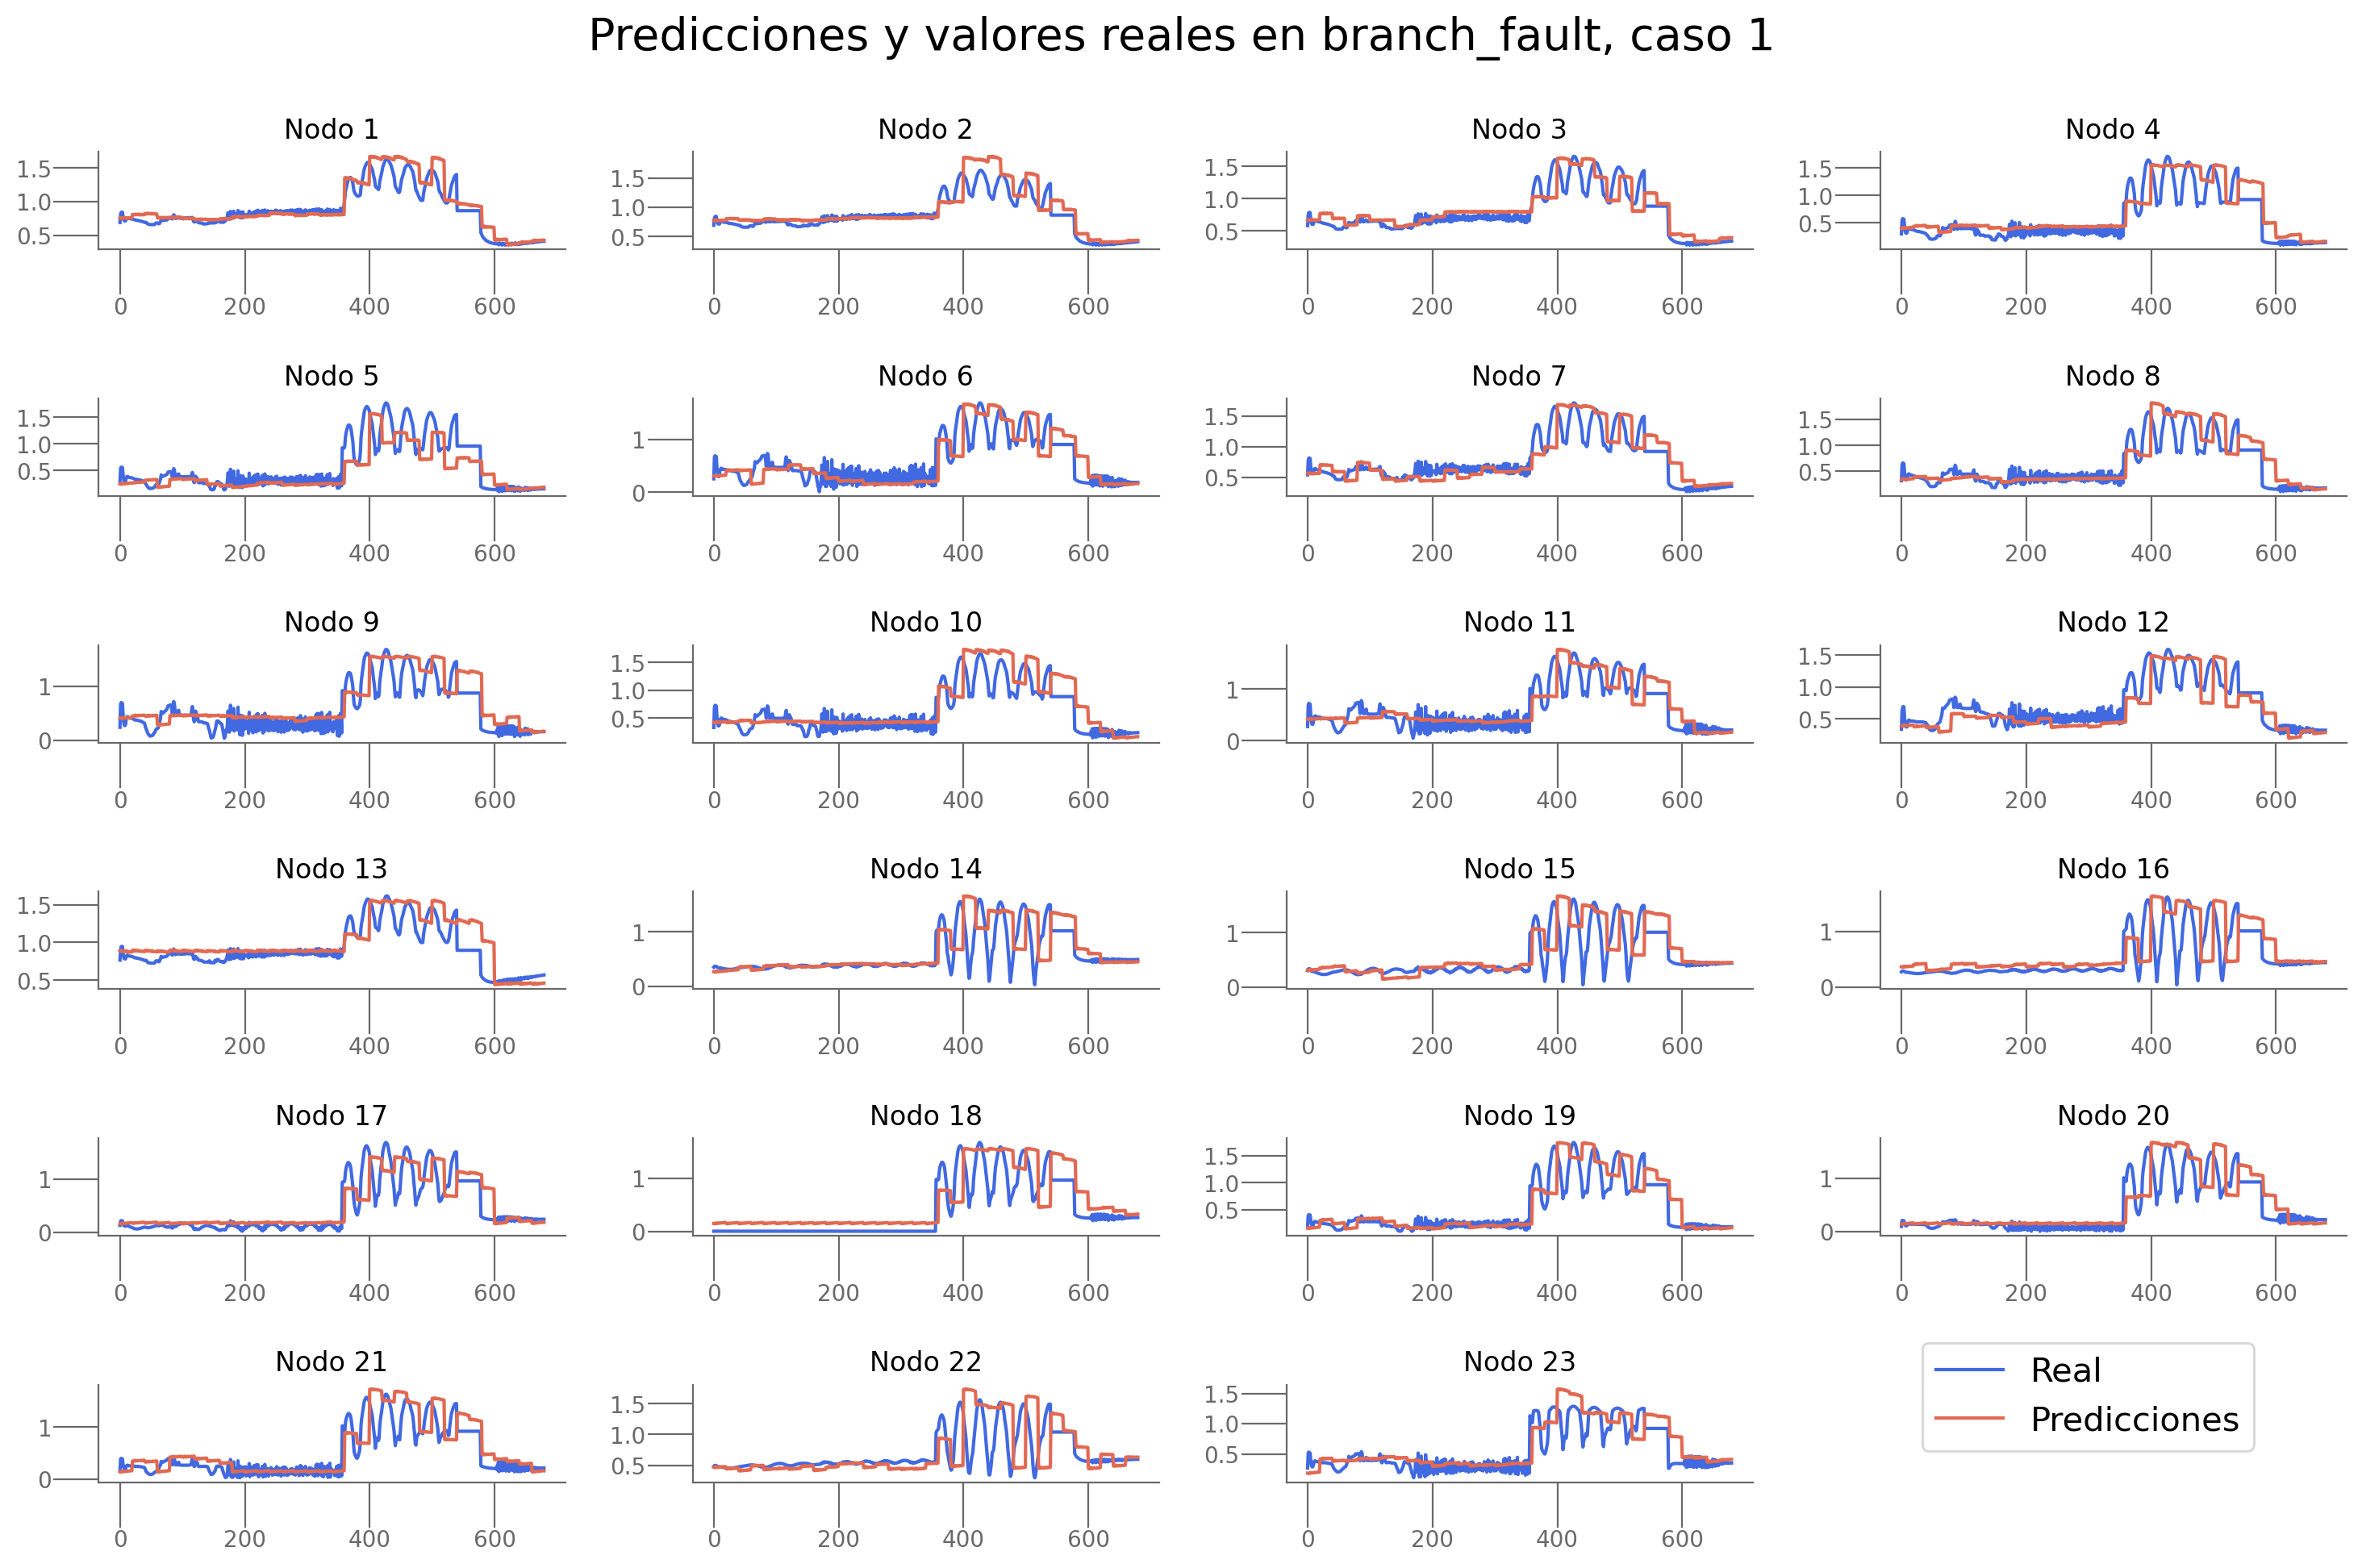

In [32]:
_,_,_, predictions_brf_ajuste,real_brf_ajuste = trainer_brf.test()
plot_predictions(predictions_brf_ajuste, real_brf_ajuste, n_target, 1, n_div_brf, problem_brf)

In [33]:
trainer_brf.save_model(path_save_experiment=path_save_experiment_brf, params = params_brf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
3     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
4         DCRNN                                     {'hidden': 60}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
6     EvolveGCN                                                NaN   
7        ASTGCN                                                NaN   
8         AGCRN            {'hidden': 10, 'K': 10, 'embedding': 3}   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.023216   0.608045   
1                                                NaN  0.021628  -1.528487   
2  .

### Branch trip

In [34]:
problem_brt = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [35]:

n_div_brt = loader.div
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
embedding_dim =5

#### Sencilla 

In [83]:
model_brt = RecurrentGCN(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="AGCRN")
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model_brt.to(device)
trainer_brt = TrainerAGCRN(model_brt, dataset_brt,device, f"./results/{problem_brt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_brt.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 477
DataLoader for val set:
Number of batches: 102
DataLoader for test set:
Number of batches: 101

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1003 | Eval Loss: 0.0262 | Eval R2: -4.0592 | 
Epoch 2/30 | Train Loss: 0.0161 | Eval Loss: 0.0175 | Eval R2: -3.8412 | 
Epoch 3/30 | Train Loss: 0.0110 | Eval Loss: 0.0146 | Eval R2: -3.2269 | 
Epoch 4/30 | Train Loss: 0.0092 | Eval Loss: 0.0136 | Eval R2: -3.1816 | 
Epoch 5/30 | Train Loss: 0.0084 | Eval Loss: 0.0123 | Eval R2: -2.7259 | 
Epoch 6/30 | Train Loss: 0.0078 | Eval Loss: 0.0122 | Eval R2: -2.7709 | 
Epoch 7/30 | Train Loss: 0.0074 | Eval Loss: 0.0110 | Eval R2: -2.1012 | 
Epoch 8/30 | Train Loss: 0.0069 | Eval Loss: 0.0114 | Eval R2: -2.2568 | 
Epoch 9/30 | Train Loss: 0.0068 |

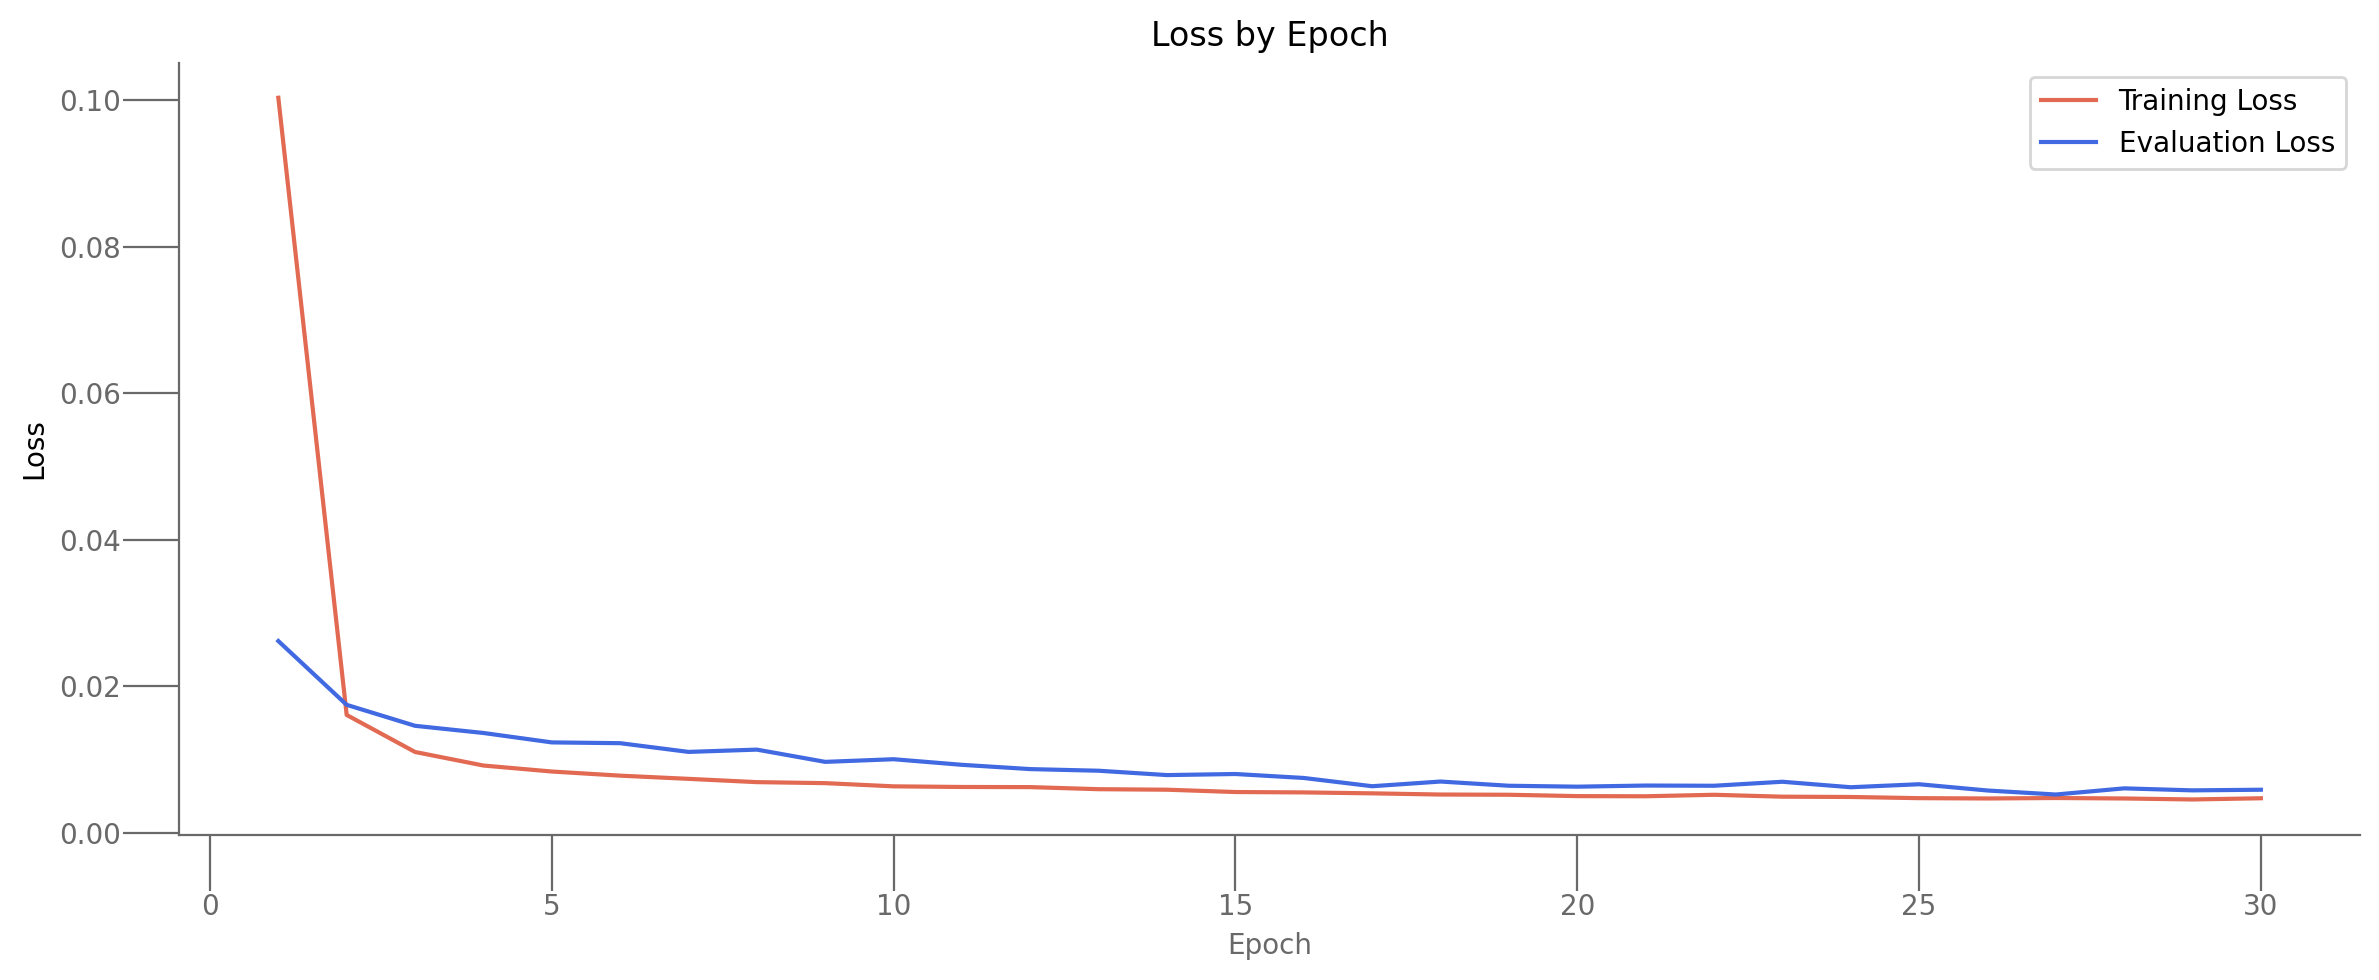


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.006017, test r2score -0.386800


In [84]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brt, real_brt = trainer_brt.test()



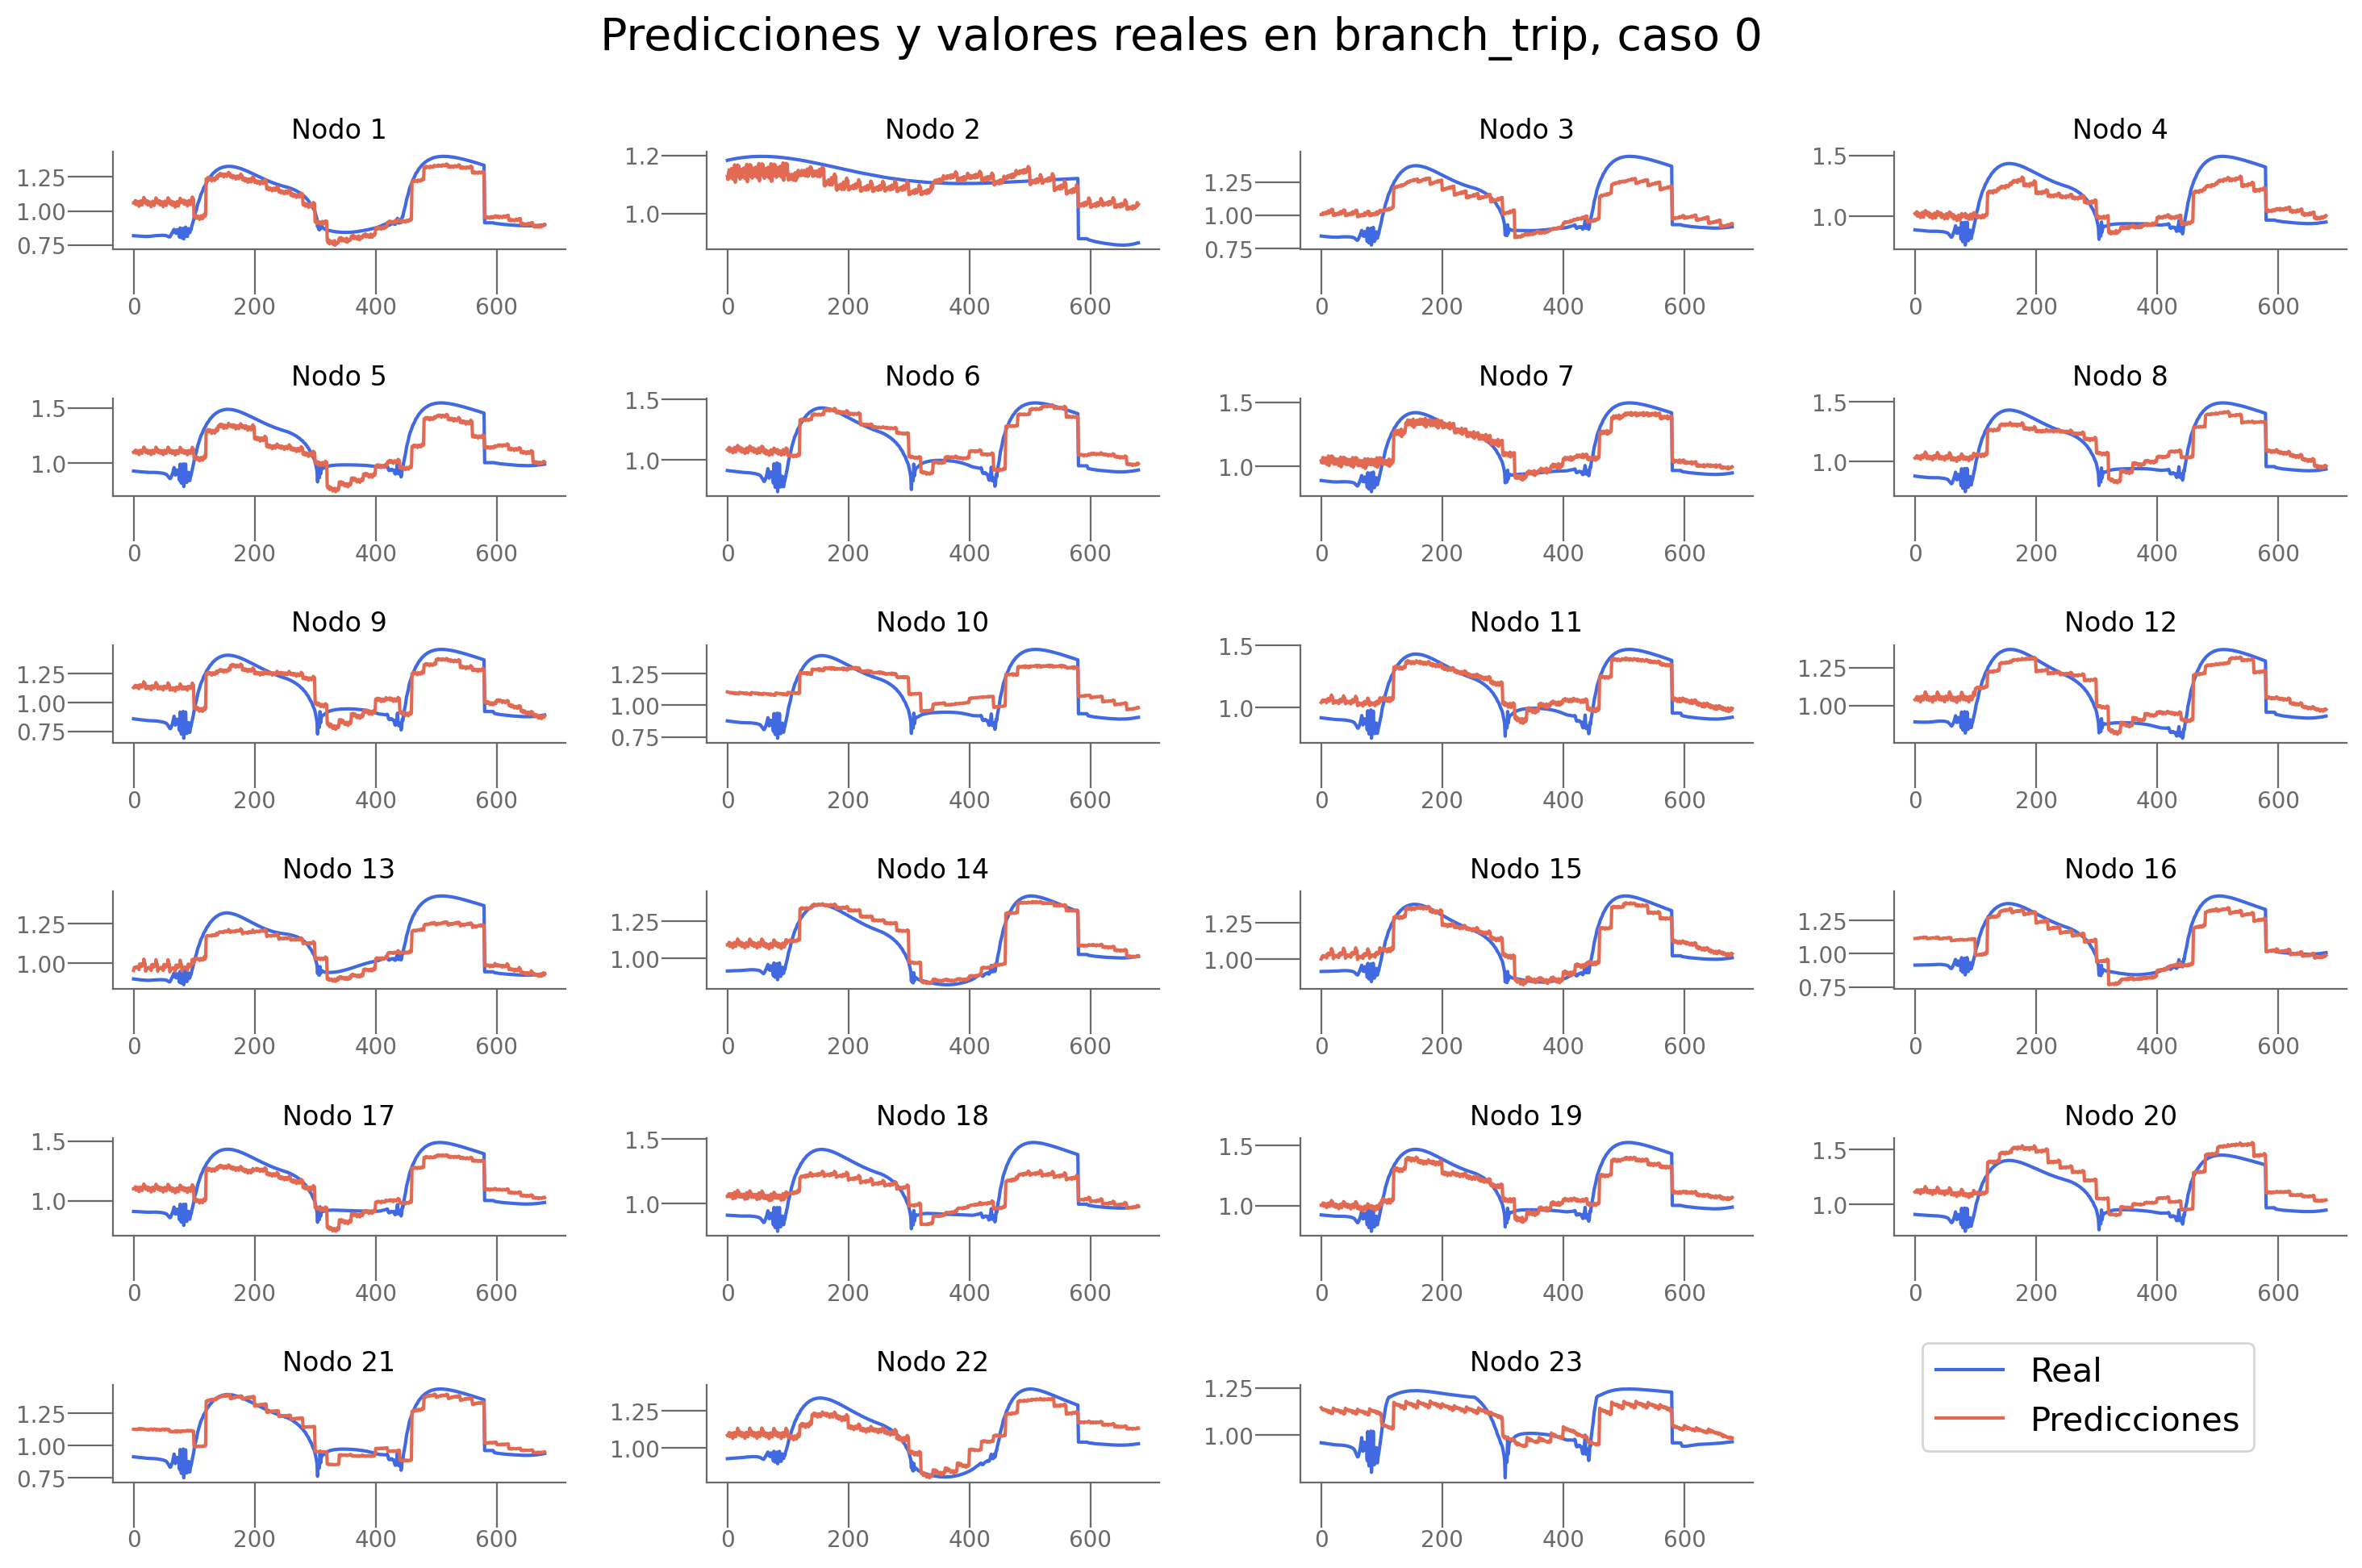

In [85]:
plot_predictions(predictions_brt, real_brt, n_target, 0, n_div_brt, problem_brt)

#### Ajuste de parámetros

In [36]:

trainer_brt,params_brt, resultados_final_brt, resultados_brt = entrenar_y_evaluar_modelos(param_grid, dataset_brt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brt)

  0%|          | 0/36 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 477
DataLoader for val set:
Number of batches: 102
DataLoader for test set:
Number of batches: 101

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.4481 | Eval Loss: 0.2133 | Eval R2: -72.1614 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.1406 | Eval Loss: 0.1121 | Eval R2: -33.3134 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.0837 | Eval Loss: 0.0859 | Eval R2: -24.0066 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.0622 | Eval Loss: 0.0632 | Eval R2: -15.8246 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.0521 | Eval Loss: 0.0532 | Eval R2: -11.9496 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.0449 | Eval Loss: 0.0450 | Eval R2: -9.1202 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.0398 | Eval Loss: 0.0388 | Eval R2: -7.1711 | LR: 0.0010 | 
Epoch 8/30 

  3%|▎         | 1/36 [04:17<2:30:05, 257.29s/it]

preds:  (5, 23, 20)
test loss: 0.021882, test R2 score: -3.077484
Parámetros:  3 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 3, 'Loss_final': 0.02114197239279747, 'R2_eval': -2.788412094116211, 'Loss_eval': 0.019945383071899414, 'R2_tst': -3.0774843675813526, 'Loss_tst': 0.021881554275751114, 'Loss_nodes': [0.012288852594792843, 0.01171821728348732, 0.022500088438391685, 0.025822840631008148, 0.031568657606840134, 0.021219834685325623, 0.02120271511375904, 0.015704255551099777, 0.024021059274673462, 0.020288508385419846, 0.02515983395278454, 0.016643041744828224, 0.016207899898290634, 0.01252147275954485, 0.014253707602620125, 0.01126116793602705, 0.023483123630285263, 0.023811815306544304, 0.015381868928670883, 0.0207847747951746, 0.026619432494044304, 0.015134870074689388, 0.07567770779132843]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataL

  6%|▌         | 2/36 [08:39<2:27:35, 260.45s/it]

preds:  (5, 23, 20)
test loss: 0.028572, test R2 score: -4.074913
Parámetros:  3 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 3, 'Loss_final': 0.02376059629023075, 'R2_eval': -3.847888708114624, 'Loss_eval': 0.026183709502220154, 'R2_tst': -4.074912640774037, 'Loss_tst': 0.02857181802392006, 'Loss_nodes': [0.0069116526283323765, 0.047385670244693756, 0.04031800106167793, 0.033876899629831314, 0.07040124386548996, 0.029964767396450043, 0.025618668645620346, 0.01575378142297268, 0.04082430899143219, 0.016461247578263283, 0.03203275799751282, 0.033527325838804245, 0.02240006998181343, 0.02068547159433365, 0.02294592373073101, 0.0170671958476305, 0.018103675916790962, 0.04416029527783394, 0.030818667262792587, 0.026390012353658676, 0.028884118422865868, 0.018358292058110237, 0.014261824078857899]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoade

  8%|▊         | 3/36 [13:04<2:24:22, 262.50s/it]

preds:  (5, 23, 20)
test loss: 0.034402, test R2 score: -5.899127
Parámetros:  3 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 3, 'Loss_final': 0.03214447945356369, 'R2_eval': -5.649986267089844, 'Loss_eval': 0.03117280639708042, 'R2_tst': -5.899126549927107, 'Loss_tst': 0.03440214693546295, 'Loss_nodes': [0.014185774140059948, 0.0736537054181099, 0.04253211244940758, 0.056522391736507416, 0.03225291520357132, 0.0357205867767334, 0.02087291143834591, 0.02757609449326992, 0.06317296624183655, 0.029540544375777245, 0.030096272006630898, 0.04606371000409126, 0.012953209690749645, 0.01676771230995655, 0.022664964199066162, 0.1015055924654007, 0.02343134582042694, 0.014277635142207146, 0.015843741595745087, 0.055061452090740204, 0.030265333130955696, 0.014276230707764626, 0.012012210674583912]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for

 11%|█         | 4/36 [18:58<2:39:04, 298.27s/it]

preds:  (5, 23, 20)
test loss: 0.035060, test R2 score: -4.498049
Parámetros:  3 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 3, 'Loss_final': 0.030728552490472794, 'R2_eval': -4.06615686416626, 'Loss_eval': 0.030926423147320747, 'R2_tst': -4.498049415641955, 'Loss_tst': 0.035059839487075806, 'Loss_nodes': [0.032572150230407715, 0.028978878632187843, 0.014373098500072956, 0.023774243891239166, 0.02541276253759861, 0.062430914491415024, 0.01952933706343174, 0.057586848735809326, 0.023299960419535637, 0.017980316653847694, 0.06068715080618858, 0.04566587135195732, 0.029960744082927704, 0.0405782014131546, 0.044214192777872086, 0.01611838862299919, 0.0191208329051733, 0.053486086428165436, 0.061284132301807404, 0.05440825596451759, 0.02179316245019436, 0.03484844043850899, 0.018272321671247482]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader

 14%|█▍        | 5/36 [24:54<2:45:00, 319.37s/it]

preds:  (5, 23, 20)
test loss: 0.038944, test R2 score: -5.310730
Parámetros:  3 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 3, 'Loss_final': 0.03241560235619545, 'R2_eval': -5.116080284118652, 'Loss_eval': 0.034021057188510895, 'R2_tst': -5.310730078345122, 'Loss_tst': 0.03894424811005592, 'Loss_nodes': [0.027906116098165512, 0.0295029915869236, 0.03914486616849899, 0.0447416827082634, 0.06723678857088089, 0.06297297030687332, 0.02188987284898758, 0.02083703875541687, 0.045581866055727005, 0.0245584137737751, 0.06134990602731705, 0.03458021581172943, 0.0229495782405138, 0.04179097339510918, 0.04542429745197296, 0.03812485560774803, 0.03647617995738983, 0.035786617547273636, 0.05019935593008995, 0.0507395900785923, 0.04148440435528755, 0.030482105910778046, 0.0219570342451334]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for train set

 17%|█▋        | 6/36 [30:49<2:45:36, 331.22s/it]

preds:  (5, 23, 20)
test loss: 0.048910, test R2 score: -6.471334
Parámetros:  3 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 3, 'Loss_final': 0.04021620377898216, 'R2_eval': -5.914489269256592, 'Loss_eval': 0.04296351969242096, 'R2_tst': -6.471334437570812, 'Loss_tst': 0.0489099957048893, 'Loss_nodes': [0.032561659812927246, 0.02904903143644333, 0.03976546972990036, 0.05756893381476402, 0.0655948668718338, 0.06239578127861023, 0.04735562205314636, 0.05753311887383461, 0.06325438618659973, 0.054839327931404114, 0.06162474304437637, 0.04663696885108948, 0.02982972003519535, 0.04048517346382141, 0.044121455401182175, 0.04408348724246025, 0.054535869508981705, 0.054244354367256165, 0.061903905123472214, 0.055862344801425934, 0.055065661668777466, 0.034744229167699814, 0.031873755156993866]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for 

 19%|█▉        | 7/36 [41:59<3:33:42, 442.15s/it]

preds:  (5, 23, 20)
test loss: 0.037872, test R2 score: -5.494951
Parámetros:  3 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 3, 'Loss_final': 0.03475069999694824, 'R2_eval': -4.333916664123535, 'Loss_eval': 0.033315472304821014, 'R2_tst': -5.494951427212708, 'Loss_tst': 0.037871673703193665, 'Loss_nodes': [0.020271265879273415, 0.02957020327448845, 0.038622044026851654, 0.03589114919304848, 0.045612726360559464, 0.06304174661636353, 0.03037792630493641, 0.05843348056077957, 0.042481545358896255, 0.03566284105181694, 0.03994427248835564, 0.02939976006746292, 0.02947518788278103, 0.02266007848083973, 0.02599329501390457, 0.027978947386145592, 0.05427229776978493, 0.053182583302259445, 0.06307779252529144, 0.03491079807281494, 0.03607155382633209, 0.01939385198056698, 0.03472309932112694]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for 

 22%|██▏       | 8/36 [53:03<3:59:16, 512.73s/it]

preds:  (5, 23, 20)
test loss: 0.049020, test R2 score: -6.496207
Parámetros:  3 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 3, 'Loss_final': 0.04029853269457817, 'R2_eval': -5.946241855621338, 'Loss_eval': 0.043086182326078415, 'R2_tst': -6.496206518723264, 'Loss_tst': 0.04901996999979019, 'Loss_nodes': [0.03298548609018326, 0.029171759262681007, 0.03975476324558258, 0.05543237179517746, 0.06881079077720642, 0.06321179866790771, 0.04816625267267227, 0.05788223817944527, 0.0634085163474083, 0.05520975589752197, 0.06093989685177803, 0.045623499900102615, 0.029672006145119667, 0.041070956736803055, 0.04587281867861748, 0.04365747794508934, 0.05515656992793083, 0.05330726504325867, 0.061000898480415344, 0.0553596056997776, 0.055024079978466034, 0.0346200093626976, 0.0321204699575901]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for train

 25%|██▌       | 9/36 [1:04:06<4:11:53, 559.76s/it]

preds:  (5, 23, 20)
test loss: 0.048840, test R2 score: -6.434011
Parámetros:  3 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 3, 'Loss_final': 0.04016001150012016, 'R2_eval': -5.894059658050537, 'Loss_eval': 0.04293768107891083, 'R2_tst': -6.434011297127811, 'Loss_tst': 0.04884013906121254, 'Loss_nodes': [0.032571107149124146, 0.028976377099752426, 0.039837636053562164, 0.057681404054164886, 0.06529749184846878, 0.062429528683423996, 0.047483690083026886, 0.05758533999323845, 0.06327114999294281, 0.05489494651556015, 0.060685668140649796, 0.04670346900820732, 0.02995862066745758, 0.04057614132761955, 0.0442122146487236, 0.043880950659513474, 0.054633013904094696, 0.05353628471493721, 0.061300210654735565, 0.0559508353471756, 0.05510200932621956, 0.034846194088459015, 0.03190901130437851]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for

 28%|██▊       | 10/36 [1:08:21<3:21:47, 465.68s/it]

preds:  (5, 23, 20)
test loss: 0.023959, test R2 score: -3.132443
Parámetros:  5 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 5, 'Loss_final': 0.020960252732038498, 'R2_eval': -2.5074923038482666, 'Loss_eval': 0.022129973396658897, 'R2_tst': -3.132442635913695, 'Loss_tst': 0.023959405720233917, 'Loss_nodes': [0.018175605684518814, 0.009197267703711987, 0.01926509290933609, 0.04049290344119072, 0.06811364740133286, 0.013244302943348885, 0.04999230057001114, 0.021149350330233574, 0.033795930445194244, 0.024404747411608696, 0.021034803241491318, 0.016892487183213234, 0.01428627222776413, 0.014223667792975903, 0.014610006473958492, 0.008859692141413689, 0.023611005395650864, 0.025148427113890648, 0.023086801171302795, 0.018104881048202515, 0.04000091552734375, 0.01411197055131197, 0.01926426962018013]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

Data

 31%|███       | 11/36 [1:12:54<2:49:23, 406.55s/it]

preds:  (5, 23, 20)
test loss: 0.014198, test R2 score: -3.564096
Parámetros:  5 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 5, 'Loss_final': 0.011637764051556587, 'R2_eval': -2.934460163116455, 'Loss_eval': 0.013235646300017834, 'R2_tst': -3.5640962715264033, 'Loss_tst': 0.014198209159076214, 'Loss_nodes': [0.009173900820314884, 0.006535043008625507, 0.009033739566802979, 0.01933552324771881, 0.013933750800788403, 0.01672697439789772, 0.018482308834791183, 0.015248727053403854, 0.02021707408130169, 0.022449946030974388, 0.017733484506607056, 0.011078089475631714, 0.014114432036876678, 0.009165182709693909, 0.00718272477388382, 0.011220186948776245, 0.013394122011959553, 0.01179372426122427, 0.015506996773183346, 0.016464421525597572, 0.01843499206006527, 0.007745847105979919, 0.02158762700855732]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

Dat

 33%|███▎      | 12/36 [1:18:04<2:30:51, 377.17s/it]

preds:  (5, 23, 20)
test loss: 0.020606, test R2 score: -2.888356
Parámetros:  5 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 5, 'Loss_final': 0.01771579682826996, 'R2_eval': -2.20782208442688, 'Loss_eval': 0.01775204949080944, 'R2_tst': -2.888355719702489, 'Loss_tst': 0.020606255158782005, 'Loss_nodes': [0.005051440093666315, 0.0037907669320702553, 0.0138214947655797, 0.06390897184610367, 0.012142844498157501, 0.012237513437867165, 0.01273601595312357, 0.012846343219280243, 0.06344447284936905, 0.012427708134055138, 0.04726080223917961, 0.04718963801860809, 0.006074714008718729, 0.0054885330609977245, 0.012649718672037125, 0.008837453089654446, 0.013112831860780716, 0.023289542645215988, 0.014674428850412369, 0.05658086761832237, 0.009716787375509739, 0.00905667059123516, 0.007604335434734821]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoa

 36%|███▌      | 13/36 [1:25:06<2:29:49, 390.86s/it]

preds:  (5, 23, 20)
test loss: 0.017269, test R2 score: -2.080989
Parámetros:  5 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 5, 'Loss_final': 0.017138615250587463, 'R2_eval': -2.007197141647339, 'Loss_eval': 0.01575331762433052, 'R2_tst': -2.0809893408466906, 'Loss_tst': 0.017269007861614227, 'Loss_nodes': [0.011885668151080608, 0.01096919272094965, 0.013026074506342411, 0.01784893311560154, 0.03970376029610634, 0.023172007873654366, 0.03035266511142254, 0.014890074729919434, 0.021943092346191406, 0.019890615716576576, 0.020797571167349815, 0.013864299282431602, 0.012604182586073875, 0.009100792929530144, 0.01094457320868969, 0.01298346184194088, 0.018712859600782394, 0.01791887730360031, 0.01644647680222988, 0.01659066416323185, 0.018886996433138847, 0.009415892884135246, 0.01523846946656704]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoa

 39%|███▉      | 14/36 [1:31:58<2:25:40, 397.31s/it]

preds:  (5, 23, 20)
test loss: 0.034104, test R2 score: -6.587221
Parámetros:  5 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 5, 'Loss_final': 0.02435547299683094, 'R2_eval': -5.441036224365234, 'Loss_eval': 0.029513105750083923, 'R2_tst': -6.587220781232551, 'Loss_tst': 0.034104421734809875, 'Loss_nodes': [0.014057865366339684, 0.016651956364512444, 0.01587589643895626, 0.057885732501745224, 0.02395356260240078, 0.016835132613778114, 0.017693981528282166, 0.03314074128866196, 0.06330835819244385, 0.023282239213585854, 0.030908938497304916, 0.12268969416618347, 0.03351945802569389, 0.016500573605298996, 0.017915494740009308, 0.04447473958134651, 0.04845116287469864, 0.056131698191165924, 0.02443956770002842, 0.01729009672999382, 0.05533847212791443, 0.016008812934160233, 0.018047410994768143]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoade

 42%|████▏     | 15/36 [1:39:03<2:21:57, 405.59s/it]

preds:  (5, 23, 20)
test loss: 0.033887, test R2 score: -4.543232
Parámetros:  5 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 5, 'Loss_final': 0.030561158433556557, 'R2_eval': -3.8275115489959717, 'Loss_eval': 0.02915886417031288, 'R2_tst': -4.54323231754064, 'Loss_tst': 0.03388691321015358, 'Loss_nodes': [0.025510331615805626, 0.011968282051384449, 0.03945653513073921, 0.0570780485868454, 0.038029544055461884, 0.04130788892507553, 0.04996113106608391, 0.033256955444812775, 0.0631844773888588, 0.03379460796713829, 0.03794847056269646, 0.04635603725910187, 0.016991423442959785, 0.02575918659567833, 0.02508709952235222, 0.01653103530406952, 0.031091177836060524, 0.02793114073574543, 0.03340644761919975, 0.05548049509525299, 0.034167833626270294, 0.017044249922037125, 0.018056657165288925]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for 

 44%|████▍     | 16/36 [1:52:15<2:53:55, 521.79s/it]

preds:  (5, 23, 20)
test loss: 0.049366, test R2 score: -7.375522
Parámetros:  5 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 5, 'Loss_final': 0.03682198002934456, 'R2_eval': -7.010499477386475, 'Loss_eval': 0.04457250237464905, 'R2_tst': -7.375522121190494, 'Loss_tst': 0.049365922808647156, 'Loss_nodes': [0.03257835656404495, 0.03234993666410446, 0.03271160274744034, 0.08269689232110977, 0.057432543486356735, 0.06587749719619751, 0.042060501873493195, 0.061799950897693634, 0.06519410014152527, 0.061413105577230453, 0.060379330068826675, 0.045564692467451096, 0.015105122700333595, 0.039844270795583725, 0.043482087552547455, 0.05287129804491997, 0.04243265464901924, 0.030919011682271957, 0.06859057396650314, 0.054093096405267715, 0.08795512467622757, 0.03401479497551918, 0.02604975551366806]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader 

 47%|████▋     | 17/36 [2:05:20<3:10:22, 601.18s/it]

preds:  (5, 23, 20)
test loss: 0.038022, test R2 score: -5.494686
Parámetros:  5 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 5, 'Loss_final': 0.035308629274368286, 'R2_eval': -4.210291385650635, 'Loss_eval': 0.03405959531664848, 'R2_tst': -5.494686172200267, 'Loss_tst': 0.03802237659692764, 'Loss_nodes': [0.019046222791075706, 0.030236192047595978, 0.03983228653669357, 0.03494875133037567, 0.06919451057910919, 0.03803218528628349, 0.050831735134124756, 0.03374578058719635, 0.04547357186675072, 0.0297495536506176, 0.06220299005508423, 0.04668562486767769, 0.017620181664824486, 0.0231349878013134, 0.02372772805392742, 0.04383693262934685, 0.028979474678635597, 0.03024415485560894, 0.06460165232419968, 0.031866420060396194, 0.05508530139923096, 0.034798916429281235, 0.020639551803469658]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for t

 50%|█████     | 18/36 [2:18:44<3:18:37, 662.11s/it]

preds:  (5, 23, 20)
test loss: 0.049102, test R2 score: -6.528344
Parámetros:  5 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 5, 'Loss_final': 0.04037308320403099, 'R2_eval': -5.967223644256592, 'Loss_eval': 0.0431293360888958, 'R2_tst': -6.528343717300678, 'Loss_tst': 0.049101948738098145, 'Loss_nodes': [0.03259390965104103, 0.029021024703979492, 0.03962548449635506, 0.05734814703464508, 0.061577651649713516, 0.06239958852529526, 0.04797874763607979, 0.057512037456035614, 0.0632210522890091, 0.05512645095586777, 0.06195209547877312, 0.046509481966495514, 0.030079754069447517, 0.04062667861580849, 0.044572439044713974, 0.04401535913348198, 0.055015068501234055, 0.05659128352999687, 0.0654841959476471, 0.05569076910614967, 0.055065643042325974, 0.03527095913887024, 0.03206697851419449]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for tr

 53%|█████▎    | 19/36 [2:23:18<2:34:32, 545.42s/it]

preds:  (5, 23, 20)
test loss: 0.010599, test R2 score: -1.293053
Parámetros:  10 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 10, 'Loss_final': 0.009095296263694763, 'R2_eval': -0.8784518241882324, 'Loss_eval': 0.009443074464797974, 'R2_tst': -1.2930526275625134, 'Loss_tst': 0.010599074885249138, 'Loss_nodes': [0.007432195357978344, 0.005237004719674587, 0.010779865086078644, 0.013679432682693005, 0.012469910085201263, 0.010806462727487087, 0.007493725977838039, 0.010748952627182007, 0.015362230129539967, 0.011094472371041775, 0.013163451105356216, 0.009005408734083176, 0.011597086675465107, 0.00522866053506732, 0.005193866323679686, 0.00720134237781167, 0.020538821816444397, 0.01444233302026987, 0.014230623841285706, 0.010458788834512234, 0.011517775245010853, 0.0053285956382751465, 0.010767705738544464]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ================

 56%|█████▌    | 20/36 [2:28:02<2:04:33, 467.10s/it]

preds:  (5, 23, 20)
test loss: 0.015176, test R2 score: -3.421400
Parámetros:  10 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 10, 'Loss_final': 0.013743644580245018, 'R2_eval': -3.006281614303589, 'Loss_eval': 0.015173591673374176, 'R2_tst': -3.4214001945398382, 'Loss_tst': 0.015176031738519669, 'Loss_nodes': [0.008346828632056713, 0.010442971251904964, 0.011609099805355072, 0.016863754019141197, 0.024412602186203003, 0.0138009088113904, 0.018076710402965546, 0.016932550817728043, 0.01974637247622013, 0.020775703713297844, 0.01103297434747219, 0.009786360897123814, 0.00971241295337677, 0.011691195890307426, 0.017083557322621346, 0.01921309158205986, 0.01422648411244154, 0.01137680746614933, 0.018424801528453827, 0.01696048304438591, 0.023324400186538696, 0.012410657480359077, 0.012798020616173744]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

Dat

 58%|█████▊    | 21/36 [2:32:45<1:42:56, 411.76s/it]

preds:  (5, 23, 20)
test loss: 0.015155, test R2 score: -2.276926
Parámetros:  10 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 10, 'Loss_final': 0.010913592763245106, 'R2_eval': -1.375518798828125, 'Loss_eval': 0.012695086188614368, 'R2_tst': -2.276926369236923, 'Loss_tst': 0.015155354514718056, 'Loss_nodes': [0.007622670382261276, 0.007930191233754158, 0.011360534466803074, 0.016667133197188377, 0.022632122039794922, 0.016107944771647453, 0.02801402658224106, 0.011188030242919922, 0.021314023062586784, 0.01488309446722269, 0.013661796227097511, 0.022019630298018456, 0.008620763197541237, 0.008136002346873283, 0.01014487911015749, 0.014789099805057049, 0.028483876958489418, 0.017547989264130592, 0.014089725911617279, 0.013406496495008469, 0.014502561651170254, 0.007645785808563232, 0.01780475676059723]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================


 61%|██████    | 22/36 [2:39:18<1:34:44, 406.03s/it]

preds:  (5, 23, 20)
test loss: 0.013413, test R2 score: -1.339203
Parámetros:  10 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 10, 'Loss_final': 0.012507586739957333, 'R2_eval': -1.1887738704681396, 'Loss_eval': 0.011616211384534836, 'R2_tst': -1.339202989024966, 'Loss_tst': 0.0134132644161582, 'Loss_nodes': [0.0065018353052437305, 0.00980483740568161, 0.016324669122695923, 0.009868345223367214, 0.011989451013505459, 0.014771354384720325, 0.007690532598644495, 0.012189969420433044, 0.014732936397194862, 0.01127405371516943, 0.018046239390969276, 0.010550989769399166, 0.0203758142888546, 0.010736166499555111, 0.010172664187848568, 0.01665177196264267, 0.012057207524776459, 0.027258634567260742, 0.011411374434828758, 0.014047837816178799, 0.008727251552045345, 0.009491833858191967, 0.023829299956560135]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================



 64%|██████▍   | 23/36 [2:45:15<1:24:46, 391.24s/it]

preds:  (5, 23, 20)
test loss: 0.016119, test R2 score: -2.284529
Parámetros:  10 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 10, 'Loss_final': 0.015883367508649826, 'R2_eval': -2.262835741043091, 'Loss_eval': 0.014797371812164783, 'R2_tst': -2.2845292494542058, 'Loss_tst': 0.01611914485692978, 'Loss_nodes': [0.008750434964895248, 0.00960525218397379, 0.01391863264143467, 0.028346344828605652, 0.02687687613070011, 0.01926703192293644, 0.007653501350432634, 0.020481906831264496, 0.031205665320158005, 0.01608365774154663, 0.016707366332411766, 0.008309043943881989, 0.01449729036539793, 0.017460178583860397, 0.011711256578564644, 0.011105943471193314, 0.01760382391512394, 0.030773568898439407, 0.01257864199578762, 0.01446986198425293, 0.013244996778666973, 0.00959163997322321, 0.01049740519374609]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLo

 67%|██████▋   | 24/36 [2:51:19<1:16:40, 383.33s/it]

preds:  (5, 23, 20)
test loss: 0.022923, test R2 score: -5.626050
Parámetros:  10 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 10, 'Loss_final': 0.02049642987549305, 'R2_eval': -4.599663257598877, 'Loss_eval': 0.020315630361437798, 'R2_tst': -5.626050491722701, 'Loss_tst': 0.022922992706298828, 'Loss_nodes': [0.013493743725121021, 0.014430949464440346, 0.020001234486699104, 0.017339924350380898, 0.021174950525164604, 0.032872091978788376, 0.01742960512638092, 0.013219805434346199, 0.03989730030298233, 0.03057149611413479, 0.03388886898756027, 0.029499715194106102, 0.011092807166278362, 0.008867229335010052, 0.011778346262872219, 0.018818901851773262, 0.017435288056731224, 0.05699062719941139, 0.0257856547832489, 0.03593982011079788, 0.024635422974824905, 0.012625666335225105, 0.019439395517110825]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

Data

 69%|██████▉   | 25/36 [3:03:18<1:28:41, 483.78s/it]

preds:  (5, 23, 20)
test loss: 0.034446, test R2 score: -4.916566
Parámetros:  10 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 10, 'Loss_final': 0.029459446668624878, 'R2_eval': -4.849521636962891, 'Loss_eval': 0.030499806627631187, 'R2_tst': -4.916565534979347, 'Loss_tst': 0.03444560989737511, 'Loss_nodes': [0.015247000381350517, 0.009308552369475365, 0.03895001485943794, 0.03803455829620361, 0.06024076044559479, 0.031303517520427704, 0.04682454094290733, 0.05719093233346939, 0.030294224619865417, 0.030155247077345848, 0.031813621520996094, 0.019918112084269524, 0.028629470616579056, 0.018974876031279564, 0.01956801861524582, 0.021044746041297913, 0.054910458624362946, 0.05267413333058357, 0.06022527068853378, 0.027089174836874008, 0.03506259620189667, 0.017694205045700073, 0.04709498584270477]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLo

 72%|███████▏  | 26/36 [3:15:04<1:31:44, 550.49s/it]

preds:  (5, 23, 20)
test loss: 0.050174, test R2 score: -7.034061
Parámetros:  10 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 10, 'Loss_final': 0.04123912751674652, 'R2_eval': -6.297653675079346, 'Loss_eval': 0.04390852525830269, 'R2_tst': -7.034060982250487, 'Loss_tst': 0.05017409846186638, 'Loss_nodes': [0.034652914851903915, 0.03096085414290428, 0.04052409157156944, 0.06734156608581543, 0.07085463404655457, 0.06383997201919556, 0.04456586018204689, 0.06132993474602699, 0.06544375419616699, 0.058776963502168655, 0.06055320426821709, 0.046040717512369156, 0.02674252912402153, 0.038730885833501816, 0.046956680715084076, 0.04312659427523613, 0.05397799611091614, 0.062001798301935196, 0.05840526148676872, 0.0560760460793972, 0.05491916090250015, 0.033184729516506195, 0.03499814122915268]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for 

 75%|███████▌  | 27/36 [3:26:49<1:29:33, 597.07s/it]

preds:  (5, 23, 20)
test loss: 0.049150, test R2 score: -6.626840
Parámetros:  10 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 10, 'Loss_final': 0.0405677892267704, 'R2_eval': -6.035670757293701, 'Loss_eval': 0.04306703433394432, 'R2_tst': -6.626839883120021, 'Loss_tst': 0.04914979264140129, 'Loss_nodes': [0.03935074433684349, 0.02889847755432129, 0.03956355154514313, 0.05725120007991791, 0.06490243226289749, 0.06216909736394882, 0.04398155212402344, 0.05697919428348541, 0.06319496035575867, 0.05790792033076286, 0.060724012553691864, 0.04645296931266785, 0.026268012821674347, 0.03924470394849777, 0.04288501664996147, 0.041689179837703705, 0.05479917302727699, 0.05505413934588432, 0.06349890679121017, 0.05508644878864288, 0.06385446339845657, 0.03242963179945946, 0.03425943851470947]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for trai

 78%|███████▊  | 28/36 [3:31:36<1:07:12, 504.04s/it]

preds:  (5, 23, 20)
test loss: 0.019366, test R2 score: -4.605427
Parámetros:  15 10 2
Resultados:  {'Embedding': 2, 'k': 10, 'Hidden': 15, 'Loss_final': 0.009178351610898972, 'R2_eval': -3.854710340499878, 'Loss_eval': 0.017031727358698845, 'R2_tst': -4.605427246729285, 'Loss_tst': 0.019366323947906494, 'Loss_nodes': [0.007789359427988529, 0.006607041694223881, 0.0374322310090065, 0.01258560735732317, 0.01427360437810421, 0.011712193489074707, 0.010021920315921307, 0.007533018942922354, 0.010778605006635189, 0.011624672450125217, 0.01600821688771248, 0.009168630465865135, 0.011116420850157738, 0.0497281439602375, 0.058401934802532196, 0.01685863547027111, 0.01337644923478365, 0.01179493684321642, 0.009100294671952724, 0.012792691588401794, 0.01246644277125597, 0.07878344506025314, 0.015470924787223339]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoa

 81%|████████  | 29/36 [3:36:10<50:44, 434.97s/it]  

preds:  (5, 23, 20)
test loss: 0.012336, test R2 score: -1.883037
Parámetros:  15 10 3
Resultados:  {'Embedding': 3, 'k': 10, 'Hidden': 15, 'Loss_final': 0.008924786001443863, 'R2_eval': -1.4014374017715454, 'Loss_eval': 0.010686449706554413, 'R2_tst': -1.8830373985599902, 'Loss_tst': 0.01233576238155365, 'Loss_nodes': [0.006689369212836027, 0.006726985331624746, 0.012162852101027966, 0.01272644940763712, 0.017303986474871635, 0.016406195238232613, 0.015276068821549416, 0.012863676063716412, 0.01664954051375389, 0.011780249886214733, 0.01715637370944023, 0.007000516634434462, 0.005279291421175003, 0.008830607868731022, 0.016074413433670998, 0.008271830156445503, 0.011922725476324558, 0.010733665898442268, 0.009007622487843037, 0.01687253639101982, 0.01430080458521843, 0.011750886216759682, 0.017935892567038536]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================


 83%|████████▎ | 30/36 [3:40:46<38:42, 387.15s/it]

preds:  (5, 23, 20)
test loss: 0.019939, test R2 score: -3.859194
Parámetros:  15 10 4
Resultados:  {'Embedding': 4, 'k': 10, 'Hidden': 15, 'Loss_final': 0.01183162722736597, 'R2_eval': -3.0969481468200684, 'Loss_eval': 0.01755613274872303, 'R2_tst': -3.8591939679547336, 'Loss_tst': 0.019939102232456207, 'Loss_nodes': [0.01202604454010725, 0.005957222077995539, 0.009125850163400173, 0.01108632329851389, 0.017869053408503532, 0.016120541840791702, 0.02617958001792431, 0.017216742038726807, 0.04989638552069664, 0.020723829045891762, 0.014570373110473156, 0.019164372235536575, 0.010191199369728565, 0.009699802845716476, 0.01173778809607029, 0.10078969597816467, 0.029788732528686523, 0.011320702731609344, 0.016126004979014397, 0.008204478770494461, 0.016432782635092735, 0.010657058097422123, 0.013714744709432125]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

D

 86%|████████▌ | 31/36 [3:47:41<32:58, 395.66s/it]

preds:  (5, 23, 20)
test loss: 0.018370, test R2 score: -3.220774
Parámetros:  15 20 2
Resultados:  {'Embedding': 2, 'k': 20, 'Hidden': 15, 'Loss_final': 0.014352611266076565, 'R2_eval': -2.848814010620117, 'Loss_eval': 0.016925126314163208, 'R2_tst': -3.220773522480834, 'Loss_tst': 0.01836981065571308, 'Loss_nodes': [0.010575312189757824, 0.011645260266959667, 0.03502068668603897, 0.023440402001142502, 0.017063654959201813, 0.025869615375995636, 0.015092704445123672, 0.014070743694901466, 0.023997167125344276, 0.018963051959872246, 0.02063852548599243, 0.013294869102537632, 0.011857973411679268, 0.013493604958057404, 0.014638913795351982, 0.01254782360047102, 0.0384763665497303, 0.017021233215928078, 0.015638113021850586, 0.016650840640068054, 0.02606780268251896, 0.014606242068111897, 0.01183477696031332]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

Dat

 89%|████████▉ | 32/36 [3:54:19<26:25, 396.27s/it]

preds:  (5, 23, 20)
test loss: 0.014013, test R2 score: -1.689930
Parámetros:  15 20 3
Resultados:  {'Embedding': 3, 'k': 20, 'Hidden': 15, 'Loss_final': 0.013233860023319721, 'R2_eval': -1.1445366144180298, 'Loss_eval': 0.012140550650656223, 'R2_tst': -1.6899296771841794, 'Loss_tst': 0.014013474807143211, 'Loss_nodes': [0.014350754208862782, 0.006687420420348644, 0.010325396433472633, 0.011963101103901863, 0.014768513850867748, 0.016636481508612633, 0.016678526997566223, 0.022154057398438454, 0.014382101595401764, 0.015404388308525085, 0.013571793213486671, 0.011912700720131397, 0.014295783825218678, 0.008356212638318539, 0.009719875641167164, 0.015332447364926338, 0.012436906807124615, 0.010946405120193958, 0.0267883762717247, 0.01591624692082405, 0.01908688060939312, 0.00907096080482006, 0.01152454037219286]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================


 92%|█████████▏| 33/36 [4:01:01<19:53, 397.94s/it]

preds:  (5, 23, 20)
test loss: 0.021011, test R2 score: -4.618188
Parámetros:  15 20 4
Resultados:  {'Embedding': 4, 'k': 20, 'Hidden': 15, 'Loss_final': 0.01722804084420204, 'R2_eval': -3.1218647956848145, 'Loss_eval': 0.01796429231762886, 'R2_tst': -4.618188112748959, 'Loss_tst': 0.021011099219322205, 'Loss_nodes': [0.010054928250610828, 0.013121365569531918, 0.025335079059004784, 0.037689052522182465, 0.021585378795862198, 0.018775325268507004, 0.030980516225099564, 0.015351302921772003, 0.05237017199397087, 0.017866406589746475, 0.022259974852204323, 0.029261993244290352, 0.006590891629457474, 0.014628825709223747, 0.0127119654789567, 0.025136524811387062, 0.03382580727338791, 0.01299613993614912, 0.02049555629491806, 0.03336223214864731, 0.015000449493527412, 0.005486656446009874, 0.008368756622076035]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

Dat

 94%|█████████▍| 34/36 [4:14:50<17:34, 527.23s/it]

preds:  (5, 23, 20)
test loss: 0.020344, test R2 score: -3.589757
Parámetros:  15 50 2
Resultados:  {'Embedding': 2, 'k': 50, 'Hidden': 15, 'Loss_final': 0.01972491852939129, 'R2_eval': -2.991586446762085, 'Loss_eval': 0.018110860139131546, 'R2_tst': -3.589756790999769, 'Loss_tst': 0.02034432254731655, 'Loss_nodes': [0.012874608859419823, 0.011114249005913734, 0.01180801261216402, 0.018145501613616943, 0.01759985461831093, 0.03206821158528328, 0.014823762699961662, 0.027130521833896637, 0.026483649387955666, 0.016750473529100418, 0.03258104994893074, 0.019658612087368965, 0.014072064310312271, 0.01676795817911625, 0.018403584137558937, 0.015492696315050125, 0.027597393840551376, 0.028659626841545105, 0.031018497422337532, 0.02712716907262802, 0.018045475706458092, 0.01446520909667015, 0.015231261029839516]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

Data

 97%|█████████▋| 35/36 [4:28:00<10:06, 606.07s/it]

preds:  (5, 23, 20)
test loss: 0.034480, test R2 score: -7.026225
Parámetros:  15 50 3
Resultados:  {'Embedding': 3, 'k': 50, 'Hidden': 15, 'Loss_final': 0.026504768058657646, 'R2_eval': -6.382078170776367, 'Loss_eval': 0.030407605692744255, 'R2_tst': -7.026225047915416, 'Loss_tst': 0.03448040783405304, 'Loss_nodes': [0.02013273350894451, 0.00975978747010231, 0.09341490268707275, 0.041305042803287506, 0.10664834082126617, 0.026654493063688278, 0.015508267097175121, 0.04446187987923622, 0.04021536186337471, 0.04437711462378502, 0.03375399857759476, 0.0236431285738945, 0.020104188472032547, 0.011832037940621376, 0.012550697661936283, 0.024194732308387756, 0.04446924477815628, 0.041029345244169235, 0.042394932359457016, 0.025086713954806328, 0.03086058609187603, 0.02182880975306034, 0.018823113292455673]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoade

100%|██████████| 36/36 [4:41:07<00:00, 468.55s/it]

preds:  (5, 23, 20)
test loss: 0.034543, test R2 score: -5.116654
Parámetros:  15 50 4
Resultados:  {'Embedding': 4, 'k': 50, 'Hidden': 15, 'Loss_final': 0.03114362247288227, 'R2_eval': -4.41692590713501, 'Loss_eval': 0.03078428842127323, 'R2_tst': -5.116654155796683, 'Loss_tst': 0.03454333543777466, 'Loss_nodes': [0.020679347217082977, 0.019708259031176567, 0.04038681834936142, 0.05681799352169037, 0.03244677931070328, 0.03546017408370972, 0.05307398736476898, 0.02581746317446232, 0.06464733183383942, 0.03168522194027901, 0.034078989177942276, 0.04558863863348961, 0.014132319018244743, 0.015535751357674599, 0.01830996386706829, 0.04177829623222351, 0.05311868339776993, 0.035932041704654694, 0.02726961113512516, 0.05398820713162422, 0.03392383083701134, 0.014774796552956104, 0.02534235082566738]}


In [37]:
path_save_experiment_brt = results_save_path+f"/{problem_brt}"+ f"/ajustes/{name_model}_results.csv"
resultados_brt.to_csv(path_save_experiment_brt, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.010599, test R2 score: -1.293053


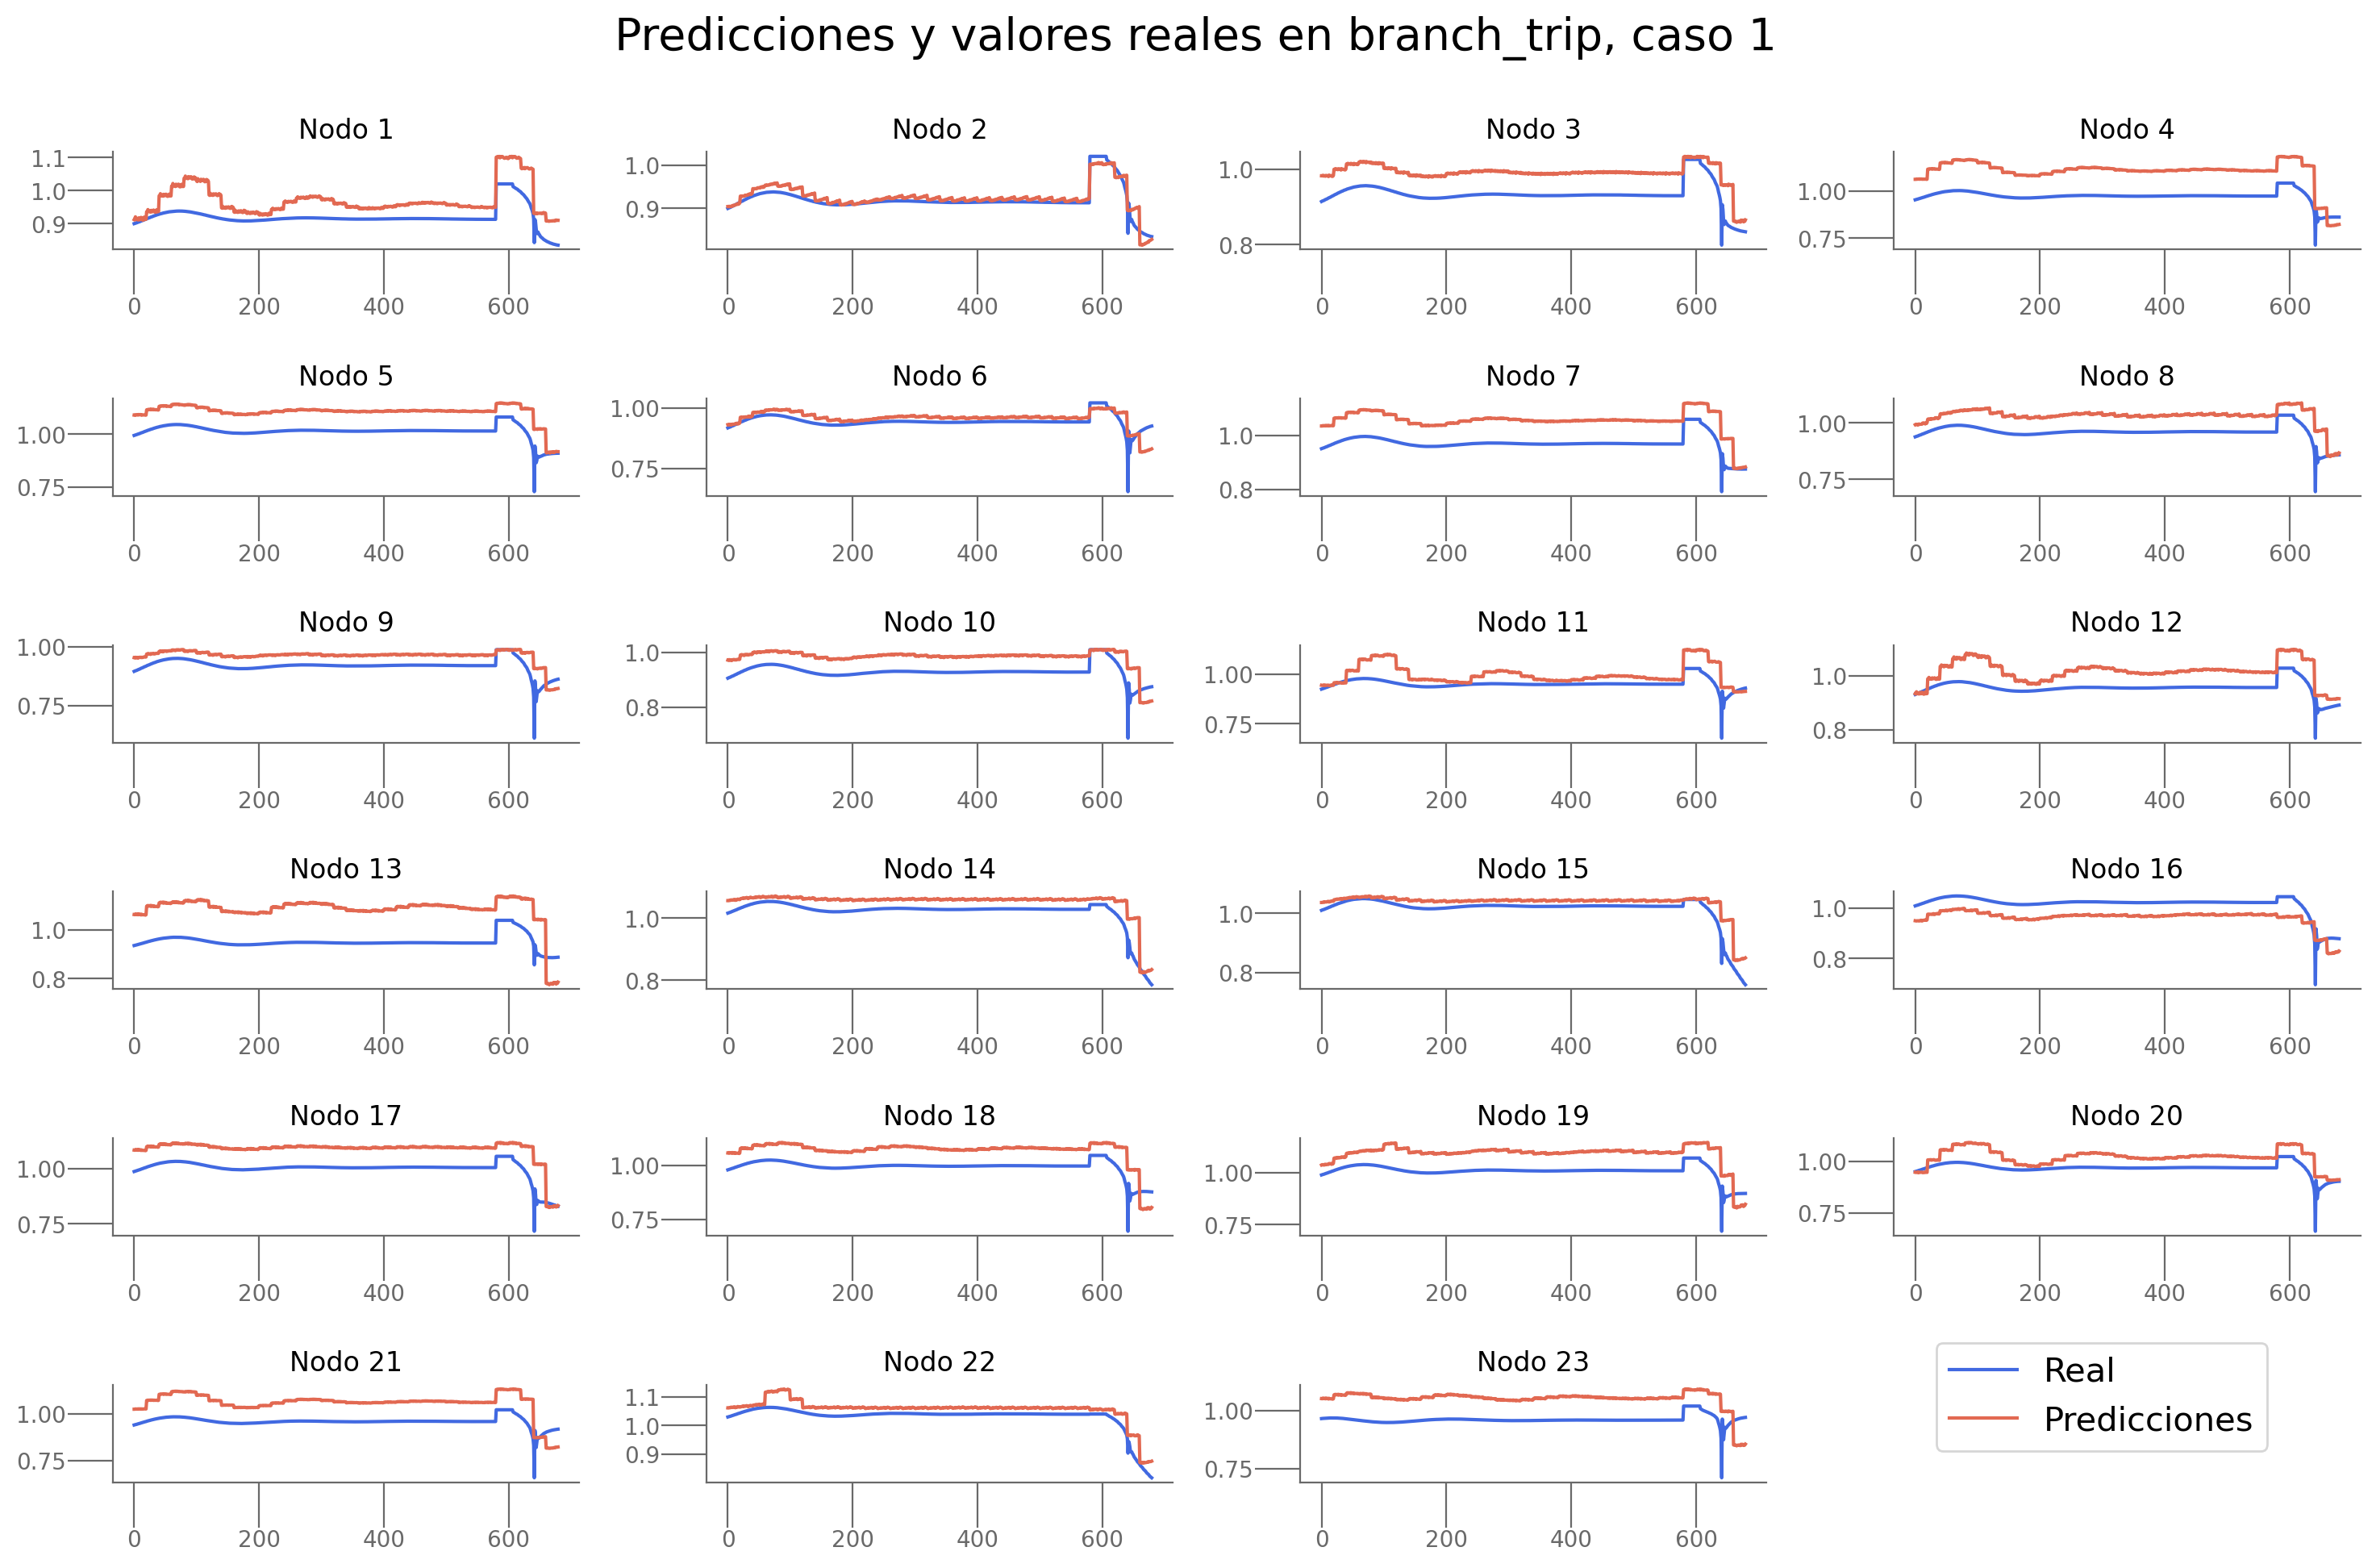

In [38]:
_,_,_, predictions_brt_ajuste,real_brt_ajuste = trainer_brt.test()
plot_predictions(predictions_brt_ajuste, real_brt_ajuste, n_target, 1, n_div_brt, problem_brt)

In [39]:
trainer_brt.save_model(path_save_experiment=path_save_experiment_brt, params = params_brt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 2}   
3     MPNN_LSTM                {'hidden_size': 32, 'dropout': 0.8}   
4         DCRNN                                     {'hidden': 60}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
6        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
7     EvolveGCN                                                NaN   
8        ASTGCN                                                NaN   
9         AGCRN            {'hidden': 10, 'K': 10, 'embedding': 2}   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.003700   0.398922   
1          